In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import astropy.units as u
import scipy.integrate as integrate
import os, csv
from tqdm import tqdm

def create_dir(filepath):
    if not os.path.exists(filepath):
        os.makedirs(filepath)

In [2]:
LAT_4fgldr4 = fits.open('gll_psc_v35.fits')
LAT_names = LAT_4fgldr4[1].data['SOURCE_NAME']
LAT_pref_spec = LAT_4fgldr4[1].data['SpectrumType']
LAT_Enorm = LAT_4fgldr4[1].data['Pivot_Energy']

#PWL params
LAT_PWL_idx = LAT_4fgldr4[1].data['PL_Index']
LAT_PWL_norm = LAT_4fgldr4[1].data['PL_Flux_Density']

#LogP params
LAT_LP_idx = LAT_4fgldr4[1].data['LP_Index']
LAT_LP_curv = LAT_4fgldr4[1].data['LP_beta']
LAT_LP_norm = LAT_4fgldr4[1].data['LP_Flux_Density']

#PWLCO
LAT_PWLCO_idx = LAT_4fgldr4[1].data['PLEC_IndexS']
LAT_PWLCO_norm = LAT_4fgldr4[1].data['PLEC_Flux_Density']
LAT_PWLCO_curv = LAT_4fgldr4[1].data['PLEC_ExpfactorS']
LAT_PWLCO_exp_idx = LAT_4fgldr4[1].data['PLEC_Exp_Index']

#From all the 4FGL catalog select only those for which we have the lightcurve
with open("Light_Curve_Names.txt", "r") as file:
    LC_sources = [line.strip() for line in file]
    
lc_sources=[]
for p in range(len(LAT_names)):
    for j in range(len(LC_sources)):
        if LAT_names[p]==LC_sources[j]:
            lc_sources.append(p)

LAT_names=LAT_names[lc_sources]
LAT_pref_spec=LAT_pref_spec[lc_sources]
LAT_Enorm=LAT_Enorm[lc_sources]

LAT_PWL_idx=LAT_PWL_idx[lc_sources]
LAT_PWL_norm=LAT_PWL_norm[lc_sources]

LAT_LP_idx=LAT_LP_idx[lc_sources]
LAT_LP_curv=LAT_LP_curv[lc_sources]
LAT_LP_norm=LAT_LP_norm[lc_sources]

LAT_PWLCO_idx=LAT_PWLCO_idx[lc_sources]
LAT_PWLCO_norm=LAT_PWLCO_norm[lc_sources]
LAT_PWLCO_curv=LAT_PWLCO_curv[lc_sources]
LAT_PWLCO_exp_idx=LAT_PWLCO_exp_idx[lc_sources]

BAT_LAT_match = fits.open('BAT_LAT_match_4FGL_info.fits')
BAT_LAT_names = BAT_LAT_match[1].data['LAT_NAME']
BAT_LAT_norm=BAT_LAT_match[1].data['norm']
BAT_LAT_gamma1=BAT_LAT_match[1].data['gamma1']
BAT_LAT_gamma2=BAT_LAT_match[1].data['gamma2']
BAT_LAT_log10_ebreak=BAT_LAT_match[1].data['log10(e_break)']
BAT_LAT_ebreak=10**BAT_LAT_log10_ebreak
BAT_LAT_function=BAT_LAT_match[1].data['function']

BAT_LAT_names = BAT_LAT_match[1].data['LAT_NAME']
BAT_LAT_pref_spec = BAT_LAT_match[1].data['SpectrumType']
BAT_LAT_Enorm = BAT_LAT_match[1].data['Pivot_Energy']

#PWL params
BAT_LAT_PWL_idx = BAT_LAT_match[1].data['PL_Index']
BAT_LAT_PWL_norm = BAT_LAT_match[1].data['PL_Flux_Density']

#LogP params
BAT_LAT_LP_idx = BAT_LAT_match[1].data['LP_Index']
BAT_LAT_LP_curv = BAT_LAT_match[1].data['LP_beta']
BAT_LAT_LP_norm = BAT_LAT_match[1].data['LP_Flux_Density']

#PWLCO
BAT_LAT_PWLCO_idx = BAT_LAT_match[1].data['PLEC_IndexS']
BAT_LAT_PWLCO_norm = BAT_LAT_match[1].data['PLEC_Flux_Density']
BAT_LAT_PWLCO_curv = BAT_LAT_match[1].data['PLEC_ExpfactorS']
BAT_LAT_PWLCO_exp_idx = BAT_LAT_match[1].data['PLEC_Exp_Index']

#Remove from the 4FGL catalog sources that we have in the cross-matched BAT-LAT list
matched_sources=[]
for i in range(len(LAT_names)):
    for j in range(len(BAT_LAT_names)):
        if LAT_names[i]==BAT_LAT_names[j]:
            matched_sources.append(i)

LAT_names = np.delete(LAT_names,matched_sources)
LAT_pref_spec = np.delete(LAT_pref_spec,matched_sources)
LAT_Enorm = np.delete(LAT_Enorm,matched_sources)

#PWL params
LAT_PWL_idx = np.delete(LAT_PWL_idx,matched_sources)
LAT_PWL_norm = np.delete(LAT_PWL_norm,matched_sources)

#LogP params
LAT_LP_idx = np.delete(LAT_LP_idx,matched_sources)
LAT_LP_curv = np.delete(LAT_LP_curv,matched_sources)
LAT_LP_norm = np.delete(LAT_LP_norm,matched_sources)

#PWLCO
LAT_PWLCO_idx = np.delete(LAT_PWLCO_idx,matched_sources)
LAT_PWLCO_norm = np.delete(LAT_PWLCO_norm,matched_sources)
LAT_PWLCO_curv = np.delete(LAT_PWLCO_curv,matched_sources)
LAT_PWLCO_exp_idx = np.delete(LAT_PWLCO_exp_idx,matched_sources)

#Remove sources with pref spectrum power law (over-optimistic extrapolation)
PWL_sources=[]
for i in range(len(LAT_names)):
    if LAT_pref_spec[i]=='PowerLaw' or LAT_pref_spec[i]=='PLSuperExpCutoff':
        PWL_sources.append(i)

LAT_names = np.delete(LAT_names,PWL_sources)
LAT_pref_spec = np.delete(LAT_pref_spec,PWL_sources)
LAT_Enorm = np.delete(LAT_Enorm,PWL_sources)

#PWL params
LAT_PWL_idx = np.delete(LAT_PWL_idx,PWL_sources)
LAT_PWL_norm = np.delete(LAT_PWL_norm,PWL_sources)

#LogP params
LAT_LP_idx = np.delete(LAT_LP_idx,PWL_sources)
LAT_LP_curv = np.delete(LAT_LP_curv,PWL_sources)
LAT_LP_norm = np.delete(LAT_LP_norm,PWL_sources)

#PWLCO
LAT_PWLCO_idx = np.delete(LAT_PWLCO_idx,PWL_sources)
LAT_PWLCO_norm = np.delete(LAT_PWLCO_norm,PWL_sources)
LAT_PWLCO_curv = np.delete(LAT_PWLCO_curv,PWL_sources)
LAT_PWLCO_exp_idx = np.delete(LAT_PWLCO_exp_idx,PWL_sources)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 874/874 [09:43<00:00,  1.50it/s]


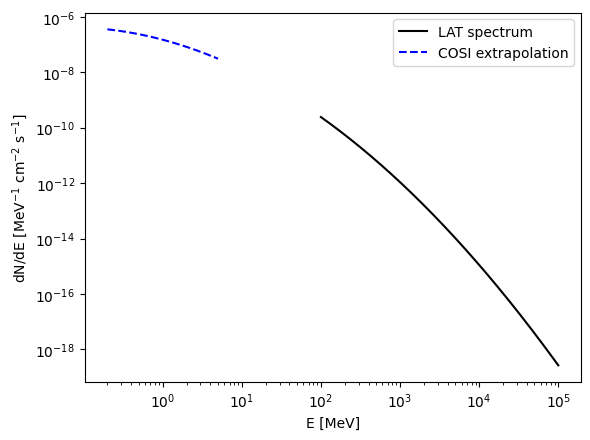

In [3]:
e_LAT = np.linspace(100,100000,100000)*u.MeV
e_COSI = np.linspace(0.2,5,100000)*u.MeV
LAT_spec=[]
COSI_spec=[]
create_dir('extrapolation_figures')

for i in tqdm(range(len(LAT_names))):
    plt.close('all')
    name = LAT_names[i].replace(" ", "")
    pref_spec=LAT_pref_spec[i]
    e0=LAT_Enorm[i]*u.MeV
    
    if pref_spec=='PowerLaw':
        f0=LAT_PWL_norm[i]*u.Unit('MeV-1 cm-2 s-1')
        gamma=LAT_PWL_idx[i]
        
        f_LAT=f0*pow(e_LAT/e0,(-1)*gamma)
        f_COSI=f0*pow(e_COSI/e0,(-1)*gamma)
        LAT_spec.append(f_LAT)
        COSI_spec.append(f_COSI)
        
    elif pref_spec=='LogParabola':
        f0=LAT_LP_norm[i]*u.Unit('MeV-1 cm-2 s-1')
        gamma=LAT_LP_idx[i]
        beta=LAT_LP_curv[i]

        f_LAT=f0*pow(e_LAT/e0,(-1)*(gamma+beta*np.log(e_LAT/e0)))
        f_COSI=f0*pow(e_COSI/e0,(-1)*(gamma+beta*np.log(e_COSI/e0)))
        LAT_spec.append(f_LAT)
        COSI_spec.append(f_COSI)
        
    elif pref_spec=='PLSuperExpCutoff':
        f0=LAT_PWLCO_norm[i]*u.Unit('MeV-1 cm-2 s-1')
        gamma=LAT_PWLCO_idx[i]
        b=LAT_PWLCO_exp_idx[i]
        d=LAT_PWLCO_curv[i]

        f_LAT=f0*pow(e_LAT/e0,d/b-gamma)*np.exp((d/b**2)*(1-pow(e_LAT/e0,b)))
        f_COSI=f0*pow(e_COSI/e0,d/b-gamma)*np.exp((d/b**2)*(1-pow(e_COSI/e0,b)))
        LAT_spec.append(f_LAT)
        COSI_spec.append(f_COSI)

    plt.figure()
    plt.plot(e_LAT,f_LAT,'-k',label='LAT spectrum')
    plt.plot(e_COSI,f_COSI,'--b',label='COSI extrapolation')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('E [MeV]')
    plt.ylabel(r'dN/dE [MeV$^{-1}$ cm$^{-2}$ s$^{-1}$]')
    plt.legend(loc='best')
    plt.savefig('./extrapolation_figures/'+name+'_extrapolation.png',bbox_inches='tight')


In [4]:
def bzq_spec(x_, norm, Eb, gamma1, gamma2):
    # SMPL
    return norm * 1/((x_/Eb)**gamma1 + (x_/Eb)**gamma2)

def bzb_spec(x_, norm, Eb, gamma1, gamma2):
    # SMPL_INV
    return ((x_/Eb)**gamma1 + (x_/Eb)**gamma2) * norm

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [01:06<00:00,  1.02s/it]


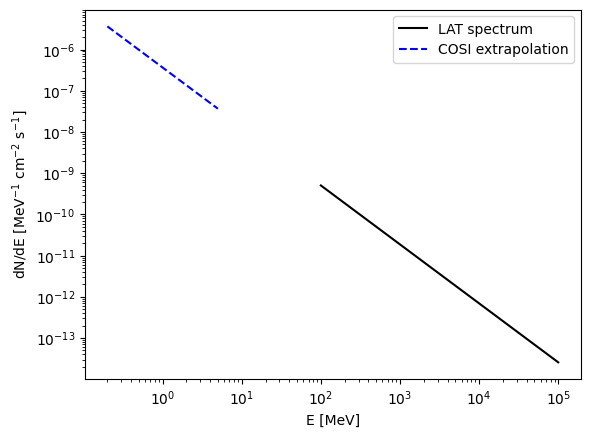

In [5]:
for i in tqdm(range(len(BAT_LAT_names))):
    plt.close('all')
    name = BAT_LAT_names[i].replace(" ", "")
    pref_spec=BAT_LAT_pref_spec[i]
    e0=BAT_LAT_Enorm[i]*u.MeV

    COSI_norm=BAT_LAT_norm[i]
    COSI_ebreak=BAT_LAT_ebreak[i]*u.keV
    COSI_ebreak=COSI_ebreak.to('MeV')
    COSI_gamma1=BAT_LAT_gamma1[i]
    COSI_gamma2=BAT_LAT_gamma2[i]
    COSI_function=BAT_LAT_function[i]
        
    if COSI_function=='smpl':
        f_COSI=bzq_spec(e_COSI,COSI_norm,COSI_ebreak,COSI_gamma1,COSI_gamma1)
        f_LAT=bzq_spec(e_LAT,COSI_norm,COSI_ebreak,COSI_gamma1,COSI_gamma1)
    elif COSI_function=='smpl_inv':
        f_COSI=bzb_spec(e_COSI,COSI_norm,COSI_ebreak,COSI_gamma1,COSI_gamma2)
        f_LAT=bzb_spec(e_LAT,COSI_norm,COSI_ebreak,COSI_gamma1,COSI_gamma2)
            
    COSI_spec.append(f_COSI)
    LAT_spec.append(f_LAT)
        
    plt.figure()
    plt.plot(e_LAT,f_LAT,'-k',label='LAT spectrum')
    plt.plot(e_COSI,f_COSI,'--b',label='COSI extrapolation')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('E [MeV]')
    plt.ylabel(r'dN/dE [MeV$^{-1}$ cm$^{-2}$ s$^{-1}$]')
    plt.legend(loc='best')
    plt.savefig('./extrapolation_figures/'+name+'_extrapolation.png',bbox_inches='tight')

LAT_spec = np.array(LAT_spec)
COSI_spec = np.array(COSI_spec)

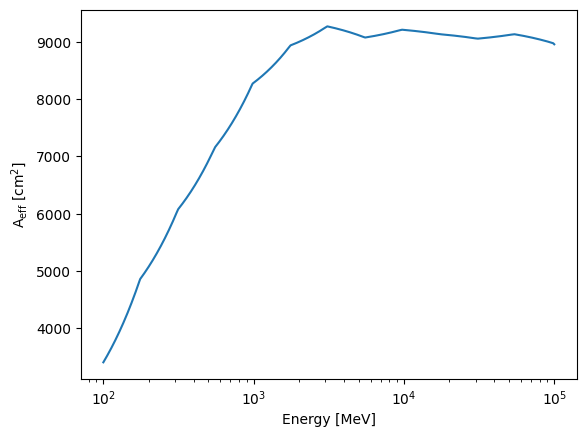

In [6]:
LAT_aeff=np.loadtxt('LAT_aeff.txt')
E_aeff_LAT=LAT_aeff[:,0]*u.MeV
aeff_LAT=LAT_aeff[:,1]*u.Unit('m2')
aeff_LAT=aeff_LAT.to('cm2')

f_interp_LAT = interp1d(E_aeff_LAT,aeff_LAT)
Aeff_LAT_interp = f_interp_LAT(e_LAT)*u.Unit('cm2')

plt.figure()
plt.plot(e_LAT, Aeff_LAT_interp)
plt.xscale('log')
#plt.ylim(0, 120)
plt.ylabel(r'A$_{\rm eff}$ [cm$^2$]')
plt.xlabel('Energy [MeV]')
plt.savefig('LAT_aeff.png',bbox_inches='tight')

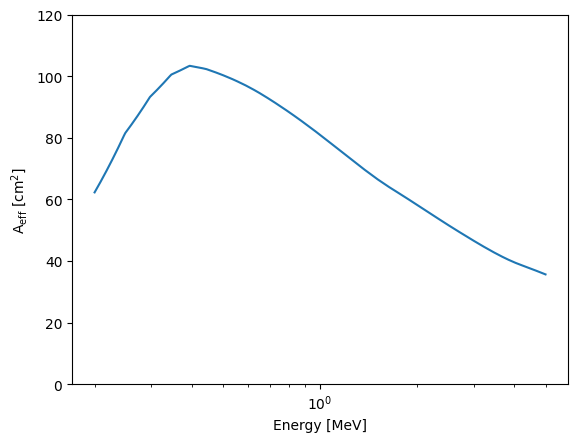

In [7]:
COSI_aeff=np.loadtxt('COSI_aeff.txt')
E_aeff_COSI=COSI_aeff[:,0]*u.keV
aeff_COSI=COSI_aeff[:,1]*u.Unit('cm2')
E_aeff_COSI=E_aeff_COSI.to('MeV')

f_interp_COSI = interp1d(E_aeff_COSI,aeff_COSI)
Aeff_COSI_interp = f_interp_COSI(e_COSI)*u.Unit('cm2')
 
plt.figure()
plt.plot(e_COSI, Aeff_COSI_interp)
plt.xscale('log')
plt.ylim(0, 120)
plt.ylabel(r'A$_{\rm eff}$ [cm$^2$]')
plt.xlabel('Energy [MeV]')
plt.savefig('COSI_aeff.png',bbox_inches='tight')

In [8]:
LAT_names_all=np.concatenate((LAT_names,BAT_LAT_names))

  0%|                                                                                                                     | 0/939 [00:00<?, ?it/s]

4FGL J0001.5+2113
LAT
0.0002805846185536339
COSI
0.00015940422442167738



  0%|                                                                                                             | 1/939 [00:00<09:18,  1.68it/s]

4FGL J0003.3-1928
LAT
2.1560749401125618e-05
COSI
1.9033865709344056e-08



  0%|▏                                                                                                            | 2/939 [00:01<10:55,  1.43it/s]

4FGL J0004.3+4614
LAT
5.970193448340267e-05
COSI
0.00010444093849860471



  0%|▎                                                                                                            | 3/939 [00:01<09:28,  1.65it/s]

4FGL J0004.4-4737
LAT
4.862679683760706e-05
COSI
5.2566186174754484e-05



  0%|▍                                                                                                            | 4/939 [00:02<08:48,  1.77it/s]

4FGL J0005.9+3824
LAT
7.021246008994914e-05
COSI
1.1647023308168733e-05



  1%|▌                                                                                                            | 5/939 [00:02<08:28,  1.84it/s]

4FGL J0009.3+5030
LAT
0.00010182351048998171
COSI
1.1444805360867042e-05



  1%|▋                                                                                                            | 6/939 [00:03<09:27,  1.64it/s]

4FGL J0010.6-3025
LAT
5.8138668576669746e-05
COSI
8.083162181746176e-06



  1%|▊                                                                                                            | 7/939 [00:04<09:20,  1.66it/s]

4FGL J0011.4+0057
LAT
7.788020234656128e-05
COSI
3.672901976449577e-05



  1%|▉                                                                                                            | 8/939 [00:04<09:19,  1.66it/s]

4FGL J0014.1+1910
LAT
1.580765112908986e-05
COSI
3.688303151682444e-08



  1%|█                                                                                                            | 9/939 [00:05<10:53,  1.42it/s]

4FGL J0014.9+3212
LAT
5.543525892730481e-05
COSI
4.631023160149382e-06



  1%|█▏                                                                                                          | 10/939 [00:06<10:13,  1.51it/s]

4FGL J0016.2-0016
LAT
8.935469084644078e-05
COSI
1.3235037021352143e-05



  1%|█▎                                                                                                          | 11/939 [00:06<09:56,  1.56it/s]

4FGL J0017.5-0514
LAT
0.00011539117724908911
COSI
6.095421441315323e-05



  1%|█▍                                                                                                          | 12/939 [00:07<09:29,  1.63it/s]

4FGL J0019.6+7327
LAT
0.00011685383693512822
COSI
8.788358258949536e-05



  1%|█▍                                                                                                          | 13/939 [00:08<09:22,  1.65it/s]

4FGL J0021.5-2552
LAT
3.784476472263401e-05
COSI
3.952559836612257e-06



  1%|█▌                                                                                                          | 14/939 [00:09<15:40,  1.02s/it]

4FGL J0022.5+0608
LAT
0.00013990477638612067
COSI
6.381638615948029e-05



  2%|█▋                                                                                                          | 15/939 [00:10<15:02,  1.02it/s]

4FGL J0023.7-6820
LAT
5.6894137348635525e-05
COSI
6.074005056984795e-05



  2%|█▊                                                                                                          | 16/939 [00:11<13:28,  1.14it/s]

4FGL J0023.7+4457
LAT
6.977099992334553e-05
COSI
1.1841806143052244e-05



  2%|█▉                                                                                                          | 17/939 [00:12<12:05,  1.27it/s]

4FGL J0025.7-4801
LAT
1.1970036656535079e-05
COSI
1.012807835374236e-08



  2%|██                                                                                                          | 18/939 [00:12<12:00,  1.28it/s]

4FGL J0030.2-1647
LAT
4.202196194073694e-06
COSI
2.0910791864320403e-10



  2%|██▏                                                                                                         | 19/939 [00:13<11:58,  1.28it/s]

4FGL J0030.3-4224
LAT
0.00015772575188145288
COSI
0.0002848922990101675



  2%|██▎                                                                                                         | 20/939 [00:14<10:49,  1.41it/s]

4FGL J0030.6-0212
LAT
0.00019286072795825622
COSI
5.5309079310890275e-05



  2%|██▍                                                                                                         | 21/939 [00:14<10:28,  1.46it/s]

4FGL J0032.3-5522
LAT
2.3338082235404127e-05
COSI
4.7278331087874397e-07



  2%|██▌                                                                                                         | 22/939 [00:15<12:29,  1.22it/s]

4FGL J0033.5-1921
LAT
6.259724567653693e-05
COSI
2.929397558248488e-07



  2%|██▋                                                                                                         | 23/939 [00:16<12:31,  1.22it/s]

4FGL J0035.2+1514
LAT
2.5605678967756593e-05
COSI
3.856509028971467e-08



  3%|██▊                                                                                                         | 24/939 [00:17<12:36,  1.21it/s]

4FGL J0035.9+5950
LAT
6.882973557481422e-05
COSI
1.4657077272719393e-06



  3%|██▉                                                                                                         | 25/939 [00:18<12:19,  1.24it/s]

4FGL J0038.2-2459
LAT
0.0002751490620807482
COSI
6.664477598438628e-05



  3%|██▉                                                                                                         | 26/939 [00:18<11:01,  1.38it/s]

4FGL J0039.1+4330
LAT
6.94012100425211e-06
COSI
5.008111378270219e-09



  3%|███                                                                                                         | 27/939 [00:19<11:16,  1.35it/s]

4FGL J0043.8+3425
LAT
0.00010424867435759424
COSI
5.711018997182316e-06



  3%|███▏                                                                                                        | 28/939 [00:20<12:34,  1.21it/s]

4FGL J0045.3+2128
LAT
3.581721056484507e-05
COSI
3.345262873241857e-07



  3%|███▎                                                                                                        | 29/939 [00:21<12:12,  1.24it/s]

4FGL J0047.0+5657
LAT
3.2397266260109665e-05
COSI
6.573126020371922e-07



  3%|███▍                                                                                                        | 30/939 [00:22<13:03,  1.16it/s]

4FGL J0049.7+0237
LAT
0.00010136546332369594
COSI
3.939211690769594e-06



  3%|███▌                                                                                                        | 31/939 [00:23<12:52,  1.18it/s]

4FGL J0050.0-5736
LAT
0.00012447131983105438
COSI
0.0005824966641363834



  3%|███▋                                                                                                        | 32/939 [00:23<11:36,  1.30it/s]

4FGL J0050.4-0452
LAT
8.229513871992007e-05
COSI
2.6029928107350645e-05



  4%|███▊                                                                                                        | 33/939 [00:24<12:04,  1.25it/s]

4FGL J0050.7-0929
LAT
0.00017784790319397303
COSI
3.556355530949399e-05



  4%|███▉                                                                                                        | 34/939 [00:25<12:21,  1.22it/s]

4FGL J0051.1-0648
LAT
8.658562807376567e-05
COSI
5.373410424517295e-06



  4%|████                                                                                                        | 35/939 [00:26<12:21,  1.22it/s]

4FGL J0051.2-6242
LAT
4.011983277109543e-05
COSI
6.484220911412654e-08



  4%|████▏                                                                                                       | 36/939 [00:27<11:26,  1.32it/s]

4FGL J0051.5-4220
LAT
7.406205393091802e-05
COSI
9.893197089766347e-06



  4%|████▎                                                                                                       | 37/939 [00:27<11:26,  1.31it/s]

4FGL J0055.1-1219
LAT
5.702565802030849e-05
COSI
3.30413998664529e-06



  4%|████▎                                                                                                       | 38/939 [00:28<11:43,  1.28it/s]

4FGL J0056.4-2118
LAT
3.0022859403294993e-05
COSI
4.2797299806449205e-08



  4%|████▍                                                                                                       | 39/939 [00:29<13:33,  1.11it/s]

4FGL J0058.0-3233
LAT
5.6551120750755025e-05
COSI
1.6653591587242783e-07



  4%|████▌                                                                                                       | 40/939 [00:30<14:33,  1.03it/s]

4FGL J0058.4+3315
LAT
5.815993326341156e-06
COSI
1.8621317798635626e-10



  4%|████▋                                                                                                       | 41/939 [00:31<14:03,  1.06it/s]

4FGL J0059.4-5654
LAT
8.318777373631786e-05
COSI
6.767972018571057e-07



  4%|████▊                                                                                                       | 42/939 [00:32<12:33,  1.19it/s]

4FGL J0100.3+0745
LAT
5.477502199449756e-05
COSI
1.0928866108145926e-07



  5%|████▉                                                                                                       | 43/939 [00:33<13:21,  1.12it/s]

4FGL J0102.4+4214
LAT
6.561516437967268e-05
COSI
2.1733327858179926e-05



  5%|█████                                                                                                       | 44/939 [00:34<12:04,  1.24it/s]

4FGL J0102.8+5824
LAT
0.0003163900718477643
COSI
0.0002205971920671858



  5%|█████▏                                                                                                      | 45/939 [00:34<11:58,  1.24it/s]

4FGL J0103.5+5337
LAT
1.6979879131378702e-05
COSI
1.1360518031191716e-07



  5%|█████▎                                                                                                      | 46/939 [00:35<11:27,  1.30it/s]

4FGL J0104.8-2416
LAT
5.3482552261248174e-05
COSI
5.024457437017718e-05



  5%|█████▍                                                                                                      | 47/939 [00:36<10:25,  1.43it/s]

4FGL J0105.1+3929
LAT
5.314165163423166e-05
COSI
3.74601754912125e-05



  5%|█████▌                                                                                                      | 48/939 [00:36<09:33,  1.55it/s]

4FGL J0108.6+0134
LAT
0.0014470496763219895
COSI
0.00036450452658813153



  5%|█████▋                                                                                                      | 49/939 [00:37<09:00,  1.65it/s]

4FGL J0109.7+6133
LAT
0.00029125009123046384
COSI
3.509734624947466e-05



  5%|█████▊                                                                                                      | 50/939 [00:37<08:32,  1.73it/s]

4FGL J0112.0-6634
LAT
4.951766568302597e-05
COSI
4.467456499643541e-05



  5%|█████▊                                                                                                      | 51/939 [00:38<08:17,  1.79it/s]

4FGL J0112.1+2245
LAT
0.0004801880121090891
COSI
0.0001693848090707875



  6%|█████▉                                                                                                      | 52/939 [00:38<09:12,  1.61it/s]

4FGL J0112.8+3208
LAT
0.0002386921148491695
COSI
0.00021479995291723189



  6%|██████                                                                                                      | 53/939 [00:39<08:45,  1.69it/s]

4FGL J0113.1-3553
LAT
4.761655165421493e-05
COSI
2.8822043085662797e-05



  6%|██████▏                                                                                                     | 54/939 [00:39<08:21,  1.77it/s]

4FGL J0113.4+4948
LAT
9.066598143361264e-05
COSI
2.2427215526652122e-05



  6%|██████▎                                                                                                     | 55/939 [00:40<09:11,  1.60it/s]

4FGL J0117.8-2109
LAT
7.069640054038198e-05
COSI
5.944266257837932e-06



  6%|██████▍                                                                                                     | 56/939 [00:41<11:29,  1.28it/s]

4FGL J0118.7-0848
LAT
3.264434160365245e-05
COSI
2.308911155581225e-06



  6%|██████▌                                                                                                     | 57/939 [00:42<10:15,  1.43it/s]

4FGL J0118.9-2141
LAT
0.00021878260811921137
COSI
0.0004288921154508718



  6%|██████▋                                                                                                     | 58/939 [00:42<09:22,  1.57it/s]

4FGL J0120.4-2701
LAT
0.00012860769589042795
COSI
2.0918732975732286e-05



  6%|██████▊                                                                                                     | 59/939 [00:43<09:33,  1.54it/s]

4FGL J0125.3-2548
LAT
3.862013623901996e-05
COSI
2.3136500000596865e-06



  6%|██████▉                                                                                                     | 60/939 [00:44<09:50,  1.49it/s]

4FGL J0126.0-2221
LAT
3.529532281122802e-05
COSI
5.153357262934426e-06



  6%|███████                                                                                                     | 61/939 [00:44<09:12,  1.59it/s]

4FGL J0128.5+4440
LAT
5.987358160633452e-06
COSI
2.2164743673660176e-09



  7%|███████▏                                                                                                    | 62/939 [00:45<09:29,  1.54it/s]

4FGL J0131.1+6120
LAT
2.830846012958302e-05
COSI
5.289450892669313e-08



  7%|███████▏                                                                                                    | 63/939 [00:46<09:25,  1.55it/s]

4FGL J0132.1-0956
LAT
5.271331660907012e-05
COSI
6.885699242142493e-05



  7%|███████▎                                                                                                    | 64/939 [00:46<08:52,  1.64it/s]

4FGL J0132.7-1654
LAT
0.00018999867010048666
COSI
8.975179916889645e-05



  7%|███████▍                                                                                                    | 65/939 [00:47<08:32,  1.71it/s]

4FGL J0133.1-5201
LAT
0.0001484876811486464
COSI
3.272015080797139e-05



  7%|███████▌                                                                                                    | 66/939 [00:47<09:31,  1.53it/s]

4FGL J0137.0+4751
LAT
0.0002386624743806512
COSI
5.7204514652729955e-05



  7%|███████▋                                                                                                    | 67/939 [00:48<08:53,  1.64it/s]

4FGL J0137.6-2430
LAT
0.000119247592541145
COSI
0.0001669113030969331



  7%|███████▊                                                                                                    | 68/939 [00:49<08:28,  1.71it/s]

4FGL J0141.4-0928
LAT
0.00021009399622969155
COSI
6.573422476529618e-05



  7%|███████▉                                                                                                    | 69/939 [00:50<11:07,  1.30it/s]

4FGL J0143.1-3622
LAT
7.681163381340249e-05
COSI
8.563039037976218e-06



  7%|████████                                                                                                    | 70/939 [00:50<09:57,  1.45it/s]

4FGL J0143.7-5846
LAT
3.341450579255206e-05
COSI
5.489270091194022e-06



  8%|████████▏                                                                                                   | 71/939 [00:51<10:18,  1.40it/s]

4FGL J0144.6+2705
LAT
0.0003321527123562625
COSI
3.759854451678538e-05



  8%|████████▎                                                                                                   | 72/939 [00:52<10:28,  1.38it/s]

4FGL J0145.0-2732
LAT
8.158099966104669e-05
COSI
4.9423449527881123e-05



  8%|████████▍                                                                                                   | 73/939 [00:52<09:37,  1.50it/s]

4FGL J0146.0-6746
LAT
1.748897480833396e-05
COSI
3.3472467205099385e-07



  8%|████████▌                                                                                                   | 74/939 [00:53<09:54,  1.45it/s]

4FGL J0152.2+2206
LAT
6.192380255097947e-05
COSI
3.992638414421206e-05



  8%|████████▋                                                                                                   | 75/939 [00:54<09:09,  1.57it/s]

4FGL J0153.9+0823
LAT
5.066323912490958e-05
COSI
2.896885241122899e-06



  8%|████████▋                                                                                                   | 76/939 [00:54<09:25,  1.53it/s]

4FGL J0156.3-2420
LAT
7.037655542007628e-06
COSI
9.218154718950264e-09



  8%|████████▊                                                                                                   | 77/939 [00:55<10:02,  1.43it/s]

4FGL J0157.7-4614
LAT
3.543326224761319e-05
COSI
1.2713062836404375e-07



  8%|████████▉                                                                                                   | 78/939 [00:56<10:15,  1.40it/s]

4FGL J0158.5-3932
LAT
4.029947885443757e-05
COSI
1.6835518523010977e-05



  8%|█████████                                                                                                   | 79/939 [00:57<10:21,  1.38it/s]

4FGL J0159.5+1046
LAT
4.264303973708829e-05
COSI
3.167592564499514e-06



  9%|█████████▏                                                                                                  | 80/939 [00:57<10:09,  1.41it/s]

4FGL J0203.7+3042
LAT
0.00012997476242053037
COSI
2.4706990562373883e-05



  9%|█████████▎                                                                                                  | 81/939 [00:58<12:26,  1.15it/s]

4FGL J0204.8+1513
LAT
8.198203607528232e-05
COSI
0.0001791318918098018



  9%|█████████▍                                                                                                  | 82/939 [00:59<10:53,  1.31it/s]

4FGL J0205.0-1700
LAT
0.0002801743325908291
COSI
0.00023520897442771662



  9%|█████████▌                                                                                                  | 83/939 [00:59<09:49,  1.45it/s]

4FGL J0205.2+3212
LAT
0.0001567264533710554
COSI
0.000515243422410394



  9%|█████████▋                                                                                                  | 84/939 [01:00<09:03,  1.57it/s]

4FGL J0206.4-1151
LAT
8.799528601495936e-05
COSI
0.00011100110774651127



  9%|█████████▊                                                                                                  | 85/939 [01:00<08:30,  1.67it/s]

4FGL J0209.3-5228
LAT
7.380899129875114e-05
COSI
1.3374729199925678e-05



  9%|█████████▉                                                                                                  | 86/939 [01:01<08:59,  1.58it/s]

4FGL J0209.9+7229
LAT
2.0255251591723595e-05
COSI
5.59445018991135e-09



  9%|██████████                                                                                                  | 87/939 [01:02<09:06,  1.56it/s]

4FGL J0210.7-5101
LAT
0.0008427847829019222
COSI
0.0002771011302721576



  9%|██████████                                                                                                  | 88/939 [01:03<09:33,  1.48it/s]

4FGL J0211.2+1051
LAT
0.0003389874931574547
COSI
0.0002695118069912594



  9%|██████████▏                                                                                                 | 89/939 [01:03<08:55,  1.59it/s]

4FGL J0212.9+2244
LAT
2.4335345767467785e-05
COSI
6.607483504426002e-07



 10%|██████████▎                                                                                                 | 90/939 [01:04<09:17,  1.52it/s]

4FGL J0214.4-5822
LAT
2.6724074291889453e-06
COSI
2.1972361744102e-12



 10%|██████████▍                                                                                                 | 91/939 [01:05<09:54,  1.43it/s]

4FGL J0216.8-6635
LAT
2.2216367976815548e-05
COSI
7.871812012978645e-08



 10%|██████████▌                                                                                                 | 92/939 [01:05<09:38,  1.46it/s]

4FGL J0217.2+0837
LAT
0.0001522273033533108
COSI
0.00033274913359409203



 10%|██████████▋                                                                                                 | 93/939 [01:06<08:52,  1.59it/s]

4FGL J0217.8+0144
LAT
0.00025701351529526035
COSI
0.00015124351275573123



 10%|██████████▊                                                                                                 | 94/939 [01:07<09:22,  1.50it/s]

4FGL J0218.9+3643
LAT
8.17345830282532e-05
COSI
4.093681749523589e-05



 10%|██████████▉                                                                                                 | 95/939 [01:07<08:40,  1.62it/s]

4FGL J0221.1+3556
LAT
0.0006295750686554376
COSI
0.001697559002969466



 10%|███████████                                                                                                 | 96/939 [01:08<08:13,  1.71it/s]

4FGL J0221.5+2513
LAT
3.853021623675713e-06
COSI
2.2595699573822358e-12



 10%|███████████▏                                                                                                | 97/939 [01:08<08:44,  1.61it/s]

4FGL J0222.6+4302
LAT
0.0005574000378186475
COSI
0.00017282965752240644



 10%|███████████▎                                                                                                | 98/939 [01:10<11:26,  1.23it/s]

4FGL J0223.2-1653
LAT
2.289421137821677e-05
COSI
1.7073308287349302e-08



 11%|███████████▍                                                                                                | 99/939 [01:10<10:10,  1.38it/s]

4FGL J0225.1-2604
LAT
7.894026911554463e-05
COSI
0.00015327946483048116



 11%|███████████▍                                                                                               | 100/939 [01:11<09:28,  1.48it/s]

4FGL J0226.3-1845
LAT
1.8688803285903802e-05
COSI
1.8394235276939624e-08



 11%|███████████▌                                                                                               | 101/939 [01:11<08:50,  1.58it/s]

4FGL J0228.3-5547
LAT
0.0002644830509823746
COSI
9.60013235637625e-06



 11%|███████████▌                                                                                               | 102/939 [01:12<09:21,  1.49it/s]

4FGL J0229.5-3644
LAT
0.00010637592176678662
COSI
1.7129322280607598e-05



 11%|███████████▋                                                                                               | 103/939 [01:12<08:45,  1.59it/s]

4FGL J0230.8+4032
LAT
9.913942498507423e-05
COSI
6.606589253015912e-06



 11%|███████████▊                                                                                               | 104/939 [01:13<08:13,  1.69it/s]

4FGL J0231.2-4745
LAT
0.00015413399199507287
COSI
0.00020617618928736107



 11%|███████████▉                                                                                               | 105/939 [01:13<07:58,  1.74it/s]

4FGL J0236.8-6136
LAT
7.464397331672719e-05
COSI
0.0002719993681669041



 11%|████████████                                                                                               | 106/939 [01:14<07:43,  1.80it/s]

4FGL J0237.8+2848
LAT
0.0010094945669019018
COSI
0.0004522105984637841



 11%|████████████▏                                                                                              | 107/939 [01:15<07:33,  1.84it/s]

4FGL J0238.6+1637
LAT
0.000639746627390386
COSI
9.874496259505961e-05



 12%|████████████▎                                                                                              | 108/939 [01:15<08:24,  1.65it/s]

4FGL J0240.5+6113
LAT
0.00400031806569423
COSI
0.00011851638124487265



 12%|████████████▍                                                                                              | 109/939 [01:16<08:58,  1.54it/s]

4FGL J0242.3+1102
LAT
8.830704876846716e-05
COSI
1.7913873089193222e-06



 12%|████████████▌                                                                                              | 110/939 [01:17<08:33,  1.61it/s]

4FGL J0242.3+5216
LAT
0.00011509006914274667
COSI
5.920933116070144e-06



 12%|████████████▋                                                                                              | 111/939 [01:17<08:15,  1.67it/s]

4FGL J0243.4+7119
LAT
4.926952541389372e-05
COSI
4.587703407541529e-07



 12%|████████████▊                                                                                              | 112/939 [01:18<08:45,  1.57it/s]

4FGL J0245.9-4650
LAT
0.00020476416867265703
COSI
1.6623225409969143e-05



 12%|████████████▉                                                                                              | 113/939 [01:18<08:25,  1.63it/s]

4FGL J0250.2-8224
LAT
4.43340974471747e-05
COSI
1.1377541345066443e-05



 12%|████████████▉                                                                                              | 114/939 [01:19<08:06,  1.69it/s]

4FGL J0251.5-5958
LAT
1.8775032359031452e-05
COSI
2.1059729865256764e-07



 12%|█████████████                                                                                              | 115/939 [01:20<08:44,  1.57it/s]

4FGL J0252.8-2219
LAT
0.00036119945876850066
COSI
0.0002253960581115098



 12%|█████████████▏                                                                                             | 116/939 [01:20<08:21,  1.64it/s]

4FGL J0253.2-5441
LAT
0.00010140319277058096
COSI
0.00027393714860566345



 12%|█████████████▎                                                                                             | 117/939 [01:21<08:03,  1.70it/s]

4FGL J0258.1+2030
LAT
9.044611208257671e-06
COSI
6.06302679778871e-10



 13%|█████████████▍                                                                                             | 118/939 [01:21<08:20,  1.64it/s]

4FGL J0259.0+0552
LAT
3.339739393806847e-05
COSI
2.6683633806026806e-07



 13%|█████████████▌                                                                                             | 119/939 [01:23<11:09,  1.23it/s]

4FGL J0259.4+0746
LAT
0.00012542943393670122
COSI
7.385721794127699e-05



 13%|█████████████▋                                                                                             | 120/939 [01:24<11:00,  1.24it/s]

4FGL J0303.4-2407
LAT
0.0001903254236881078
COSI
9.679353455471957e-05



 13%|█████████████▊                                                                                             | 121/939 [01:24<10:46,  1.27it/s]

4FGL J0303.4-5232
LAT
3.4439482523370706e-05
COSI
1.0854089497411398e-06



 13%|█████████████▉                                                                                             | 122/939 [01:25<09:39,  1.41it/s]

4FGL J0303.6+4716
LAT
0.00015389316372566085
COSI
1.0708436944344503e-05



 13%|██████████████                                                                                             | 123/939 [01:26<09:41,  1.40it/s]

4FGL J0303.6-6211
LAT
0.00010619640392726514
COSI
2.2976302238158225e-05



 13%|██████████████▏                                                                                            | 124/939 [01:26<09:51,  1.38it/s]

4FGL J0304.5+6821
LAT
0.00016428985659723165
COSI
4.455089307890624e-06



 13%|██████████████▏                                                                                            | 125/939 [01:27<09:05,  1.49it/s]

4FGL J0309.0+1029
LAT
0.00011794843827344339
COSI
3.0293984316171773e-05



 13%|██████████████▎                                                                                            | 126/939 [01:28<09:33,  1.42it/s]

4FGL J0309.9-6058
LAT
0.00032475177216747695
COSI
0.0002297070463147423



 14%|██████████████▍                                                                                            | 127/939 [01:28<08:46,  1.54it/s]

4FGL J0314.3-5103
LAT
2.480122983523223e-05
COSI
9.92791451845103e-07



 14%|██████████████▌                                                                                            | 128/939 [01:29<09:04,  1.49it/s]

4FGL J0315.9-1033
LAT
5.5375975148195514e-05
COSI
8.211684401051092e-06



 14%|██████████████▋                                                                                            | 129/939 [01:29<08:24,  1.61it/s]

4FGL J0316.2+0905
LAT
5.735218479654224e-05
COSI
2.930057531608809e-06



 14%|██████████████▊                                                                                            | 130/939 [01:30<08:35,  1.57it/s]

4FGL J0325.6-1646
LAT
3.2094780455028764e-05
COSI
2.4326347667767664e-06



 14%|██████████████▉                                                                                            | 131/939 [01:31<08:50,  1.52it/s]

4FGL J0325.7+2225
LAT
0.00023953122154161147
COSI
4.410812620515864e-05



 14%|███████████████                                                                                            | 132/939 [01:31<08:17,  1.62it/s]

4FGL J0330.6+0438
LAT
3.2487150587675605e-05
COSI
3.30151082995119e-07



 14%|███████████████▏                                                                                           | 133/939 [01:32<08:37,  1.56it/s]

4FGL J0331.3-6156
LAT
2.4150981711365172e-05
COSI
3.660992670935901e-07



 14%|███████████████▎                                                                                           | 134/939 [01:33<08:40,  1.55it/s]

4FGL J0332.1-1123
LAT
2.3552837427186553e-05
COSI
2.67254567368607e-07



 14%|███████████████▍                                                                                           | 135/939 [01:33<09:05,  1.47it/s]

4FGL J0333.9+6537
LAT
4.9068536216538624e-05
COSI
1.6115086077296995e-06



 14%|███████████████▍                                                                                           | 136/939 [01:34<09:12,  1.45it/s]

4FGL J0334.2-3725
LAT
0.00011841412302756191
COSI
9.505427196981275e-06



 15%|███████████████▌                                                                                           | 137/939 [01:35<09:19,  1.43it/s]

4FGL J0334.2-4008
LAT
0.0002331139253328836
COSI
5.774757302894365e-05



 15%|███████████████▋                                                                                           | 138/939 [01:36<09:32,  1.40it/s]

4FGL J0338.5+1302
LAT
2.7067929217590287e-05
COSI
1.6621096239740699e-09



 15%|███████████████▊                                                                                           | 139/939 [01:36<09:13,  1.45it/s]

4FGL J0339.5-0146
LAT
0.0004693699839213091
COSI
0.00046198161532426065



 15%|███████████████▉                                                                                           | 140/939 [01:37<11:33,  1.15it/s]

4FGL J0340.5-2118
LAT
7.812885149893756e-05
COSI
6.698657398654255e-05



 15%|████████████████                                                                                           | 141/939 [01:38<10:12,  1.30it/s]

4FGL J0343.2-2529
LAT
3.305350662973148e-05
COSI
1.2871758356629687e-07



 15%|████████████████▏                                                                                          | 142/939 [01:39<10:15,  1.30it/s]

4FGL J0343.2-6444
LAT
3.73942300358081e-05
COSI
7.680505063048968e-06



 15%|████████████████▎                                                                                          | 143/939 [01:40<10:10,  1.30it/s]

4FGL J0348.6-1609
LAT
6.197259912179622e-05
COSI
9.889900493061337e-05



 15%|████████████████▍                                                                                          | 144/939 [01:40<09:09,  1.45it/s]

4FGL J0348.8+4610
LAT
4.106375925007595e-05
COSI
6.764567696763163e-08



 15%|████████████████▌                                                                                          | 145/939 [01:41<08:37,  1.54it/s]

4FGL J0349.6+2410
LAT
4.00584834164379e-05
COSI
5.25601117596891e-07



 16%|████████████████▋                                                                                          | 146/939 [01:41<08:04,  1.64it/s]

4FGL J0349.8-2103
LAT
0.00012649154239784051
COSI
3.310697861840295e-05



 16%|████████████████▊                                                                                          | 147/939 [01:42<07:40,  1.72it/s]

4FGL J0354.4+4643
LAT
0.00010363758547744446
COSI
0.0001030239464626499



 16%|████████████████▊                                                                                          | 148/939 [01:42<07:23,  1.78it/s]

4FGL J0354.7+8009
LAT
1.273348576301503e-05
COSI
8.012595450497008e-08



 16%|████████████████▉                                                                                          | 149/939 [01:43<08:06,  1.62it/s]

4FGL J0358.6+0634
LAT
3.415197889914135e-05
COSI
2.53731474291732e-07



 16%|█████████████████                                                                                          | 150/939 [01:43<08:01,  1.64it/s]

4FGL J0359.6+5057
LAT
0.00047655438602063036
COSI
0.0001523790572820306



 16%|█████████████████▏                                                                                         | 151/939 [01:44<07:40,  1.71it/s]

4FGL J0401.7+2112
LAT
0.00010715539613781216
COSI
0.00045959168157338684



 16%|█████████████████▎                                                                                         | 152/939 [01:45<07:35,  1.73it/s]

4FGL J0401.9-2034
LAT
9.556043033686804e-05
COSI
1.3991531636899658e-05



 16%|█████████████████▍                                                                                         | 153/939 [01:45<08:42,  1.50it/s]

4FGL J0402.0-2616
LAT
2.3393244321090883e-05
COSI
4.831161524084951e-08



 16%|█████████████████▌                                                                                         | 154/939 [01:46<09:52,  1.32it/s]

4FGL J0407.0-3826
LAT
0.00024293400830249074
COSI
4.100901229807706e-05



 17%|█████████████████▋                                                                                         | 155/939 [01:47<09:09,  1.43it/s]

4FGL J0409.8-0359
LAT
1.8426778194126485e-05
COSI
1.8439044705000523e-09



 17%|█████████████████▊                                                                                         | 156/939 [01:48<09:50,  1.33it/s]

4FGL J0410.9+4216
LAT
3.617208479231991e-05
COSI
6.348975058555591e-07



 17%|█████████████████▉                                                                                         | 157/939 [01:49<09:46,  1.33it/s]

4FGL J0418.1-0252
LAT
4.148626172618139e-05
COSI
6.542152110878064e-08



 17%|██████████████████                                                                                         | 158/939 [01:49<10:05,  1.29it/s]

4FGL J0418.2+3807
LAT
0.0001712530041249673
COSI
0.00012747191391234105



 17%|██████████████████                                                                                         | 159/939 [01:50<09:35,  1.36it/s]

4FGL J0420.3-3745
LAT
6.866725684815926e-05
COSI
1.1546183358828096e-05



 17%|██████████████████▏                                                                                        | 160/939 [01:51<09:57,  1.30it/s]

4FGL J0422.1-0644
LAT
0.00013123905587359127
COSI
5.184915903036598e-05



 17%|██████████████████▎                                                                                        | 161/939 [01:51<09:06,  1.42it/s]

4FGL J0423.3-0120
LAT
0.0003159922388915335
COSI
0.00013397592054696097



 17%|██████████████████▍                                                                                        | 162/939 [01:52<08:31,  1.52it/s]

4FGL J0424.7+0036
LAT
0.0001030712356809953
COSI
6.814191223142824e-05



 17%|██████████████████▌                                                                                        | 163/939 [01:53<09:27,  1.37it/s]

4FGL J0424.9-5331
LAT
4.478466983855954e-05
COSI
1.8816986657266713e-06



 17%|██████████████████▋                                                                                        | 164/939 [01:54<09:54,  1.30it/s]

4FGL J0431.8+7403
LAT
1.1002773545447617e-05
COSI
4.3406341415119463e-08



 18%|██████████████████▊                                                                                        | 165/939 [01:54<09:33,  1.35it/s]

4FGL J0433.6-6030
LAT
0.00010916512218568589
COSI
1.5003504675795154e-05



 18%|██████████████████▉                                                                                        | 166/939 [01:55<09:00,  1.43it/s]

4FGL J0433.6+2905
LAT
0.0001379743857468079
COSI
3.026865996416186e-05



 18%|███████████████████                                                                                        | 167/939 [01:57<12:47,  1.01it/s]

4FGL J0434.1-2014
LAT
2.033709696153452e-05
COSI
4.037376793746451e-07



 18%|███████████████████▏                                                                                       | 168/939 [01:58<12:02,  1.07it/s]

4FGL J0438.9-4521
LAT
7.083527049231814e-05
COSI
3.010784884915879e-05



 18%|███████████████████▎                                                                                       | 169/939 [01:58<10:31,  1.22it/s]

4FGL J0442.6-0017
LAT
0.00036496507593701446
COSI
0.0008444350497856445



 18%|███████████████████▎                                                                                       | 170/939 [01:59<09:23,  1.36it/s]

4FGL J0443.3-6652
LAT
2.8812206126489854e-05
COSI
6.209782764349471e-06



 18%|███████████████████▍                                                                                       | 171/939 [01:59<08:49,  1.45it/s]

4FGL J0447.4-2747
LAT
2.833181442834348e-06
COSI
7.479050553824004e-15



 18%|███████████████████▌                                                                                       | 172/939 [02:00<08:53,  1.44it/s]

4FGL J0449.1+1121
LAT
0.0003107925532783303
COSI
0.00010910169972898241



 18%|███████████████████▋                                                                                       | 173/939 [02:01<09:17,  1.37it/s]

4FGL J0449.2+6329
LAT
9.476272407756245e-05
COSI
4.647832764593251e-05



 19%|███████████████████▊                                                                                       | 174/939 [02:01<09:07,  1.40it/s]

4FGL J0449.4-4350
LAT
0.0003871051093194057
COSI
1.762819443090771e-05



 19%|███████████████████▉                                                                                       | 175/939 [02:02<10:34,  1.20it/s]

4FGL J0451.8-4651
LAT
4.207977191824634e-05
COSI
1.1499851583108327e-05



 19%|████████████████████                                                                                       | 176/939 [02:03<10:15,  1.24it/s]

4FGL J0453.1-2806
LAT
0.00025730162018253617
COSI
0.00020418339698177084



 19%|████████████████████▏                                                                                      | 177/939 [02:04<09:24,  1.35it/s]

4FGL J0455.7-4617
LAT
0.0001384984541923557
COSI
0.0016422179814037316



 19%|████████████████████▎                                                                                      | 178/939 [02:05<09:21,  1.35it/s]

4FGL J0457.0-2324
LAT
0.0013387463636714112
COSI
0.00043551944322521216



 19%|████████████████████▍                                                                                      | 179/939 [02:05<08:49,  1.43it/s]

4FGL J0501.2-0158
LAT
0.0005513507001213132
COSI
0.00038230615728967673



 19%|████████████████████▌                                                                                      | 180/939 [02:06<09:11,  1.38it/s]

4FGL J0502.5+3438
LAT
0.00012371244396600035
COSI
9.726940309692143e-06



 19%|████████████████████▋                                                                                      | 181/939 [02:07<10:16,  1.23it/s]

4FGL J0505.3+0459
LAT
0.0004884031866415121
COSI
9.062593947289403e-05



 19%|████████████████████▋                                                                                      | 182/939 [02:08<09:40,  1.30it/s]

4FGL J0505.6+6405
LAT
3.0994288248740525e-05
COSI
3.874940137196588e-07



 19%|████████████████████▊                                                                                      | 183/939 [02:09<10:07,  1.25it/s]

4FGL J0505.8-3817
LAT
6.081920193354402e-06
COSI
8.840779116530045e-09



 20%|████████████████████▉                                                                                      | 184/939 [02:09<09:55,  1.27it/s]

4FGL J0507.7-6104
LAT
7.946291336039797e-05
COSI
0.00018699612079655883



 20%|█████████████████████                                                                                      | 185/939 [02:10<09:07,  1.38it/s]

4FGL J0509.4+0542
LAT
0.0004367314657177849
COSI
0.00020865937208181676



 20%|█████████████████████▏                                                                                     | 186/939 [02:11<09:53,  1.27it/s]

4FGL J0510.0+1800
LAT
0.00019455573458952328
COSI
9.800509683486884e-06



 20%|█████████████████████▎                                                                                     | 187/939 [02:12<09:51,  1.27it/s]

4FGL J0510.4-1809
LAT
2.1858436477228025e-05
COSI
1.3395180384664234e-07



 20%|█████████████████████▍                                                                                     | 188/939 [02:12<09:01,  1.39it/s]

4FGL J0515.6-4556
LAT
0.00024227360839903947
COSI
0.00017577827945447223



 20%|█████████████████████▌                                                                                     | 189/939 [02:13<09:22,  1.33it/s]

4FGL J0515.8+1527
LAT
3.785016730153652e-05
COSI
1.3787089523242388e-07



 20%|█████████████████████▋                                                                                     | 190/939 [02:14<09:42,  1.29it/s]

4FGL J0516.7-6207
LAT
0.00014820004238451338
COSI
0.0003140926934535559



 20%|█████████████████████▊                                                                                     | 191/939 [02:15<09:32,  1.31it/s]

4FGL J0516.8-0509
LAT
4.9711279756395837e-05
COSI
1.5015157816852537e-07



 20%|█████████████████████▉                                                                                     | 192/939 [02:15<08:51,  1.41it/s]

4FGL J0521.7+2112
LAT
0.00045647596876166157
COSI
0.00010087013379813291



 21%|█████████████████████▉                                                                                     | 193/939 [02:16<09:47,  1.27it/s]

4FGL J0525.8-0052
LAT
2.0009802965103216e-05
COSI
2.1173293184234197e-07



 21%|██████████████████████                                                                                     | 194/939 [02:17<10:09,  1.22it/s]

4FGL J0526.2-4830
LAT
0.00029484048900983706
COSI
0.0001424139263376485



 21%|██████████████████████▏                                                                                    | 195/939 [02:18<11:06,  1.12it/s]

4FGL J0532.0-4827
LAT
0.00017351582482850298
COSI
1.6644347475182208e-05



 21%|██████████████████████▎                                                                                    | 196/939 [02:19<12:04,  1.03it/s]

4FGL J0532.6+0732
LAT
0.00048448332539546515
COSI
0.0004158556401879337



 21%|██████████████████████▍                                                                                    | 197/939 [02:20<11:20,  1.09it/s]

4FGL J0533.3+4823
LAT
0.00028207408592079207
COSI
0.000250129231355551



 21%|██████████████████████▌                                                                                    | 198/939 [02:21<10:00,  1.23it/s]

4FGL J0534.5+2201s
LAT
0.0016149812575096988
COSI
0.0027943363062671676



 21%|██████████████████████▋                                                                                    | 199/939 [02:21<09:18,  1.33it/s]

4FGL J0535.3+0934
LAT
3.2053343602382156e-05
COSI
9.29446894481662e-09



 21%|██████████████████████▊                                                                                    | 200/939 [02:22<08:48,  1.40it/s]

4FGL J0536.4-3401
LAT
0.00019714619037128166
COSI
0.00017074501500548533



 21%|██████████████████████▉                                                                                    | 201/939 [02:24<13:55,  1.13s/it]

4FGL J0539.6+1432
LAT
0.00010955606515505849
COSI
3.054538320539556e-05



 22%|███████████████████████                                                                                    | 202/939 [02:25<11:57,  1.03it/s]

4FGL J0540.0-7552
LAT
2.7218063696760285e-05
COSI
9.196087452513192e-09



 22%|███████████████████████▏                                                                                   | 203/939 [02:25<11:51,  1.04it/s]

4FGL J0540.8-5415
LAT
5.8628855757956e-05
COSI
8.999513749513566e-05



 22%|███████████████████████▏                                                                                   | 204/939 [02:26<10:36,  1.16it/s]

4FGL J0542.9-0913
LAT
0.0001779832022153221
COSI
7.887008932751961e-06



 22%|███████████████████████▎                                                                                   | 205/939 [02:27<09:47,  1.25it/s]

4FGL J0543.9-5531
LAT
6.195782656509444e-05
COSI
1.0868586437422911e-06



 22%|███████████████████████▍                                                                                   | 206/939 [02:28<10:32,  1.16it/s]

4FGL J0551.0-1622
LAT
5.0797567233465905e-06
COSI
1.5550580447666977e-14



 22%|███████████████████████▌                                                                                   | 207/939 [02:29<11:24,  1.07it/s]

4FGL J0555.1+0304
LAT
7.166880554394571e-05
COSI
4.515925302791494e-08



 22%|███████████████████████▋                                                                                   | 208/939 [02:30<10:27,  1.16it/s]

4FGL J0555.6+3947
LAT
0.0001852311229881368
COSI
8.469366355639638e-06



 22%|███████████████████████▊                                                                                   | 209/939 [02:31<11:21,  1.07it/s]

4FGL J0556.2-4352
LAT
1.2080202439585709e-05
COSI
3.254519944938683e-09



 22%|███████████████████████▉                                                                                   | 210/939 [02:32<11:04,  1.10it/s]

4FGL J0601.1-7035
LAT
0.00018596098089258126
COSI
3.120519638756382e-05



 22%|████████████████████████                                                                                   | 211/939 [02:33<11:29,  1.06it/s]

4FGL J0607.4+4739
LAT
0.00013755293949623869
COSI
1.8182197853692116e-05



 23%|████████████████████████▏                                                                                  | 212/939 [02:34<11:35,  1.05it/s]

4FGL J0608.0+6721
LAT
4.132474186334071e-05
COSI
2.6320975811505616e-06



 23%|████████████████████████▎                                                                                  | 213/939 [02:35<11:44,  1.03it/s]

4FGL J0608.0-0835
LAT
0.0001950840349366895
COSI
9.235559138451631e-05



 23%|████████████████████████▍                                                                                  | 214/939 [02:35<10:31,  1.15it/s]

4FGL J0608.1-1521
LAT
0.00012226502894099363
COSI
0.00018811485949948918



 23%|████████████████████████▍                                                                                  | 215/939 [02:36<10:11,  1.18it/s]

4FGL J0610.1-1848
LAT
3.8255518326731815e-05
COSI
3.906358131368778e-06



 23%|████████████████████████▌                                                                                  | 216/939 [02:37<10:37,  1.13it/s]

4FGL J0610.9-6054
LAT
4.9361364264927294e-05
COSI
7.2672416351779015e-06



 23%|████████████████████████▋                                                                                  | 217/939 [02:37<09:33,  1.26it/s]

4FGL J0612.8+4122
LAT
0.00016633654096511618
COSI
1.5740331576882668e-06



 23%|████████████████████████▊                                                                                  | 218/939 [02:38<09:23,  1.28it/s]

4FGL J0617.2+5701
LAT
5.8751961135264164e-05
COSI
4.543760176525269e-06



 23%|████████████████████████▉                                                                                  | 219/939 [02:39<09:31,  1.26it/s]

4FGL J0620.5-2512
LAT
8.298215115159089e-05
COSI
0.00011605290185580934



 23%|█████████████████████████                                                                                  | 220/939 [02:40<08:33,  1.40it/s]

4FGL J0622.3-2605
LAT
7.185562316483771e-05
COSI
1.2312342551542841e-05



 24%|█████████████████████████▏                                                                                 | 221/939 [02:40<08:52,  1.35it/s]

4FGL J0622.9+3326
LAT
0.0002010904333160514
COSI
0.00011126399269996475



 24%|█████████████████████████▎                                                                                 | 222/939 [02:41<09:16,  1.29it/s]

4FGL J0625.3+4439
LAT
4.7949088290149054e-05
COSI
2.3531238344200986e-05



 24%|█████████████████████████▍                                                                                 | 223/939 [02:42<09:20,  1.28it/s]

4FGL J0626.4-4259
LAT
3.697830554017737e-06
COSI
1.0882443360419962e-11



 24%|█████████████████████████▌                                                                                 | 224/939 [02:43<09:19,  1.28it/s]

4FGL J0628.8-6250
LAT
3.800354875781615e-05
COSI
9.42996673637929e-07



 24%|█████████████████████████▋                                                                                 | 225/939 [02:44<10:26,  1.14it/s]

4FGL J0629.3-1959
LAT
0.00010754045324334023
COSI
4.7784054541257275e-05



 24%|█████████████████████████▊                                                                                 | 226/939 [02:45<09:58,  1.19it/s]

4FGL J0630.9-2406
LAT
0.00012196239863497421
COSI
3.1441294177470803e-07



 24%|█████████████████████████▊                                                                                 | 227/939 [02:46<10:24,  1.14it/s]

4FGL J0631.1+2020
LAT
4.7459907230688585e-05
COSI
4.7751617051828e-07



 24%|█████████████████████████▉                                                                                 | 228/939 [02:46<10:04,  1.18it/s]

4FGL J0633.4-2222
LAT
5.736581754555342e-05
COSI
3.1568370560028432e-06



 24%|██████████████████████████                                                                                 | 229/939 [02:47<08:55,  1.33it/s]

4FGL J0634.9-2335
LAT
9.699347722687955e-05
COSI
0.00014139965676374642



 24%|██████████████████████████▏                                                                                | 230/939 [02:48<08:11,  1.44it/s]

4FGL J0638.6+7320
LAT
6.151786277392636e-05
COSI
0.00023097641788590552



 25%|██████████████████████████▎                                                                                | 231/939 [02:48<07:48,  1.51it/s]

4FGL J0641.7-0320
LAT
0.00024413082082683343
COSI
1.8651138149892816e-05



 25%|██████████████████████████▍                                                                                | 232/939 [02:49<07:35,  1.55it/s]

4FGL J0643.3+0857
LAT
0.0002599633156515273
COSI
6.4341288729960435e-06



 25%|██████████████████████████▌                                                                                | 233/939 [02:50<09:10,  1.28it/s]

4FGL J0644.4-6712
LAT
8.942553082688477e-05
COSI
9.713808734161255e-06



 25%|██████████████████████████▋                                                                                | 234/939 [02:51<10:06,  1.16it/s]

4FGL J0648.0-3045
LAT
0.00015462356061462864
COSI
4.805767256913263e-05



 25%|██████████████████████████▊                                                                                | 235/939 [02:51<09:15,  1.27it/s]

4FGL J0648.7+1516
LAT
2.5598122331653086e-05
COSI
1.956028245505915e-07



 25%|██████████████████████████▉                                                                                | 236/939 [02:52<09:40,  1.21it/s]

4FGL J0649.5-3139
LAT
3.329673070496538e-06
COSI
6.3825047118291285e-12



 25%|███████████████████████████                                                                                | 237/939 [02:55<14:32,  1.24s/it]

4FGL J0650.2-1636
LAT
0.00018086178518433572
COSI
7.569218278674202e-05



 25%|███████████████████████████                                                                                | 238/939 [02:55<12:03,  1.03s/it]

4FGL J0650.5-2851
LAT
2.7273355322362304e-05
COSI
1.2287699595563039e-06



 25%|███████████████████████████▏                                                                               | 239/939 [02:56<10:16,  1.14it/s]

4FGL J0650.7+2503
LAT
0.00012182280523391393
COSI
9.29520776273971e-06



 26%|███████████████████████████▎                                                                               | 240/939 [02:56<09:41,  1.20it/s]

4FGL J0654.3+5042
LAT
8.490277840221662e-05
COSI
5.2480664627635045e-05



 26%|███████████████████████████▍                                                                               | 241/939 [02:57<08:32,  1.36it/s]

4FGL J0654.4+4514
LAT
8.981309676446827e-05
COSI
5.7098260409016936e-05



 26%|███████████████████████████▌                                                                               | 242/939 [02:57<07:42,  1.51it/s]

4FGL J0656.3-0322
LAT
0.0002474476932060269
COSI
5.370006669779062e-06



 26%|███████████████████████████▋                                                                               | 243/939 [02:58<08:04,  1.44it/s]

4FGL J0659.6-2742
LAT
5.2131939007044524e-05
COSI
6.193497707313384e-07



 26%|███████████████████████████▊                                                                               | 244/939 [02:59<08:19,  1.39it/s]

4FGL J0700.5-6610
LAT
0.00019057843146636218
COSI
1.6563338905211102e-05



 26%|███████████████████████████▉                                                                               | 245/939 [03:00<08:27,  1.37it/s]

4FGL J0701.5-4634
LAT
0.00014808050201365748
COSI
1.3909930448312783e-05



 26%|████████████████████████████                                                                               | 246/939 [03:00<07:40,  1.50it/s]

4FGL J0702.7-1951
LAT
0.00011386053730196331
COSI
2.601561371860688e-05



 26%|████████████████████████████▏                                                                              | 247/939 [03:01<07:53,  1.46it/s]

4FGL J0703.3-0050
LAT
7.366164647033402e-05
COSI
1.0829545320273777e-06



 26%|████████████████████████████▎                                                                              | 248/939 [03:02<08:01,  1.44it/s]

4FGL J0704.8+4907
LAT
5.013547837227574e-05
COSI
7.294743229455107e-06



 27%|████████████████████████████▎                                                                              | 249/939 [03:02<07:23,  1.56it/s]

4FGL J0706.8+7742
LAT
3.578207630867906e-05
COSI
1.2315643275623366e-07



 27%|████████████████████████████▍                                                                              | 250/939 [03:03<07:35,  1.51it/s]

4FGL J0709.7-0255
LAT
0.00015026473400408524
COSI
0.0001593891877047074



 27%|████████████████████████████▌                                                                              | 251/939 [03:03<07:08,  1.61it/s]

4FGL J0710.8-3851
LAT
8.74168443692921e-05
COSI
0.00010768440250217297



 27%|████████████████████████████▋                                                                              | 252/939 [03:04<06:42,  1.71it/s]

4FGL J0710.9+4733
LAT
4.950184568749307e-05
COSI
2.4352034290563834e-05



 27%|████████████████████████████▊                                                                              | 253/939 [03:04<06:32,  1.75it/s]

4FGL J0712.7+5033
LAT
9.01297470429225e-05
COSI
0.0001856160332105546



 27%|████████████████████████████▉                                                                              | 254/939 [03:05<06:19,  1.80it/s]

4FGL J0713.8+1935
LAT
0.00015170649229152375
COSI
9.317675163812071e-05



 27%|█████████████████████████████                                                                              | 255/939 [03:05<06:10,  1.85it/s]

4FGL J0718.0+4536
LAT
5.558136988391348e-05
COSI
2.4037711629956893e-07



 27%|█████████████████████████████▏                                                                             | 256/939 [03:06<06:45,  1.69it/s]

4FGL J0719.3+3307
LAT
0.00025606147204915245
COSI
3.1285895057993985e-05



 27%|█████████████████████████████▎                                                                             | 257/939 [03:07<07:15,  1.57it/s]

4FGL J0720.0-6237
LAT
6.040115169162003e-05
COSI
8.189355289633768e-06



 27%|█████████████████████████████▍                                                                             | 258/939 [03:07<06:55,  1.64it/s]

4FGL J0721.3+0405
LAT
0.0001466029135099887
COSI
0.0001714138816370916



 28%|█████████████████████████████▌                                                                             | 259/939 [03:08<06:34,  1.72it/s]

4FGL J0725.2+1425
LAT
0.00029153370698699067
COSI
0.00020873902282729943



 28%|█████████████████████████████▋                                                                             | 260/939 [03:09<06:23,  1.77it/s]

4FGL J0725.5+0216
LAT
2.489200129767418e-05
COSI
9.552225895986834e-07



 28%|█████████████████████████████▋                                                                             | 261/939 [03:09<06:51,  1.65it/s]

4FGL J0726.4-4727
LAT
0.0001217411849394266
COSI
5.9007514760909516e-05



 28%|█████████████████████████████▊                                                                             | 262/939 [03:10<06:34,  1.72it/s]

4FGL J0730.3-1141
LAT
0.0009501857184170775
COSI
0.0004196000949628125



 28%|█████████████████████████████▉                                                                             | 263/939 [03:10<06:55,  1.63it/s]

4FGL J0732.7-4638
LAT
4.328236521176858e-05
COSI
1.96108732022579e-09



 28%|██████████████████████████████                                                                             | 264/939 [03:11<06:38,  1.69it/s]

4FGL J0733.8+0455
LAT
5.0252713099474936e-05
COSI
2.916909238389281e-05



 28%|██████████████████████████████▏                                                                            | 265/939 [03:12<06:28,  1.74it/s]

4FGL J0734.0+5021
LAT
6.927660319301797e-05
COSI
3.2002867200687916e-06



 28%|██████████████████████████████▎                                                                            | 266/939 [03:12<07:20,  1.53it/s]

4FGL J0734.4-7711
LAT
4.903819086096028e-05
COSI
3.7579722682276224e-07



 28%|██████████████████████████████▍                                                                            | 267/939 [03:13<07:48,  1.43it/s]

4FGL J0738.1+1742
LAT
0.0002840249993864438
COSI
6.261937362262134e-05



 29%|██████████████████████████████▌                                                                            | 268/939 [03:14<08:12,  1.36it/s]

4FGL J0739.2+0137
LAT
0.0006426553608289782
COSI
0.0003020060286156824



 29%|██████████████████████████████▋                                                                            | 269/939 [03:14<07:29,  1.49it/s]

4FGL J0741.4-4709
LAT
6.60665088925553e-05
COSI
1.2256524238862808e-05



 29%|██████████████████████████████▊                                                                            | 270/939 [03:15<06:54,  1.61it/s]

4FGL J0742.6+5443
LAT
0.00016408977674199128
COSI
0.00016684743245089416



 29%|██████████████████████████████▉                                                                            | 271/939 [03:16<06:38,  1.68it/s]

4FGL J0742.9-5242
LAT
6.0623477467782514e-05
COSI
2.6779131857430636e-06



 29%|██████████████████████████████▉                                                                            | 272/939 [03:16<06:26,  1.73it/s]

4FGL J0746.3-0225
LAT
1.2866002680482313e-05
COSI
1.1341170513835566e-07



 29%|███████████████████████████████                                                                            | 273/939 [03:17<06:43,  1.65it/s]

4FGL J0746.6-4754
LAT
6.998035701979932e-05
COSI
6.121198652554716e-06



 29%|███████████████████████████████▏                                                                           | 274/939 [03:17<07:08,  1.55it/s]

4FGL J0748.0-1638
LAT
8.285200818561402e-05
COSI
1.3913254838924718e-05



 29%|███████████████████████████████▎                                                                           | 275/939 [03:18<06:40,  1.66it/s]

4FGL J0749.3+4453
LAT
2.5706947903823638e-05
COSI
2.5360966585361594e-07



 29%|███████████████████████████████▍                                                                           | 276/939 [03:19<07:10,  1.54it/s]

4FGL J0750.8+1229
LAT
0.00011415208116052626
COSI
4.6215063927141355e-05



 29%|███████████████████████████████▌                                                                           | 277/939 [03:19<06:42,  1.65it/s]

4FGL J0751.0+7908
LAT
1.888531023047506e-05
COSI
1.304682227488947e-09



 30%|███████████████████████████████▋                                                                           | 278/939 [03:20<07:09,  1.54it/s]

4FGL J0751.0-5131
LAT
9.184546075445436e-05
COSI
1.3184911578124983e-06



 30%|███████████████████████████████▊                                                                           | 279/939 [03:21<07:37,  1.44it/s]

4FGL J0753.9+0923
LAT
1.6910286380683303e-05
COSI
1.80285056399754e-08



 30%|███████████████████████████████▉                                                                           | 280/939 [03:22<07:53,  1.39it/s]

4FGL J0754.4-1148
LAT
0.00010099217223949945
COSI
5.732057705494918e-06



 30%|████████████████████████████████                                                                           | 281/939 [03:24<12:33,  1.15s/it]

4FGL J0754.7+4823
LAT
7.225696967564185e-05
COSI
1.633356821909377e-06



 30%|████████████████████████████████▏                                                                          | 282/939 [03:24<11:14,  1.03s/it]

4FGL J0757.1+0956
LAT
0.00010130472748366503
COSI
0.0001564956580018099



 30%|████████████████████████████████▏                                                                          | 283/939 [03:25<09:34,  1.14it/s]

4FGL J0800.4-2257
LAT
2.9296771762558854e-05
COSI
3.135735763557725e-10



 30%|████████████████████████████████▎                                                                          | 284/939 [03:26<08:27,  1.29it/s]

4FGL J0800.9+4401
LAT
1.5726867772378424e-05
COSI
1.5762745863701773e-07



 30%|████████████████████████████████▍                                                                          | 285/939 [03:26<08:17,  1.31it/s]

4FGL J0803.5+2046
LAT
1.410066811852334e-05
COSI
4.301409912897126e-10



 30%|████████████████████████████████▌                                                                          | 286/939 [03:27<07:34,  1.44it/s]

4FGL J0804.0-3629
LAT
1.8874685263597923e-05
COSI
6.044692529954168e-11



 31%|████████████████████████████████▋                                                                          | 287/939 [03:27<07:28,  1.45it/s]

4FGL J0805.2-0110
LAT
6.328593591207847e-05
COSI
1.3651638392845589e-05



 31%|████████████████████████████████▊                                                                          | 288/939 [03:28<06:52,  1.58it/s]

4FGL J0805.4+7534
LAT
4.923595134085284e-05
COSI
1.1585310661237186e-05



 31%|████████████████████████████████▉                                                                          | 289/939 [03:29<07:17,  1.48it/s]

4FGL J0807.1-0541
LAT
7.819369140724134e-05
COSI
2.342305854132797e-06



 31%|█████████████████████████████████                                                                          | 290/939 [03:29<07:28,  1.45it/s]

4FGL J0808.2-0751
LAT
0.0005849975230523054
COSI
8.833132250780892e-05



 31%|█████████████████████████████████▏                                                                         | 291/939 [03:30<07:43,  1.40it/s]

4FGL J0809.5+5341
LAT
8.65068471795011e-05
COSI
3.6911689755864946e-06



 31%|█████████████████████████████████▎                                                                         | 292/939 [03:31<07:53,  1.37it/s]

4FGL J0809.8+0507
LAT
3.577753919709815e-05
COSI
9.133084363930669e-09



 31%|█████████████████████████████████▍                                                                         | 293/939 [03:32<07:16,  1.48it/s]

4FGL J0809.8+5218
LAT
0.0001465218594931718
COSI
7.844705252984319e-05



 31%|█████████████████████████████████▌                                                                         | 294/939 [03:32<07:28,  1.44it/s]

4FGL J0811.0-7529
LAT
8.447339141255065e-05
COSI
2.365611054172278e-06



 31%|█████████████████████████████████▌                                                                         | 295/939 [03:33<07:30,  1.43it/s]

4FGL J0811.4+0146
LAT
0.00017500855258867495
COSI
7.415380790298611e-06



 32%|█████████████████████████████████▋                                                                         | 296/939 [03:34<07:33,  1.42it/s]

4FGL J0814.2-1013
LAT
6.382967198759194e-05
COSI
3.2511430122861665e-05



 32%|█████████████████████████████████▊                                                                         | 297/939 [03:35<07:48,  1.37it/s]

4FGL J0814.6+6430
LAT
0.0001226645942197614
COSI
0.0004656719862380545



 32%|█████████████████████████████████▉                                                                         | 298/939 [03:35<07:07,  1.50it/s]

4FGL J0816.3+5739
LAT
5.4719808407468404e-05
COSI
7.68716391251254e-06



 32%|██████████████████████████████████                                                                         | 299/939 [03:36<07:19,  1.45it/s]

4FGL J0816.4-1311
LAT
4.26157449046098e-05
COSI
9.97448056581953e-07



 32%|██████████████████████████████████▏                                                                        | 300/939 [03:36<07:23,  1.44it/s]

4FGL J0817.8-0934
LAT
7.347951847798779e-05
COSI
2.5402501773771262e-06



 32%|██████████████████████████████████▎                                                                        | 301/939 [03:37<07:40,  1.38it/s]

4FGL J0818.2+4222
LAT
0.00031672028227524543
COSI
5.73809510808367e-05



 32%|██████████████████████████████████▍                                                                        | 302/939 [03:38<07:45,  1.37it/s]

4FGL J0824.9+3915
LAT
6.0970667519518455e-05
COSI
1.5703649229359982e-05



 32%|██████████████████████████████████▌                                                                        | 303/939 [03:39<07:03,  1.50it/s]

4FGL J0825.9-3218
LAT
0.00010701957048013159
COSI
4.531289000759217e-06



 32%|██████████████████████████████████▋                                                                        | 304/939 [03:39<06:31,  1.62it/s]

4FGL J0825.9-2230
LAT
0.00023703842370961705
COSI
4.199096937647327e-05



 32%|██████████████████████████████████▊                                                                        | 305/939 [03:40<06:58,  1.51it/s]

4FGL J0827.6-3735
LAT
0.00010729958776173165
COSI
4.1732297770911166e-07



 33%|██████████████████████████████████▊                                                                        | 306/939 [03:40<06:41,  1.58it/s]

4FGL J0830.8+2410
LAT
0.000152914668363188
COSI
6.000970011139828e-06



 33%|██████████████████████████████████▉                                                                        | 307/939 [03:41<07:27,  1.41it/s]

4FGL J0831.8+0429
LAT
0.0002579754826749993
COSI
0.00014867237683302483



 33%|███████████████████████████████████                                                                        | 308/939 [03:42<06:51,  1.53it/s]

4FGL J0833.9+4223
LAT
5.432603177758438e-05
COSI
4.348094194043785e-05



 33%|███████████████████████████████████▏                                                                       | 309/939 [03:42<06:23,  1.64it/s]

4FGL J0839.8+0105
LAT
0.0001473607694940488
COSI
4.3333395046446984e-05



 33%|███████████████████████████████████▎                                                                       | 310/939 [03:43<06:06,  1.72it/s]

4FGL J0840.8+1317
LAT
2.0205729266674464e-05
COSI
3.249105466080023e-08



 33%|███████████████████████████████████▍                                                                       | 311/939 [03:44<06:41,  1.56it/s]

4FGL J0841.3-3554
LAT
2.099009617865474e-05
COSI
1.2365479694864574e-10



 33%|███████████████████████████████████▌                                                                       | 312/939 [03:44<06:48,  1.53it/s]

4FGL J0842.3-6053
LAT
5.22863904241974e-05
COSI
1.2217579188361347e-06



 33%|███████████████████████████████████▋                                                                       | 313/939 [03:45<07:00,  1.49it/s]

4FGL J0844.2+5312
LAT
4.035987488977369e-05
COSI
1.062470431521776e-05



 33%|███████████████████████████████████▊                                                                       | 314/939 [03:46<07:12,  1.45it/s]

4FGL J0849.1+6607
LAT
1.3595254871787315e-05
COSI
8.246351585475949e-08



 34%|███████████████████████████████████▉                                                                       | 315/939 [03:46<07:00,  1.48it/s]

4FGL J0849.8-3541
LAT
8.526414559338299e-05
COSI
1.156417709053431e-05



 34%|████████████████████████████████████                                                                       | 316/939 [03:47<07:18,  1.42it/s]

4FGL J0850.0+4855
LAT
9.525718212372105e-05
COSI
3.397832336899038e-05



 34%|████████████████████████████████████                                                                       | 317/939 [03:48<06:41,  1.55it/s]

4FGL J0850.0+5108
LAT
0.00010903261791991632
COSI
2.16642467465095e-05



 34%|████████████████████████████████████▏                                                                      | 318/939 [03:48<07:03,  1.47it/s]

4FGL J0850.1-1212
LAT
0.00016333222907691878
COSI
8.117744036862262e-05



 34%|████████████████████████████████████▎                                                                      | 319/939 [03:49<06:28,  1.59it/s]

4FGL J0851.5+5528
LAT
3.835675398601163e-05
COSI
6.241068217061516e-06



 34%|████████████████████████████████████▍                                                                      | 320/939 [03:50<07:32,  1.37it/s]

4FGL J0852.5-5755
LAT
0.00022397631786935608
COSI
4.344655073836993e-05



 34%|████████████████████████████████████▌                                                                      | 321/939 [03:50<06:53,  1.49it/s]

4FGL J0854.8+2006
LAT
0.00039459016791681137
COSI
0.0010799996777792707



 34%|████████████████████████████████████▋                                                                      | 322/939 [03:51<06:25,  1.60it/s]

4FGL J0856.6-1105
LAT
0.00011395776645031614
COSI
1.2095947894827851e-05



 34%|████████████████████████████████████▊                                                                      | 323/939 [03:52<06:49,  1.50it/s]

4FGL J0900.6-7408
LAT
4.2053437270744785e-05
COSI
1.8794402091907135e-06



 35%|████████████████████████████████████▉                                                                      | 324/939 [03:52<06:27,  1.59it/s]

4FGL J0902.4+2051
LAT
7.755112319418977e-05
COSI
4.030775676217473e-05



 35%|█████████████████████████████████████                                                                      | 325/939 [03:53<07:02,  1.45it/s]

4FGL J0904.0+2724
LAT
5.633946529949986e-05
COSI
2.3600928929082418e-06



 35%|█████████████████████████████████████▏                                                                     | 326/939 [03:54<06:37,  1.54it/s]

4FGL J0904.5-3513
LAT
6.671892821122475e-05
COSI
4.630739374661325e-06



 35%|█████████████████████████████████████▎                                                                     | 327/939 [03:54<06:23,  1.60it/s]

4FGL J0904.9-5734
LAT
0.0009963209241996332
COSI
0.000850495843747154



 35%|█████████████████████████████████████▍                                                                     | 328/939 [03:55<06:13,  1.64it/s]

4FGL J0905.6+1358
LAT
2.122562252023855e-05
COSI
1.3207239509012856e-08



 35%|█████████████████████████████████████▍                                                                     | 329/939 [03:55<06:23,  1.59it/s]

4FGL J0906.3-0905
LAT
2.579603800522814e-05
COSI
2.1566115286521947e-06



 35%|█████████████████████████████████████▌                                                                     | 330/939 [03:58<11:25,  1.13s/it]

4FGL J0909.1+0121
LAT
0.00023879923530144347
COSI
0.00018985950001859593



 35%|█████████████████████████████████████▋                                                                     | 331/939 [03:58<09:35,  1.06it/s]

4FGL J0909.7-0230
LAT
0.0001805243974038665
COSI
4.448253707040311e-05



 35%|█████████████████████████████████████▊                                                                     | 332/939 [03:59<08:14,  1.23it/s]

4FGL J0915.9+2933
LAT
5.7384901742225694e-05
COSI
5.272174286195617e-07



 35%|█████████████████████████████████████▉                                                                     | 333/939 [03:59<07:48,  1.29it/s]

4FGL J0916.7+3856
LAT
3.8238235822871e-05
COSI
4.0591729105616805e-06



 36%|██████████████████████████████████████                                                                     | 334/939 [04:00<07:48,  1.29it/s]

4FGL J0920.9+4441
LAT
0.0003650548237307845
COSI
3.9453267613894224e-05



 36%|██████████████████████████████████████▏                                                                    | 335/939 [04:01<07:49,  1.29it/s]

4FGL J0921.6+6216
LAT
0.0002874981775289916
COSI
8.505152740273853e-05



 36%|██████████████████████████████████████▎                                                                    | 336/939 [04:02<07:08,  1.41it/s]

4FGL J0922.6+0434
LAT
6.687647912814944e-05
COSI
3.8651501598469235e-05



 36%|██████████████████████████████████████▍                                                                    | 337/939 [04:02<06:34,  1.53it/s]

4FGL J0922.7-3959
LAT
0.00018881217383066366
COSI
0.00013270307928961537



 36%|██████████████████████████████████████▌                                                                    | 338/939 [04:03<06:07,  1.64it/s]

4FGL J0923.5+4125
LAT
5.2180312074307224e-05
COSI
3.831300095691262e-07



 36%|██████████████████████████████████████▋                                                                    | 339/939 [04:03<06:30,  1.54it/s]

4FGL J0929.3+5014
LAT
5.7504473369356276e-05
COSI
2.2960895599879852e-05



 36%|██████████████████████████████████████▋                                                                    | 340/939 [04:04<06:49,  1.46it/s]

4FGL J0930.3+8612
LAT
5.828459633149342e-05
COSI
1.8735650657118539e-06



 36%|██████████████████████████████████████▊                                                                    | 341/939 [04:05<07:04,  1.41it/s]

4FGL J0930.9-1015
LAT
2.3949464923447564e-05
COSI
7.77005484492331e-07



 36%|██████████████████████████████████████▉                                                                    | 342/939 [04:06<07:17,  1.36it/s]

4FGL J0931.2-8533
LAT
5.210826761170081e-05
COSI
3.722151494290272e-05



 37%|███████████████████████████████████████                                                                    | 343/939 [04:06<06:40,  1.49it/s]

4FGL J0931.9+6737
LAT
4.522026401522695e-05
COSI
4.8935438718767734e-05



 37%|███████████████████████████████████████▏                                                                   | 344/939 [04:07<06:17,  1.58it/s]

4FGL J0932.6+5306
LAT
5.6233824687314676e-05
COSI
5.926858659504748e-05



 37%|███████████████████████████████████████▎                                                                   | 345/939 [04:07<06:15,  1.58it/s]

4FGL J0937.9-1434
LAT
8.075991552407238e-06
COSI
1.9726443948279085e-09



 37%|███████████████████████████████████████▍                                                                   | 346/939 [04:08<06:32,  1.51it/s]

4FGL J0939.3-1732
LAT
1.475899674819918e-05
COSI
1.0521929658844734e-08



 37%|███████████████████████████████████████▌                                                                   | 347/939 [04:09<06:41,  1.47it/s]

4FGL J0940.7-6105
LAT
4.073902092961585e-05
COSI
2.0413742749384114e-06



 37%|███████████████████████████████████████▋                                                                   | 348/939 [04:10<06:59,  1.41it/s]

4FGL J0940.9-1335
LAT
8.467562720442556e-05
COSI
9.533106749591173e-05



 37%|███████████████████████████████████████▊                                                                   | 349/939 [04:10<06:25,  1.53it/s]

4FGL J0941.7+4125
LAT
1.656631366128826e-05
COSI
1.1784427604627489e-08



 37%|███████████████████████████████████████▉                                                                   | 350/939 [04:11<06:13,  1.58it/s]

4FGL J0942.3-0800
LAT
4.646379520947877e-05
COSI
1.7552058633828516e-06



 37%|███████████████████████████████████████▉                                                                   | 351/939 [04:11<06:37,  1.48it/s]

4FGL J0945.2+5200
LAT
5.6124957435267224e-05
COSI
3.935430898817711e-05



 37%|████████████████████████████████████████                                                                   | 352/939 [04:12<06:09,  1.59it/s]

4FGL J0945.7+5759
LAT
8.237627598738999e-06
COSI
4.3538673593827125e-09



 38%|████████████████████████████████████████▏                                                                  | 353/939 [04:13<06:20,  1.54it/s]

4FGL J0946.6+1016
LAT
0.00018311126766910126
COSI
0.0001462772837566966



 38%|████████████████████████████████████████▎                                                                  | 354/939 [04:13<06:00,  1.62it/s]

4FGL J0947.1-2541
LAT
2.253065332677225e-05
COSI
5.7886767328784596e-08



 38%|████████████████████████████████████████▍                                                                  | 355/939 [04:14<06:04,  1.60it/s]

4FGL J0948.9+0022
LAT
0.00043478213984137517
COSI
8.603216726151443e-05



 38%|████████████████████████████████████████▌                                                                  | 356/939 [04:14<05:48,  1.67it/s]

4FGL J0953.0-0840
LAT
8.148380389153492e-05
COSI
8.836231699107564e-06



 38%|████████████████████████████████████████▋                                                                  | 357/939 [04:15<06:20,  1.53it/s]

4FGL J0956.7+2516
LAT
8.619646758855518e-05
COSI
4.8925315658066434e-05



 38%|████████████████████████████████████████▊                                                                  | 358/939 [04:16<05:54,  1.64it/s]

4FGL J0957.3-1348
LAT
7.567405608203234e-05
COSI
1.0654004109287106e-05



 38%|████████████████████████████████████████▉                                                                  | 359/939 [04:16<05:42,  1.70it/s]

4FGL J0957.6+5523
LAT
0.0004615921573051482
COSI
2.8403307500246558e-05



 38%|█████████████████████████████████████████                                                                  | 360/939 [04:17<06:02,  1.60it/s]

4FGL J0958.0+4728
LAT
7.05746999876105e-05
COSI
2.425213994274322e-07



 38%|█████████████████████████████████████████▏                                                                 | 361/939 [04:17<05:47,  1.66it/s]

4FGL J0958.7+6534
LAT
0.0003937561519589471
COSI
0.0003130621078938543



 39%|█████████████████████████████████████████▎                                                                 | 362/939 [04:18<05:44,  1.68it/s]

4FGL J1006.7-2159
LAT
0.0002790438969886303
COSI
0.0011304485112543896



 39%|█████████████████████████████████████████▎                                                                 | 363/939 [04:19<05:32,  1.73it/s]

4FGL J1007.6-3332
LAT
0.00010707323741671291
COSI
2.9244206596684466e-06



 39%|█████████████████████████████████████████▍                                                                 | 364/939 [04:19<06:10,  1.55it/s]

4FGL J1008.0+0620
LAT
6.167454279260725e-05
COSI
5.982000004008962e-05



 39%|█████████████████████████████████████████▌                                                                 | 365/939 [04:20<05:49,  1.64it/s]

4FGL J1008.7-2909
LAT
1.2475235457984697e-05
COSI
7.038605842823715e-09



 39%|█████████████████████████████████████████▋                                                                 | 366/939 [04:21<06:27,  1.48it/s]

4FGL J1012.7+2439
LAT
0.00016902551160373065
COSI
7.5698307166865845e-06



 39%|█████████████████████████████████████████▊                                                                 | 367/939 [04:22<06:47,  1.41it/s]

4FGL J1015.0+4926
LAT
0.00027217451353827785
COSI
3.675015455771125e-05



 39%|█████████████████████████████████████████▉                                                                 | 368/939 [04:23<07:34,  1.26it/s]

4FGL J1018.3-3124
LAT
0.00013272780704765838
COSI
0.0001015147672735955



 39%|██████████████████████████████████████████                                                                 | 369/939 [04:23<06:58,  1.36it/s]

4FGL J1018.4+3540
LAT
6.482017470399684e-05
COSI
1.849385451706044e-05



 39%|██████████████████████████████████████████▏                                                                | 370/939 [04:24<06:28,  1.46it/s]

4FGL J1019.7+6321
LAT
2.4501712160281547e-05
COSI
2.127875759475029e-07



 40%|██████████████████████████████████████████▎                                                                | 371/939 [04:24<06:41,  1.41it/s]

4FGL J1023.1+3949
LAT
0.00012849067687419624
COSI
8.887499582967616e-05



 40%|██████████████████████████████████████████▍                                                                | 372/939 [04:25<06:18,  1.50it/s]

4FGL J1023.7+0038
LAT
0.0003510895983295731
COSI
1.919240222342575e-05



 40%|██████████████████████████████████████████▌                                                                | 373/939 [04:26<06:09,  1.53it/s]

4FGL J1023.8-4335
LAT
2.177819798078186e-05
COSI
4.538661746188035e-08



 40%|██████████████████████████████████████████▌                                                                | 374/939 [04:26<06:19,  1.49it/s]

4FGL J1023.9-3236
LAT
7.829066879317119e-05
COSI
0.00015135978251082656



 40%|██████████████████████████████████████████▋                                                                | 375/939 [04:27<06:07,  1.54it/s]

4FGL J1026.9-1749
LAT
4.547999027226742e-05
COSI
1.1735182354377972e-05



 40%|██████████████████████████████████████████▊                                                                | 376/939 [04:28<06:37,  1.42it/s]

4FGL J1027.2+7427
LAT
6.939884056528987e-05
COSI
4.026041920328565e-05



 40%|██████████████████████████████████████████▉                                                                | 377/939 [04:28<06:06,  1.53it/s]

4FGL J1033.1+4115
LAT
9.369299337787164e-05
COSI
0.0001490534659162734



 40%|███████████████████████████████████████████                                                                | 378/939 [04:29<06:03,  1.54it/s]

4FGL J1033.9+6050
LAT
0.00028309610338666483
COSI
2.0576047733651796e-05



 40%|███████████████████████████████████████████▏                                                               | 379/939 [04:30<07:22,  1.27it/s]

4FGL J1036.2+2202
LAT
8.059115551360402e-05
COSI
0.0002975821200307228



 40%|███████████████████████████████████████████▎                                                               | 380/939 [04:31<07:06,  1.31it/s]

4FGL J1036.3-5833e
LAT
0.0006634005849202113
COSI
3.9738532713677625e-05



 41%|███████████████████████████████████████████▍                                                               | 381/939 [04:32<07:26,  1.25it/s]

4FGL J1037.7-2822
LAT
0.00017637934760929722
COSI
0.000313319006307648



 41%|███████████████████████████████████████████▌                                                               | 382/939 [04:32<07:06,  1.31it/s]

4FGL J1037.7+5711
LAT
0.00010245025682776169
COSI
1.509481649726067e-07



 41%|███████████████████████████████████████████▋                                                               | 383/939 [04:33<07:14,  1.28it/s]

4FGL J1038.8-5312
LAT
0.00010703770727799935
COSI
4.786724474265258e-08



 41%|███████████████████████████████████████████▊                                                               | 384/939 [04:34<06:39,  1.39it/s]

4FGL J1040.5+0617
LAT
7.891989540539315e-05
COSI
5.0113995235085295e-05



 41%|███████████████████████████████████████████▊                                                               | 385/939 [04:34<06:23,  1.45it/s]

4FGL J1045.1-5940
LAT
0.0012621985364948563
COSI
4.818422547672134e-05



 41%|███████████████████████████████████████████▉                                                               | 386/939 [04:35<06:42,  1.38it/s]

4FGL J1047.8-6216
LAT
0.0001499291948966317
COSI
7.547077886592592e-05



 41%|████████████████████████████████████████████                                                               | 387/939 [04:36<06:17,  1.46it/s]

4FGL J1048.4+7143
LAT
0.0008023857851166162
COSI
0.00030338656824831505



 41%|████████████████████████████████████████████▏                                                              | 388/939 [04:36<05:54,  1.55it/s]

4FGL J1049.8+1429
LAT
0.00010897194971695517
COSI
9.360369134346772e-06



 41%|████████████████████████████████████████████▎                                                              | 389/939 [04:37<05:38,  1.62it/s]

4FGL J1050.1+0432
LAT
7.007927781191931e-05
COSI
3.757404345138137e-05



 42%|████████████████████████████████████████████▍                                                              | 390/939 [04:37<05:28,  1.67it/s]

4FGL J1051.6+2109
LAT
1.5838553822560094e-05
COSI
1.9446531174889026e-10



 42%|████████████████████████████████████████████▌                                                              | 391/939 [04:38<05:25,  1.69it/s]

4FGL J1056.8+7012
LAT
0.0001182950558914596
COSI
5.8219153611233935e-06



 42%|████████████████████████████████████████████▋                                                              | 392/939 [04:41<10:44,  1.18s/it]

4FGL J1057.3-2341
LAT
3.328518495447659e-05
COSI
8.388148419377304e-08



 42%|████████████████████████████████████████████▊                                                              | 393/939 [04:41<09:40,  1.06s/it]

4FGL J1058.4+0133
LAT
0.00044530699024955734
COSI
0.0024282857386969474



 42%|████████████████████████████████████████████▉                                                              | 394/939 [04:42<08:10,  1.11it/s]

4FGL J1058.5+8115
LAT
2.8136641184916196e-05
COSI
1.6809144449220033e-07



 42%|█████████████████████████████████████████████                                                              | 395/939 [04:43<07:44,  1.17it/s]

4FGL J1058.6+2817
LAT
5.290400618635777e-05
COSI
2.290933105764289e-05



 42%|█████████████████████████████████████████████                                                              | 396/939 [04:43<07:34,  1.19it/s]

4FGL J1058.6-8003
LAT
9.040573431108271e-05
COSI
4.624163128144234e-07



 42%|█████████████████████████████████████████████▏                                                             | 397/939 [04:44<07:17,  1.24it/s]

4FGL J1058.6+5627
LAT
0.0001298170368690297
COSI
2.880794577981125e-05



 42%|█████████████████████████████████████████████▎                                                             | 398/939 [04:45<07:10,  1.26it/s]

4FGL J1059.2-1134
LAT
0.00019559651562259253
COSI
6.856757424748349e-05



 42%|█████████████████████████████████████████████▍                                                             | 399/939 [04:46<07:03,  1.28it/s]

4FGL J1102.6+5251
LAT
1.1895741945339275e-05
COSI
6.446131878771629e-10



 43%|█████████████████████████████████████████████▌                                                             | 400/939 [04:46<06:24,  1.40it/s]

4FGL J1103.0+1157
LAT
0.0001198591950954307
COSI
6.706649798991588e-05



 43%|█████████████████████████████████████████████▋                                                             | 401/939 [04:47<05:50,  1.54it/s]

4FGL J1103.9-5357
LAT
0.00022535861977982072
COSI
4.195043382932794e-06



 43%|█████████████████████████████████████████████▊                                                             | 402/939 [04:47<06:02,  1.48it/s]

4FGL J1106.0+2813
LAT
7.169971875349691e-05
COSI
7.6932586294895e-05



 43%|█████████████████████████████████████████████▉                                                             | 403/939 [04:48<05:37,  1.59it/s]

4FGL J1106.5-3646
LAT
3.704165706850995e-05
COSI
4.10882458314369e-06



 43%|██████████████████████████████████████████████                                                             | 404/939 [04:49<06:00,  1.49it/s]

4FGL J1106.7+3623
LAT
4.778039391987876e-05
COSI
1.1621522050640787e-05



 43%|██████████████████████████████████████████████▏                                                            | 405/939 [04:49<05:37,  1.58it/s]

4FGL J1107.0-4449
LAT
0.0001704890776114676
COSI
3.6581101792353887e-06



 43%|██████████████████████████████████████████████▎                                                            | 406/939 [04:50<05:25,  1.64it/s]

4FGL J1110.5-1836
LAT
9.434294292348269e-06
COSI
8.442475210612512e-10



 43%|██████████████████████████████████████████████▍                                                            | 407/939 [04:51<05:40,  1.56it/s]

4FGL J1112.5+3448
LAT
9.782609411086019e-05
COSI
3.3402354958110515e-05



 43%|██████████████████████████████████████████████▍                                                            | 408/939 [04:51<05:20,  1.66it/s]

4FGL J1114.5-0819
LAT
7.150366600068851e-05
COSI
0.00030004300216395424



 44%|██████████████████████████████████████████████▌                                                            | 409/939 [04:52<05:09,  1.71it/s]

4FGL J1118.2-4634
LAT
3.5679719600169906e-05
COSI
5.0536610102270175e-08



 44%|██████████████████████████████████████████████▋                                                            | 410/939 [04:52<05:00,  1.76it/s]

4FGL J1119.0+1235
LAT
7.003997709342075e-05
COSI
1.6842178676906745e-05



 44%|██████████████████████████████████████████████▊                                                            | 411/939 [04:53<04:57,  1.77it/s]

4FGL J1121.4-0553
LAT
0.00014607648247562795
COSI
8.834280907630114e-06



 44%|██████████████████████████████████████████████▉                                                            | 412/939 [04:53<05:29,  1.60it/s]

4FGL J1123.4-2529
LAT
8.706941321071811e-06
COSI
1.0051025639944579e-09



 44%|███████████████████████████████████████████████                                                            | 413/939 [04:54<05:54,  1.48it/s]

4FGL J1123.5-6418
LAT
3.202240099478165e-05
COSI
9.539560796688063e-09



 44%|███████████████████████████████████████████████▏                                                           | 414/939 [04:55<06:17,  1.39it/s]

4FGL J1124.9+4934
LAT
8.78302843037733e-06
COSI
1.6446457259657815e-09



 44%|███████████████████████████████████████████████▎                                                           | 415/939 [04:56<06:09,  1.42it/s]

4FGL J1125.9+2005
LAT
3.609353895300168e-05
COSI
8.047514360959972e-06



 44%|███████████████████████████████████████████████▍                                                           | 416/939 [04:57<06:27,  1.35it/s]

4FGL J1127.0-1857
LAT
0.00037171725161950207
COSI
0.0001338838018114597



 44%|███████████████████████████████████████████████▌                                                           | 417/939 [04:57<06:36,  1.32it/s]

4FGL J1127.4+5648
LAT
4.739477563932421e-05
COSI
1.978019054010624e-05



 45%|███████████████████████████████████████████████▋                                                           | 418/939 [04:58<06:00,  1.45it/s]

4FGL J1127.8+3618
LAT
0.00010286012086567832
COSI
0.0004608698130373444



 45%|███████████████████████████████████████████████▋                                                           | 419/939 [04:58<05:39,  1.53it/s]

4FGL J1128.0+5924
LAT
6.628370626420725e-05
COSI
1.7371011931518684e-05



 45%|███████████████████████████████████████████████▊                                                           | 420/939 [04:59<06:04,  1.43it/s]

4FGL J1129.2-0529
LAT
7.586120886510507e-05
COSI
4.885036578352527e-05



 45%|███████████████████████████████████████████████▉                                                           | 421/939 [05:00<05:36,  1.54it/s]

4FGL J1131.0+3815
LAT
0.0001980907930350144
COSI
3.466586651637377e-05



 45%|████████████████████████████████████████████████                                                           | 422/939 [05:00<05:22,  1.60it/s]

4FGL J1131.4-0504
LAT
2.4825825204707074e-05
COSI
1.0303145181612506e-08



 45%|████████████████████████████████████████████████▏                                                          | 423/939 [05:01<05:50,  1.47it/s]

4FGL J1132.7+0034
LAT
0.00014475599435077665
COSI
0.00018269605124659327



 45%|████████████████████████████████████████████████▎                                                          | 424/939 [05:02<05:28,  1.57it/s]

4FGL J1136.2+3407
LAT
8.21827268906491e-05
COSI
0.0006513358466329363



 45%|████████████████████████████████████████████████▍                                                          | 425/939 [05:02<05:13,  1.64it/s]

4FGL J1139.0+4033
LAT
4.31058533092391e-05
COSI
2.3489818978789023e-05



 45%|████████████████████████████████████████████████▌                                                          | 426/939 [05:03<05:02,  1.70it/s]

4FGL J1143.1+6122
LAT
1.665558246959425e-05
COSI
1.6392755664608995e-08



 45%|████████████████████████████████████████████████▋                                                          | 427/939 [05:04<05:26,  1.57it/s]

4FGL J1145.7-6949
LAT
8.569222381806062e-05
COSI
1.6441563235293428e-06



 46%|████████████████████████████████████████████████▊                                                          | 428/939 [05:04<05:11,  1.64it/s]

4FGL J1146.9+3958
LAT
0.0004677768087698886
COSI
0.0007608317260587144



 46%|████████████████████████████████████████████████▉                                                          | 429/939 [05:05<04:57,  1.71it/s]

4FGL J1147.0-3812
LAT
0.00016348390051093605
COSI
0.0003218609525100446



 46%|████████████████████████████████████████████████▉                                                          | 430/939 [05:05<04:49,  1.76it/s]

4FGL J1147.8-0724
LAT
8.140175087737945e-05
COSI
6.456962568360157e-05



 46%|█████████████████████████████████████████████████                                                          | 431/939 [05:06<04:47,  1.77it/s]

4FGL J1150.4+2418
LAT
0.00011036196962022784
COSI
8.533845494413281e-05



 46%|█████████████████████████████████████████████████▏                                                         | 432/939 [05:06<04:42,  1.79it/s]

4FGL J1150.6+4154
LAT
4.055611227657981e-05
COSI
8.761991051282658e-09



 46%|█████████████████████████████████████████████████▎                                                         | 433/939 [05:07<04:56,  1.71it/s]

4FGL J1152.3-0839
LAT
0.0001382274383327261
COSI
2.341736686623617e-05



 46%|█████████████████████████████████████████████████▍                                                         | 434/939 [05:07<04:50,  1.74it/s]

4FGL J1153.3-1104
LAT
0.0001489766862593854
COSI
4.797820949154053e-05



 46%|█████████████████████████████████████████████████▌                                                         | 435/939 [05:08<04:45,  1.77it/s]

4FGL J1154.0+6018
LAT
5.786291641572795e-05
COSI
1.4665008193312442e-05



 46%|█████████████████████████████████████████████████▋                                                         | 436/939 [05:09<04:42,  1.78it/s]

4FGL J1154.1-3243
LAT
4.55953810881965e-05
COSI
9.629243397020599e-08



 47%|█████████████████████████████████████████████████▊                                                         | 437/939 [05:09<05:05,  1.65it/s]

4FGL J1159.0+0939
LAT
5.821851796955653e-06
COSI
7.779952326614717e-12



 47%|█████████████████████████████████████████████████▉                                                         | 438/939 [05:10<05:17,  1.58it/s]

4FGL J1159.2-2227
LAT
0.00012154094967811643
COSI
1.9496180088065986e-06



 47%|██████████████████████████████████████████████████                                                         | 439/939 [05:11<05:51,  1.42it/s]

4FGL J1159.3-2142
LAT
0.00018044041264995435
COSI
0.0003126678407076703



 47%|██████████████████████████████████████████████████▏                                                        | 440/939 [05:11<05:28,  1.52it/s]

4FGL J1200.2+0201
LAT
1.8599028307767655e-05
COSI
3.778103525511534e-08



 47%|██████████████████████████████████████████████████▎                                                        | 441/939 [05:12<05:33,  1.49it/s]

4FGL J1202.5-0528
LAT
8.416651182450821e-05
COSI
3.785111170217223e-05



 47%|██████████████████████████████████████████████████▎                                                        | 442/939 [05:13<05:23,  1.54it/s]

4FGL J1203.1+6031
LAT
4.2898944805917166e-05
COSI
2.360625584379127e-06



 47%|██████████████████████████████████████████████████▍                                                        | 443/939 [05:13<05:37,  1.47it/s]

4FGL J1204.2-0709
LAT
1.790500027944009e-05
COSI
5.87216164014118e-08



 47%|██████████████████████████████████████████████████▌                                                        | 444/939 [05:14<05:51,  1.41it/s]

4FGL J1207.7-0106
LAT
4.4901523245385384e-05
COSI
1.424544592661131e-06



 47%|██████████████████████████████████████████████████▋                                                        | 445/939 [05:15<06:43,  1.22it/s]

4FGL J1208.9+5441
LAT
0.00015680866728324768
COSI
0.00038477565782489803



 47%|██████████████████████████████████████████████████▊                                                        | 446/939 [05:16<06:19,  1.30it/s]

4FGL J1209.4+7608
LAT
6.42515395707525e-06
COSI
1.0686416923874366e-09



 48%|██████████████████████████████████████████████████▉                                                        | 447/939 [05:17<06:16,  1.31it/s]

4FGL J1211.6-2735
LAT
7.771694175678735e-05
COSI
0.00014065461701783983



 48%|███████████████████████████████████████████████████                                                        | 448/939 [05:17<05:44,  1.43it/s]

4FGL J1217.9+3007
LAT
0.00037307599573727025
COSI
8.9251486202351e-05



 48%|███████████████████████████████████████████████████▏                                                       | 449/939 [05:18<05:53,  1.38it/s]

4FGL J1218.5-0119
LAT
8.647830210363519e-05
COSI
2.3955942907482446e-06



 48%|███████████████████████████████████████████████████▎                                                       | 450/939 [05:19<05:58,  1.37it/s]

4FGL J1220.1+7105
LAT
0.00016870669689889343
COSI
2.4400015229567604e-05



 48%|███████████████████████████████████████████████████▍                                                       | 451/939 [05:20<06:10,  1.32it/s]

4FGL J1220.1+3432
LAT
1.8000144210104467e-05
COSI
1.3477888563328564e-07



 48%|███████████████████████████████████████████████████▌                                                       | 452/939 [05:20<06:05,  1.33it/s]

4FGL J1221.5+2814
LAT
0.0002188203094004824
COSI
0.000786005170710163



 48%|███████████████████████████████████████████████████▌                                                       | 453/939 [05:21<05:35,  1.45it/s]

4FGL J1223.8+8039
LAT
8.142689684957262e-05
COSI
4.870669732285674e-06



 48%|███████████████████████████████████████████████████▋                                                       | 454/939 [05:22<05:46,  1.40it/s]

4FGL J1223.9+5000
LAT
7.204367860947002e-05
COSI
5.413612084198928e-07



 48%|███████████████████████████████████████████████████▊                                                       | 455/939 [05:22<05:21,  1.51it/s]

4FGL J1224.4+2436
LAT
3.6727641584240714e-05
COSI
2.6349628665794124e-06



 49%|███████████████████████████████████████████████████▉                                                       | 456/939 [05:23<05:28,  1.47it/s]

4FGL J1224.7-8313
LAT
9.917397815809984e-05
COSI
0.0005831115122712202



 49%|████████████████████████████████████████████████████                                                       | 457/939 [05:23<05:08,  1.56it/s]

4FGL J1225.5-2851
LAT
1.1936828131029887e-05
COSI
1.04600908816963e-09



 49%|████████████████████████████████████████████████████▏                                                      | 458/939 [05:24<05:32,  1.45it/s]

4FGL J1228.7+4858
LAT
4.50487419060132e-05
COSI
5.5240165984639244e-06



 49%|████████████████████████████████████████████████████▎                                                      | 459/939 [05:25<05:12,  1.53it/s]

4FGL J1230.2+2517
LAT
0.00026524158041998783
COSI
0.00020101695835700767



 49%|████████████████████████████████████████████████████▍                                                      | 460/939 [05:25<04:57,  1.61it/s]

4FGL J1230.8+1223
LAT
8.795602576518587e-05
COSI
8.943448177634887e-05



 49%|████████████████████████████████████████████████████▌                                                      | 461/939 [05:26<05:29,  1.45it/s]

4FGL J1231.7+2847
LAT
6.990070332009684e-05
COSI
3.4706050768724514e-05



 49%|████████████████████████████████████████████████████▋                                                      | 462/939 [05:27<05:47,  1.37it/s]

4FGL J1234.0-5735
LAT
4.703681433850368e-05
COSI
1.888947616161569e-07



 49%|████████████████████████████████████████████████████▊                                                      | 463/939 [05:31<12:45,  1.61s/it]

4FGL J1238.3-1959
LAT
3.715596979552136e-05
COSI
1.8378488527873643e-06



 49%|████████████████████████████████████████████████████▊                                                      | 464/939 [05:31<10:39,  1.35s/it]

4FGL J1238.5-1201
LAT
9.797877709712199e-05
COSI
0.0002529780295576315



 50%|████████████████████████████████████████████████████▉                                                      | 465/939 [05:32<08:43,  1.10s/it]

4FGL J1239.5+0443
LAT
0.00047100355929767393
COSI
5.8512294144311384e-05



 50%|█████████████████████████████████████████████████████                                                      | 466/939 [05:33<07:18,  1.08it/s]

4FGL J1243.9-0218
LAT
2.6471633937649043e-05
COSI
6.261618983227031e-08



 50%|█████████████████████████████████████████████████████▏                                                     | 467/939 [05:33<06:55,  1.13it/s]

4FGL J1245.1+5709
LAT
1.3275990432257166e-05
COSI
2.1989930926496706e-07



 50%|█████████████████████████████████████████████████████▎                                                     | 468/939 [05:34<06:30,  1.21it/s]

4FGL J1246.7-2548
LAT
0.0006161164876611959
COSI
7.509961884764763e-05



 50%|█████████████████████████████████████████████████████▍                                                     | 469/939 [05:35<05:50,  1.34it/s]

4FGL J1248.3+5820
LAT
0.00021055173287449672
COSI
6.085789521196039e-05



 50%|█████████████████████████████████████████████████████▌                                                     | 470/939 [05:35<05:48,  1.34it/s]

4FGL J1249.3-0545
LAT
1.821017394255179e-05
COSI
7.670763038606218e-08



 50%|█████████████████████████████████████████████████████▋                                                     | 471/939 [05:36<05:34,  1.40it/s]

4FGL J1249.8+3707
LAT
5.93430838407942e-06
COSI
1.2281918149906365e-09



 50%|█████████████████████████████████████████████████████▊                                                     | 472/939 [05:37<05:21,  1.45it/s]

4FGL J1251.3-0201
LAT
2.798731188684285e-05
COSI
8.092088065393417e-08



 50%|█████████████████████████████████████████████████████▉                                                     | 473/939 [05:37<05:23,  1.44it/s]

4FGL J1253.2+5301
LAT
0.00016780058965700024
COSI
7.424928007634966e-06



 50%|██████████████████████████████████████████████████████                                                     | 474/939 [05:38<05:27,  1.42it/s]

4FGL J1253.8+6242
LAT
1.549554396901599e-05
COSI
2.1362433002412047e-07



 51%|██████████████████████████████████████████████████████▏                                                    | 475/939 [05:39<05:33,  1.39it/s]

4FGL J1257.2+3646
LAT
1.7835283748764706e-05
COSI
3.3176290347055635e-08



 51%|██████████████████████████████████████████████████████▏                                                    | 476/939 [05:39<05:30,  1.40it/s]

4FGL J1257.8+3228
LAT
0.00010594336419224986
COSI
1.497042999355733e-05



 51%|██████████████████████████████████████████████████████▎                                                    | 477/939 [05:40<05:40,  1.36it/s]

4FGL J1258.6-1759
LAT
8.132478889509797e-05
COSI
2.0864235640710063e-06



 51%|██████████████████████████████████████████████████████▍                                                    | 478/939 [05:41<05:56,  1.29it/s]

4FGL J1258.8-2219
LAT
0.00017665435285054448
COSI
9.635110535563458e-05



 51%|██████████████████████████████████████████████████████▌                                                    | 479/939 [05:42<05:30,  1.39it/s]

4FGL J1259.7-3223
LAT
7.205530500958322e-05
COSI
5.672179051162287e-07



 51%|██████████████████████████████████████████████████████▋                                                    | 480/939 [05:43<05:40,  1.35it/s]

4FGL J1300.4+1416
LAT
8.183159127053028e-05
COSI
6.917129755623046e-05



 51%|██████████████████████████████████████████████████████▊                                                    | 481/939 [05:43<05:16,  1.45it/s]

4FGL J1303.0+2434
LAT
0.00010397082886740576
COSI
3.72085297801499e-05



 51%|██████████████████████████████████████████████████████▉                                                    | 482/939 [05:44<04:57,  1.53it/s]

4FGL J1303.6-4622
LAT
1.5980705446577496e-05
COSI
1.1670607121214788e-08



 51%|███████████████████████████████████████████████████████                                                    | 483/939 [05:44<05:09,  1.47it/s]

4FGL J1304.3-4353
LAT
6.95762032095715e-05
COSI
1.2242590715479367e-06



 52%|███████████████████████████████████████████████████████▏                                                   | 484/939 [05:45<05:21,  1.41it/s]

4FGL J1308.4-6706
LAT
6.296374144975135e-05
COSI
1.648355148375014e-06



 52%|███████████████████████████████████████████████████████▎                                                   | 485/939 [05:46<05:31,  1.37it/s]

4FGL J1308.5+3547
LAT
8.850638699598929e-05
COSI
2.7365281824113187e-06



 52%|███████████████████████████████████████████████████████▍                                                   | 486/939 [05:47<05:46,  1.31it/s]

4FGL J1309.4+4305
LAT
4.939849342009051e-05
COSI
6.854203064036448e-07



 52%|███████████████████████████████████████████████████████▍                                                   | 487/939 [05:47<05:36,  1.34it/s]

4FGL J1310.5+3221
LAT
0.0002946238815764362
COSI
8.716322405302174e-06



 52%|███████████████████████████████████████████████████████▌                                                   | 488/939 [05:48<05:37,  1.34it/s]

4FGL J1310.7-5553
LAT
3.450580704146995e-05
COSI
2.007507682277258e-09



 52%|███████████████████████████████████████████████████████▋                                                   | 489/939 [05:49<05:16,  1.42it/s]

4FGL J1312.4-2156
LAT
7.854783468187084e-05
COSI
6.419503228890724e-07



 52%|███████████████████████████████████████████████████████▊                                                   | 490/939 [05:50<05:45,  1.30it/s]

4FGL J1312.6+4828
LAT
0.00011137756359244646
COSI
8.13913685363746e-05



 52%|███████████████████████████████████████████████████████▉                                                   | 491/939 [05:51<05:56,  1.26it/s]

4FGL J1312.8-0425
LAT
0.0001640032144943623
COSI
2.9053061400391247e-06



 52%|████████████████████████████████████████████████████████                                                   | 492/939 [05:51<05:54,  1.26it/s]

4FGL J1314.7+2348
LAT
5.172216380900536e-05
COSI
1.3045528687850101e-06



 53%|████████████████████████████████████████████████████████▏                                                  | 493/939 [05:52<05:43,  1.30it/s]

4FGL J1315.1-5333
LAT
0.00017550963588111845
COSI
5.709322097543227e-05



 53%|████████████████████████████████████████████████████████▎                                                  | 494/939 [05:53<05:12,  1.43it/s]

4FGL J1315.9-0732
LAT
1.4028266740276145e-05
COSI
9.818298512060103e-09



 53%|████████████████████████████████████████████████████████▍                                                  | 495/939 [05:53<05:07,  1.44it/s]

4FGL J1316.1-3338
LAT
0.00021066455425384256
COSI
0.00024773207259465405



 53%|████████████████████████████████████████████████████████▌                                                  | 496/939 [05:54<04:43,  1.56it/s]

4FGL J1318.7-1234
LAT
3.087648681509178e-05
COSI
2.812521613335146e-06



 53%|████████████████████████████████████████████████████████▋                                                  | 497/939 [05:55<05:03,  1.46it/s]

4FGL J1319.5-0045
LAT
2.5140942559496887e-05
COSI
3.449900223138856e-09



 53%|████████████████████████████████████████████████████████▋                                                  | 498/939 [05:55<04:43,  1.56it/s]

4FGL J1321.1+2216
LAT
0.0001732945222196455
COSI
0.00020291708984875934



 53%|████████████████████████████████████████████████████████▊                                                  | 499/939 [05:56<04:29,  1.63it/s]

4FGL J1322.0+8317
LAT
1.731323801047453e-05
COSI
4.912618160335838e-07



 53%|████████████████████████████████████████████████████████▉                                                  | 500/939 [05:57<04:51,  1.50it/s]

4FGL J1322.6-0936
LAT
9.692751823348209e-05
COSI
9.890206118422873e-05



 53%|█████████████████████████████████████████████████████████                                                  | 501/939 [05:57<04:33,  1.60it/s]

4FGL J1323.9+1405
LAT
1.0144034264417018e-05
COSI
1.9875237035452884e-09



 53%|█████████████████████████████████████████████████████████▏                                                 | 502/939 [05:58<04:38,  1.57it/s]

4FGL J1326.0+3507
LAT
1.4035145063163002e-05
COSI
1.636270924948106e-07



 54%|█████████████████████████████████████████████████████████▎                                                 | 503/939 [05:58<04:51,  1.50it/s]

4FGL J1326.8-5256
LAT
0.00018254483188781005
COSI
1.012653506557602e-05



 54%|█████████████████████████████████████████████████████████▍                                                 | 504/939 [05:59<05:08,  1.41it/s]

4FGL J1326.9+2210
LAT
0.00011237647851354741
COSI
9.824887478530402e-06



 54%|█████████████████████████████████████████████████████████▌                                                 | 505/939 [06:00<04:41,  1.54it/s]

4FGL J1329.0-5607
LAT
0.00033320750909554493
COSI
2.3782907852744478e-05



 54%|█████████████████████████████████████████████████████████▋                                                 | 506/939 [06:01<04:53,  1.47it/s]

4FGL J1330.2-7003
LAT
0.0001701567124012356
COSI
1.3064310511623215e-05



 54%|█████████████████████████████████████████████████████████▊                                                 | 507/939 [06:01<04:30,  1.60it/s]

4FGL J1330.2+7002
LAT
8.297178659358817e-06
COSI
2.7995350965750815e-08



 54%|█████████████████████████████████████████████████████████▉                                                 | 508/939 [06:02<04:31,  1.59it/s]

4FGL J1330.7+2933
LAT
2.1353342691468485e-05
COSI
1.1425093938243058e-08



 54%|██████████████████████████████████████████████████████████                                                 | 509/939 [06:02<04:16,  1.68it/s]

4FGL J1331.2-1325
LAT
4.207517030195619e-05
COSI
4.755713297186948e-07



 54%|██████████████████████████████████████████████████████████                                                 | 510/939 [06:03<04:31,  1.58it/s]

4FGL J1332.6-1256
LAT
0.0003079002313502602
COSI
9.149511712776309e-05



 54%|██████████████████████████████████████████████████████████▏                                                | 511/939 [06:03<04:14,  1.68it/s]

4FGL J1333.7+5056
LAT
6.310732046869041e-05
COSI
2.757583389516396e-06



 55%|██████████████████████████████████████████████████████████▎                                                | 512/939 [06:04<04:35,  1.55it/s]

4FGL J1338.0+6534
LAT
1.7341934866766952e-05
COSI
1.0346293427459182e-07



 55%|██████████████████████████████████████████████████████████▍                                                | 513/939 [06:05<04:20,  1.63it/s]

4FGL J1339.0-2400
LAT
6.324485469388716e-05
COSI
4.7309876954005016e-05



 55%|██████████████████████████████████████████████████████████▌                                                | 514/939 [06:05<04:24,  1.61it/s]

4FGL J1339.9-0138
LAT
1.4540638704859392e-05
COSI
1.8074429612838542e-12



 55%|██████████████████████████████████████████████████████████▋                                                | 515/939 [06:06<04:14,  1.66it/s]

4FGL J1344.2-1723
LAT
0.00010683340023619038
COSI
1.9023132741465291e-06



 55%|██████████████████████████████████████████████████████████▊                                                | 516/939 [06:07<04:34,  1.54it/s]

4FGL J1345.5+4453
LAT
0.0006770859106716055
COSI
0.00023365012099288795



 55%|██████████████████████████████████████████████████████████▉                                                | 517/939 [06:07<04:51,  1.45it/s]

4FGL J1345.9-2612
LAT
1.1821961746288024e-05
COSI
1.1697317652648995e-16



 55%|███████████████████████████████████████████████████████████                                                | 518/939 [06:08<04:32,  1.54it/s]

4FGL J1347.6-3751
LAT
4.572312036767495e-05
COSI
6.137159745029334e-07



 55%|███████████████████████████████████████████████████████████▏                                               | 519/939 [06:09<05:19,  1.31it/s]

4FGL J1349.5-1131
LAT
0.00010226775582072194
COSI
2.1643253948307416e-05



 55%|███████████████████████████████████████████████████████████▎                                               | 520/939 [06:10<04:50,  1.44it/s]

4FGL J1350.8+3033
LAT
6.528350268299792e-05
COSI
1.659412781448256e-05



 55%|███████████████████████████████████████████████████████████▎                                               | 521/939 [06:10<04:30,  1.55it/s]

4FGL J1351.3+1115
LAT
2.35804472263717e-05
COSI
2.248856478782147e-07



 56%|███████████████████████████████████████████████████████████▍                                               | 522/939 [06:11<05:14,  1.33it/s]

4FGL J1352.7-2742
LAT
6.456477073803611e-05
COSI
4.907212033023234e-05



 56%|███████████████████████████████████████████████████████████▌                                               | 523/939 [06:12<04:53,  1.42it/s]

4FGL J1354.8-1041
LAT
8.614023650952546e-05
COSI
6.710039979284537e-06



 56%|███████████████████████████████████████████████████████████▋                                               | 524/939 [06:12<04:45,  1.45it/s]

4FGL J1359.1+5544
LAT
6.725269539814936e-05
COSI
8.048696427919966e-05



 56%|███████████████████████████████████████████████████████████▊                                               | 525/939 [06:13<04:38,  1.49it/s]

4FGL J1359.4+0202
LAT
1.500784987162268e-05
COSI
1.1245220891189334e-08



 56%|███████████████████████████████████████████████████████████▉                                               | 526/939 [06:14<05:12,  1.32it/s]

4FGL J1359.7+4012
LAT
3.852355099967145e-05
COSI
2.097063601300506e-06



 56%|████████████████████████████████████████████████████████████                                               | 527/939 [06:15<05:32,  1.24it/s]

4FGL J1400.6-5605
LAT
9.508148361503035e-05
COSI
0.0001114734791626439



 56%|████████████████████████████████████████████████████████████▏                                              | 528/939 [06:16<05:44,  1.19it/s]

4FGL J1406.6-3934
LAT
5.263143317610477e-07
COSI
5.877045881281038e-21



 56%|████████████████████████████████████████████████████████████▎                                              | 529/939 [06:17<05:45,  1.19it/s]

4FGL J1408.9-0751
LAT
0.00035821304813309746
COSI
1.4781542077635622e-05



 56%|████████████████████████████████████████████████████████████▍                                              | 530/939 [06:18<06:57,  1.02s/it]

4FGL J1410.1+0202
LAT
4.291305791897786e-05
COSI
7.4322919269985635e-06



 57%|████████████████████████████████████████████████████████████▌                                              | 531/939 [06:19<07:07,  1.05s/it]

4FGL J1415.5+4830
LAT
2.5072043322872382e-05
COSI
1.5837087121622255e-06



 57%|████████████████████████████████████████████████████████████▌                                              | 532/939 [06:20<06:46,  1.00it/s]

4FGL J1418.4-0233
LAT
7.468531601785534e-05
COSI
5.614027628016487e-07



 57%|████████████████████████████████████████████████████████████▋                                              | 533/939 [06:21<06:13,  1.09it/s]

4FGL J1418.4+3543
LAT
0.0001066087416496153
COSI
3.8123180048395966e-05



 57%|████████████████████████████████████████████████████████████▊                                              | 534/939 [06:22<05:59,  1.13it/s]

4FGL J1419.4-0838
LAT
0.00017565979178498108
COSI
2.220320203771205e-05



 57%|████████████████████████████████████████████████████████████▉                                              | 535/939 [06:22<05:53,  1.14it/s]

4FGL J1419.8+5423
LAT
9.838389129871415e-05
COSI
0.00012122209654376406



 57%|█████████████████████████████████████████████████████████████                                              | 536/939 [06:23<05:22,  1.25it/s]

4FGL J1421.1-1120
LAT
3.348974773050813e-05
COSI
2.1634309650959022e-06



 57%|█████████████████████████████████████████████████████████████▏                                             | 537/939 [06:24<05:59,  1.12it/s]

4FGL J1423.1+3738
LAT
2.292210449494818e-05
COSI
3.1411445719671675e-07



 57%|█████████████████████████████████████████████████████████████▎                                             | 538/939 [06:26<07:48,  1.17s/it]

4FGL J1424.2+0433
LAT
3.5761188726779944e-05
COSI
2.1068959818148077e-07



 57%|█████████████████████████████████████████████████████████████▍                                             | 539/939 [06:27<08:06,  1.22s/it]

4FGL J1424.8-6808
LAT
0.00016609153642155403
COSI
6.412475226916368e-06



 58%|█████████████████████████████████████████████████████████████▌                                             | 540/939 [06:34<18:19,  2.76s/it]

4FGL J1427.0+2348
LAT
0.0003116169795383159
COSI
1.2940146796163271e-05



 58%|█████████████████████████████████████████████████████████████▋                                             | 541/939 [06:34<14:11,  2.14s/it]

4FGL J1427.6-3305
LAT
0.00011765262175748212
COSI
6.295905232916574e-06



 58%|█████████████████████████████████████████████████████████████▊                                             | 542/939 [06:35<11:29,  1.74s/it]

4FGL J1431.0-4432
LAT
3.1377589288255513e-06
COSI
2.3665149199685187e-15



 58%|█████████████████████████████████████████████████████████████▉                                             | 543/939 [06:36<09:11,  1.39s/it]

4FGL J1433.0-1801
LAT
3.6101551779783836e-05
COSI
6.215946918788653e-08



 58%|█████████████████████████████████████████████████████████████▉                                             | 544/939 [06:36<07:32,  1.14s/it]

4FGL J1434.7+1950
LAT
0.00015433321078674067
COSI
3.3011726123797965e-06



 58%|██████████████████████████████████████████████████████████████                                             | 545/939 [06:37<06:51,  1.04s/it]

4FGL J1435.9-8348
LAT
7.379661262547205e-05
COSI
4.8694696526982824e-05



 58%|██████████████████████████████████████████████████████████████▏                                            | 546/939 [06:38<05:53,  1.11it/s]

4FGL J1438.0-3128
LAT
1.7604563415027543e-05
COSI
2.1356820953840737e-09



 58%|██████████████████████████████████████████████████████████████▎                                            | 547/939 [06:39<05:53,  1.11it/s]

4FGL J1438.9+3710
LAT
9.028474207568709e-05
COSI
1.0379540614305269e-05



 58%|██████████████████████████████████████████████████████████████▍                                            | 548/939 [06:39<05:09,  1.26it/s]

4FGL J1441.6-1522
LAT
2.1931943885925397e-05
COSI
2.3000617616939585e-07



 58%|██████████████████████████████████████████████████████████████▌                                            | 549/939 [06:40<05:04,  1.28it/s]

4FGL J1442.2+0622
LAT
2.5521977834317097e-05
COSI
1.1514106686930637e-07



 59%|██████████████████████████████████████████████████████████████▋                                            | 550/939 [06:41<05:18,  1.22it/s]

4FGL J1443.9-3908
LAT
0.00013616984112259592
COSI
5.32236809046586e-06



 59%|██████████████████████████████████████████████████████████████▊                                            | 551/939 [06:42<05:07,  1.26it/s]

4FGL J1443.9+2501
LAT
0.00023547041667121548
COSI
2.5022817939920407e-05



 59%|██████████████████████████████████████████████████████████████▉                                            | 552/939 [06:42<04:58,  1.30it/s]

4FGL J1446.3+3111
LAT
4.910403508257703e-05
COSI
8.180610236600537e-05



 59%|███████████████████████████████████████████████████████████████                                            | 553/939 [06:43<04:29,  1.43it/s]

4FGL J1448.0+3608
LAT
4.129311141755689e-05
COSI
3.318301774018825e-07



 59%|███████████████████████████████████████████████████████████████▏                                           | 554/939 [06:44<04:39,  1.38it/s]

4FGL J1450.4+0910
LAT
3.2843029669809114e-05
COSI
1.5967714415927515e-07



 59%|███████████████████████████████████████████████████████████████▏                                           | 555/939 [06:44<04:41,  1.36it/s]

4FGL J1454.1+1622
LAT
2.6774918958112268e-05
COSI
1.6736711666217625e-08



 59%|███████████████████████████████████████████████████████████████▎                                           | 556/939 [06:45<04:46,  1.34it/s]

4FGL J1454.4+5124
LAT
0.00017185636909213643
COSI
4.6805705974912925e-05



 59%|███████████████████████████████████████████████████████████████▍                                           | 557/939 [06:46<04:47,  1.33it/s]

4FGL J1457.4-3539
LAT
0.0003297478564440913
COSI
1.1540052550572697e-05



 59%|███████████████████████████████████████████████████████████████▌                                           | 558/939 [06:47<04:51,  1.31it/s]

4FGL J1501.0+2238
LAT
5.4664858254790754e-05
COSI
3.1156036700015495e-05



 60%|███████████████████████████████████████████████████████████████▋                                           | 559/939 [06:47<04:59,  1.27it/s]

4FGL J1502.5+5552
LAT
2.2269277153117327e-05
COSI
1.6583653575878556e-06



 60%|███████████████████████████████████████████████████████████████▊                                           | 560/939 [06:48<04:37,  1.37it/s]

4FGL J1503.6-6427
LAT
4.650473066771469e-05
COSI
3.6440750402804235e-06



 60%|███████████████████████████████████████████████████████████████▉                                           | 561/939 [06:49<04:39,  1.35it/s]

4FGL J1504.4+1029
LAT
0.0014542702516557025
COSI
0.000292171461002733



 60%|████████████████████████████████████████████████████████████████                                           | 562/939 [06:50<04:44,  1.33it/s]

4FGL J1505.0-3433
LAT
2.0745023158567036e-05
COSI
1.5374573926441823e-07



 60%|████████████████████████████████████████████████████████████████▏                                          | 563/939 [06:50<04:38,  1.35it/s]

4FGL J1505.0+0326
LAT
0.00017194779250051827
COSI
0.000245593347182406



 60%|████████████████████████████████████████████████████████████████▎                                          | 564/939 [06:51<04:14,  1.47it/s]

4FGL J1506.1+3731
LAT
0.00020791462027332737
COSI
6.557191674884552e-05



 60%|████████████████████████████████████████████████████████████████▍                                          | 565/939 [06:51<03:59,  1.56it/s]

4FGL J1506.6+0813
LAT
1.8877481974357047e-05
COSI
8.699032430522752e-09



 60%|████████████████████████████████████████████████████████████████▍                                          | 566/939 [06:52<04:04,  1.52it/s]

4FGL J1507.2+1721
LAT
4.735444812582939e-06
COSI
9.881168256682102e-12



 60%|████████████████████████████████████████████████████████████████▌                                          | 567/939 [06:53<04:08,  1.50it/s]

4FGL J1508.5-4951
LAT
0.0002086554537145942
COSI
0.00011153955355848847



 60%|████████████████████████████████████████████████████████████████▋                                          | 568/939 [06:53<04:00,  1.54it/s]

4FGL J1509.8-2906
LAT
6.821836593326018e-05
COSI
3.161486691563768e-05



 61%|████████████████████████████████████████████████████████████████▊                                          | 569/939 [06:54<03:50,  1.60it/s]

4FGL J1510.1+5702
LAT
5.4233338827249875e-05
COSI
0.00022243316536324365



 61%|████████████████████████████████████████████████████████████████▉                                          | 570/939 [06:55<03:44,  1.64it/s]

4FGL J1510.8-0542
LAT
0.00015710069929506667
COSI
0.00010056480638784797



 61%|█████████████████████████████████████████████████████████████████                                          | 571/939 [06:55<03:39,  1.68it/s]

4FGL J1512.2+0202
LAT
0.00011629712112779485
COSI
2.711431964098844e-06



 61%|█████████████████████████████████████████████████████████████████▏                                         | 572/939 [06:56<04:09,  1.47it/s]

4FGL J1512.9-5639
LAT
0.00010386226956588584
COSI
7.022259613356805e-07



 61%|█████████████████████████████████████████████████████████████████▎                                         | 573/939 [06:57<04:12,  1.45it/s]

4FGL J1513.2-7131
LAT
2.527182621475857e-05
COSI
1.510594932164225e-08



 61%|█████████████████████████████████████████████████████████████████▍                                         | 574/939 [06:57<04:15,  1.43it/s]

4FGL J1514.7-3617
LAT
3.664568134290515e-05
COSI
3.167404363774927e-08



 61%|█████████████████████████████████████████████████████████████████▌                                         | 575/939 [06:58<04:24,  1.38it/s]

4FGL J1514.8-4748
LAT
0.00013416385536118002
COSI
9.994888446572681e-05



 61%|█████████████████████████████████████████████████████████████████▋                                         | 576/939 [06:59<04:04,  1.48it/s]

4FGL J1514.8-0949
LAT
5.875081508593098e-05
COSI
6.702979483699644e-07



 61%|█████████████████████████████████████████████████████████████████▋                                         | 577/939 [06:59<04:09,  1.45it/s]

4FGL J1514.8+4448
LAT
4.0875302516193164e-05
COSI
2.330830453769229e-07



 62%|█████████████████████████████████████████████████████████████████▊                                         | 578/939 [07:00<04:14,  1.42it/s]

4FGL J1517.7-2422
LAT
0.0004689573032799346
COSI
0.0009819248924663718



 62%|█████████████████████████████████████████████████████████████████▉                                         | 579/939 [07:01<03:54,  1.53it/s]

4FGL J1517.7+6525
LAT
2.2045528290960514e-05
COSI
1.9115190236467567e-07



 62%|██████████████████████████████████████████████████████████████████                                         | 580/939 [07:02<04:03,  1.47it/s]

4FGL J1520.5+4209
LAT
1.0866087554165356e-05
COSI
2.849962903951152e-09



 62%|██████████████████████████████████████████████████████████████████▏                                        | 581/939 [07:02<04:16,  1.39it/s]

4FGL J1521.8+4338
LAT
4.836661077738875e-05
COSI
5.120400816985678e-05



 62%|██████████████████████████████████████████████████████████████████▎                                        | 582/939 [07:03<03:58,  1.50it/s]

4FGL J1522.1+3144
LAT
0.0009885659554369286
COSI
0.0014532198274658087



 62%|██████████████████████████████████████████████████████████████████▍                                        | 583/939 [07:03<03:40,  1.61it/s]

4FGL J1522.6-2730
LAT
0.00010798824911589216
COSI
1.291396393589223e-06



 62%|██████████████████████████████████████████████████████████████████▌                                        | 584/939 [07:04<03:55,  1.51it/s]

4FGL J1532.7-1319
LAT
0.0002898474506047119
COSI
1.6240153135569855e-05



 62%|██████████████████████████████████████████████████████████████████▋                                        | 585/939 [07:05<04:04,  1.45it/s]

4FGL J1534.8+0131
LAT
8.206407333789171e-05
COSI
0.00020380541326489002



 62%|██████████████████████████████████████████████████████████████████▊                                        | 586/939 [07:05<03:44,  1.57it/s]

4FGL J1535.9+3743
LAT
4.090608246111456e-05
COSI
8.486280679709519e-08



 63%|██████████████████████████████████████████████████████████████████▉                                        | 587/939 [07:06<04:00,  1.46it/s]

4FGL J1539.6+2743
LAT
4.681520556829469e-05
COSI
1.4178478456416082e-06



 63%|███████████████████████████████████████████████████████████████████                                        | 588/939 [07:07<04:06,  1.42it/s]

4FGL J1542.3+1801
LAT
2.1819454652717698e-05
COSI
1.754396450097511e-08



 63%|███████████████████████████████████████████████████████████████████                                        | 589/939 [07:08<03:58,  1.47it/s]

4FGL J1543.0+6130
LAT
0.00021307551488526798
COSI
1.4818839941202961e-05



 63%|███████████████████████████████████████████████████████████████████▏                                       | 590/939 [07:08<04:11,  1.39it/s]

4FGL J1543.1+4209
LAT
1.344001250967946e-06
COSI
8.157257904217408e-13



 63%|███████████████████████████████████████████████████████████████████▎                                       | 591/939 [07:09<04:10,  1.39it/s]

4FGL J1544.3-0649
LAT
3.828909336847633e-05
COSI
2.7227160901014664e-06



 63%|███████████████████████████████████████████████████████████████████▍                                       | 592/939 [07:10<04:11,  1.38it/s]

4FGL J1546.1-1003
LAT
2.013913449036177e-05
COSI
2.4647044834852996e-07



 63%|███████████████████████████████████████████████████████████████████▌                                       | 593/939 [07:11<04:16,  1.35it/s]

4FGL J1548.3+1456
LAT
0.00011792610613681321
COSI
7.675695352894993e-06



 63%|███████████████████████████████████████████████████████████████████▋                                       | 594/939 [07:11<04:15,  1.35it/s]

4FGL J1549.5+0236
LAT
8.733116571559929e-05
COSI
4.9250085336758016e-05



 63%|███████████████████████████████████████████████████████████████████▊                                       | 595/939 [07:12<03:52,  1.48it/s]

4FGL J1550.7+0528
LAT
8.889866769904871e-05
COSI
3.012700558570862e-05



 63%|███████████████████████████████████████████████████████████████████▉                                       | 596/939 [07:12<03:36,  1.58it/s]

4FGL J1552.0+0850
LAT
1.7026777015164226e-05
COSI
5.068476921714698e-07



 64%|████████████████████████████████████████████████████████████████████                                       | 597/939 [07:13<03:45,  1.52it/s]

4FGL J1553.5-3118
LAT
5.0893628958489114e-05
COSI
1.7244287496300326e-06



 64%|████████████████████████████████████████████████████████████████████▏                                      | 598/939 [07:14<04:01,  1.41it/s]

4FGL J1553.6+1257
LAT
0.00011239519746320342
COSI
2.8061607909380583e-06



 64%|████████████████████████████████████████████████████████████████████▎                                      | 599/939 [07:15<04:08,  1.37it/s]

4FGL J1553.6-2422
LAT
0.0001259328602269573
COSI
9.857859086023901e-05



 64%|████████████████████████████████████████████████████████████████████▎                                      | 600/939 [07:16<04:17,  1.31it/s]

4FGL J1555.2-4149
LAT
0.00010578638300680662
COSI
1.935091365242183e-05



 64%|████████████████████████████████████████████████████████████████████▍                                      | 601/939 [07:16<03:52,  1.45it/s]

4FGL J1555.7+1111
LAT
0.00029272808592862464
COSI
2.421723460364162e-07



 64%|████████████████████████████████████████████████████████████████████▌                                      | 602/939 [07:17<03:49,  1.47it/s]

4FGL J1558.8+5625
LAT
4.956146232020623e-05
COSI
1.3997072460751687e-05



 64%|████████████████████████████████████████████████████████████████████▋                                      | 603/939 [07:18<04:07,  1.36it/s]

4FGL J1603.8-4903
LAT
0.00020587024440120176
COSI
1.3266269727867638e-05



 64%|████████████████████████████████████████████████████████████████████▊                                      | 604/939 [07:18<04:10,  1.34it/s]

4FGL J1604.5-4441
LAT
0.0001554046227787177
COSI
2.451664438660741e-05



 64%|████████████████████████████████████████████████████████████████████▉                                      | 605/939 [07:19<04:28,  1.24it/s]

4FGL J1604.6+5714
LAT
0.00017390671905653297
COSI
0.0003184271581811112



 65%|█████████████████████████████████████████████████████████████████████                                      | 606/939 [07:20<04:05,  1.36it/s]

4FGL J1608.7+1029
LAT
0.00015638560056190838
COSI
8.095812243499212e-05



 65%|█████████████████████████████████████████████████████████████████████▏                                     | 607/939 [07:21<03:52,  1.43it/s]

4FGL J1610.3-3958
LAT
0.00012511470395447073
COSI
0.0003232334758475334



 65%|█████████████████████████████████████████████████████████████████████▎                                     | 608/939 [07:21<03:47,  1.46it/s]

4FGL J1610.7-6648
LAT
5.651625822005946e-05
COSI
1.975407836974928e-08



 65%|█████████████████████████████████████████████████████████████████████▍                                     | 609/939 [07:22<03:54,  1.41it/s]

4FGL J1612.4-3100
LAT
4.873561880877568e-05
COSI
1.4543085913820156e-06



 65%|█████████████████████████████████████████████████████████████████████▌                                     | 610/939 [07:23<04:10,  1.31it/s]

4FGL J1613.6+3411
LAT
9.58441159222706e-05
COSI
0.0007721030506136195



 65%|█████████████████████████████████████████████████████████████████████▌                                     | 611/939 [07:23<03:59,  1.37it/s]

4FGL J1616.6+4630
LAT
1.6113002554586774e-05
COSI
5.6938259959148986e-09



 65%|█████████████████████████████████████████████████████████████████████▋                                     | 612/939 [07:24<03:52,  1.41it/s]

4FGL J1617.3-5849
LAT
9.228165865794437e-05
COSI
7.296100303019072e-07



 65%|█████████████████████████████████████████████████████████████████████▊                                     | 613/939 [07:25<03:50,  1.42it/s]

4FGL J1617.9-7718
LAT
0.00022886979143138756
COSI
0.000451110262539833



 65%|█████████████████████████████████████████████████████████████████████▉                                     | 614/939 [07:26<03:47,  1.43it/s]

4FGL J1621.7-1103
LAT
4.2068430481713316e-05
COSI
1.5082602583543895e-06



 65%|██████████████████████████████████████████████████████████████████████                                     | 615/939 [07:26<03:38,  1.48it/s]

4FGL J1625.7-2527
LAT
0.0003301946314065485
COSI
2.8368299327315338e-05



 66%|██████████████████████████████████████████████████████████████████████▏                                    | 616/939 [07:27<03:56,  1.36it/s]

4FGL J1625.7+4134
LAT
4.422796066137474e-05
COSI
1.0904030787299623e-06



 66%|██████████████████████████████████████████████████████████████████████▎                                    | 617/939 [07:28<03:42,  1.45it/s]

4FGL J1626.5-4406
LAT
3.5259574578449194e-05
COSI
8.582510368093841e-09



 66%|██████████████████████████████████████████████████████████████████████▍                                    | 618/939 [07:29<04:00,  1.33it/s]

4FGL J1627.7+0251
LAT
6.697960834690737e-06
COSI
3.008630274705137e-11



 66%|██████████████████████████████████████████████████████████████████████▌                                    | 619/939 [07:29<04:13,  1.26it/s]

4FGL J1628.6+7706
LAT
6.015473027466955e-05
COSI
1.07100238054359e-05



 66%|██████████████████████████████████████████████████████████████████████▋                                    | 620/939 [07:30<04:21,  1.22it/s]

4FGL J1628.8-6149
LAT
0.00011343519544449312
COSI
1.6833204800258237e-06



 66%|██████████████████████████████████████████████████████████████████████▊                                    | 621/939 [07:31<03:55,  1.35it/s]

4FGL J1630.7+5221
LAT
6.605359008278244e-05
COSI
8.433666439712806e-06



 66%|██████████████████████████████████████████████████████████████████████▉                                    | 622/939 [07:32<04:12,  1.25it/s]

4FGL J1635.2+3808
LAT
0.00128322958627849
COSI
0.00017725763388966924



 66%|██████████████████████████████████████████████████████████████████████▉                                    | 623/939 [07:32<03:57,  1.33it/s]

4FGL J1635.3+4258
LAT
4.915159136851491e-06
COSI
2.1065568358469114e-13



 66%|███████████████████████████████████████████████████████████████████████                                    | 624/939 [07:33<03:43,  1.41it/s]

4FGL J1637.7+4717
LAT
0.0001091143283513858
COSI
0.0008552873928986465



 67%|███████████████████████████████████████████████████████████████████████▏                                   | 625/939 [07:34<03:24,  1.54it/s]

4FGL J1638.1+5721
LAT
8.016874512477084e-05
COSI
0.00018273901511783798



 67%|███████████████████████████████████████████████████████████████████████▎                                   | 626/939 [07:34<03:15,  1.60it/s]

4FGL J1639.2+4129
LAT
2.7341823372101265e-05
COSI
9.62229536961647e-07



 67%|███████████████████████████████████████████████████████████████████████▍                                   | 627/939 [07:35<03:36,  1.44it/s]

4FGL J1641.9-0621
LAT
0.00010827041812807347
COSI
8.581426404222545e-06



 67%|███████████████████████████████████████████████████████████████████████▌                                   | 628/939 [07:36<03:46,  1.37it/s]

4FGL J1645.6+6329
LAT
6.0702561054805136e-05
COSI
1.6795308730769248e-06



 67%|███████████████████████████████████████████████████████████████████████▋                                   | 629/939 [07:36<03:26,  1.50it/s]

4FGL J1648.2+4232
LAT
5.420266129687524e-05
COSI
3.1278357555952105e-05



 67%|███████████████████████████████████████████████████████████████████████▊                                   | 630/939 [07:37<03:12,  1.60it/s]

4FGL J1649.4+5235
LAT
5.330818163482945e-05
COSI
2.0581270968442093e-05



 67%|███████████████████████████████████████████████████████████████████████▉                                   | 631/939 [07:38<03:24,  1.51it/s]

4FGL J1649.6+0411
LAT
3.133615167085124e-05
COSI
3.3840322050076095e-07



 67%|████████████████████████████████████████████████████████████████████████                                   | 632/939 [07:38<03:17,  1.55it/s]

4FGL J1650.3-5045
LAT
0.00028390017692566614
COSI
0.0008363734498867974



 67%|████████████████████████████████████████████████████████████████████████▏                                  | 633/939 [07:42<07:52,  1.54s/it]

4FGL J1650.7+0831
LAT
5.4019452756986036e-05
COSI
2.064568744002961e-06



 68%|████████████████████████████████████████████████████████████████████████▏                                  | 634/939 [07:42<06:17,  1.24s/it]

4FGL J1656.3-3301
LAT
0.00018680990307929623
COSI
3.1536185509093986e-06



 68%|████████████████████████████████████████████████████████████████████████▎                                  | 635/939 [07:43<05:10,  1.02s/it]

4FGL J1657.7+4808
LAT
0.00017497848958360925
COSI
0.00023815259310280956



 68%|████████████████████████████████████████████████████████████████████████▍                                  | 636/939 [07:43<04:22,  1.15it/s]

4FGL J1700.0+6830
LAT
0.0003725491177867892
COSI
0.00011438264070507523



 68%|████████████████████████████████████████████████████████████████████████▌                                  | 637/939 [07:44<03:51,  1.30it/s]

4FGL J1701.0+6613
LAT
5.6556950900612474e-05
COSI
8.419499885531144e-05



 68%|████████████████████████████████████████████████████████████████████████▋                                  | 638/939 [07:44<03:29,  1.43it/s]

4FGL J1703.6-6213
LAT
0.0002310113609869214
COSI
2.4485329270588832e-05



 68%|████████████████████████████████████████████████████████████████████████▊                                  | 639/939 [07:45<03:20,  1.50it/s]

4FGL J1704.1+7647
LAT
8.575837291514528e-05
COSI
0.0005405835454104175



 68%|████████████████████████████████████████████████████████████████████████▉                                  | 640/939 [07:46<03:13,  1.54it/s]

4FGL J1709.7+4318
LAT
0.00016776814118018616
COSI
0.00010583392425121841



 68%|█████████████████████████████████████████████████████████████████████████                                  | 641/939 [07:46<03:01,  1.64it/s]

4FGL J1717.5-3342
LAT
0.00023527046273154708
COSI
2.7942191726066265e-05



 68%|█████████████████████████████████████████████████████████████████████████▏                                 | 642/939 [07:47<03:18,  1.50it/s]

4FGL J1717.6-5154
LAT
9.589772830185782e-05
COSI
3.2519181335370664e-07



 68%|█████████████████████████████████████████████████████████████████████████▎                                 | 643/939 [07:48<03:27,  1.43it/s]

4FGL J1719.2+1745
LAT
7.84930455402132e-05
COSI
3.2552502980436462e-06



 69%|█████████████████████████████████████████████████████████████████████████▍                                 | 644/939 [07:48<03:26,  1.43it/s]

4FGL J1722.7+1014
LAT
8.118959826118613e-05
COSI
4.4622743684611195e-05



 69%|█████████████████████████████████████████████████████████████████████████▍                                 | 645/939 [07:49<03:09,  1.56it/s]

4FGL J1723.6-7714
LAT
0.00023459732082512167
COSI
2.600635789963315e-05



 69%|█████████████████████████████████████████████████████████████████████████▌                                 | 646/939 [07:50<03:22,  1.45it/s]

4FGL J1724.2+4005
LAT
9.450636217207372e-05
COSI
0.0001289608616267601



 69%|█████████████████████████████████████████████████████████████████████████▋                                 | 647/939 [07:50<03:06,  1.56it/s]

4FGL J1725.0+1152
LAT
0.0001128300075517819
COSI
5.90785750154665e-06



 69%|█████████████████████████████████████████████████████████████████████████▊                                 | 648/939 [07:51<03:10,  1.52it/s]

4FGL J1727.4+4530
LAT
0.0002923595117254625
COSI
0.00022924665358803637



 69%|█████████████████████████████████████████████████████████████████████████▉                                 | 649/939 [07:51<02:57,  1.63it/s]

4FGL J1728.0+1216
LAT
8.836229259673004e-05
COSI
0.00013430219994368193



 69%|██████████████████████████████████████████████████████████████████████████                                 | 650/939 [07:52<02:48,  1.72it/s]

4FGL J1728.3+5013
LAT
5.077953233378055e-05
COSI
1.2909948995904395e-05



 69%|██████████████████████████████████████████████████████████████████████████▏                                | 651/939 [07:53<02:58,  1.61it/s]

4FGL J1728.4+0427
LAT
0.00010437416799218634
COSI
1.0390671774080106e-05



 69%|██████████████████████████████████████████████████████████████████████████▎                                | 652/939 [07:53<02:53,  1.66it/s]

4FGL J1728.6-7448
LAT
2.1392284384403634e-05
COSI
1.845373494638385e-09



 70%|██████████████████████████████████████████████████████████████████████████▍                                | 653/939 [07:54<03:00,  1.58it/s]

4FGL J1730.6+0024
LAT
6.484223148978235e-05
COSI
8.028658960388342e-07



 70%|██████████████████████████████████████████████████████████████████████████▌                                | 654/939 [07:55<03:17,  1.44it/s]

4FGL J1733.0-1305
LAT
0.0004711461721390163
COSI
8.711068712988122e-05



 70%|██████████████████████████████████████████████████████████████████████████▋                                | 655/939 [07:55<03:04,  1.54it/s]

4FGL J1734.3+3858
LAT
0.00023115249113485526
COSI
0.0001207961832275233



 70%|██████████████████████████████████████████████████████████████████████████▊                                | 656/939 [07:56<02:52,  1.64it/s]

4FGL J1736.0+2033
LAT
1.1008877436628377e-05
COSI
7.211152874396295e-09



 70%|██████████████████████████████████████████████████████████████████████████▊                                | 657/939 [07:56<02:54,  1.62it/s]

4FGL J1739.5+4955
LAT
9.225026406409725e-05
COSI
0.0002762938463581858



 70%|██████████████████████████████████████████████████████████████████████████▉                                | 658/939 [07:57<02:48,  1.67it/s]

4FGL J1740.6+5346
LAT
1.4313275570029887e-05
COSI
1.933674989984742e-08



 70%|███████████████████████████████████████████████████████████████████████████                                | 659/939 [07:58<02:57,  1.58it/s]

4FGL J1744.6-5713
LAT
1.1378538040796776e-05
COSI
2.343783236834377e-08



 70%|███████████████████████████████████████████████████████████████████████████▏                               | 660/939 [07:58<02:57,  1.57it/s]

4FGL J1746.8-5235
LAT
5.422951242449488e-05
COSI
2.7973088464048514e-07



 70%|███████████████████████████████████████████████████████████████████████████▎                               | 661/939 [07:59<03:09,  1.46it/s]

4FGL J1748.0+3403
LAT
2.36084563999592e-05
COSI
2.1276075813693633e-07



 71%|███████████████████████████████████████████████████████████████████████████▍                               | 662/939 [08:00<03:12,  1.44it/s]

4FGL J1748.6+7005
LAT
0.000210098488665991
COSI
4.847035879577924e-05



 71%|███████████████████████████████████████████████████████████████████████████▌                               | 663/939 [08:01<03:16,  1.41it/s]

4FGL J1749.0+4321
LAT
4.988983842046368e-05
COSI
3.1581755374934425e-05



 71%|███████████████████████████████████████████████████████████████████████████▋                               | 664/939 [08:01<03:22,  1.36it/s]

4FGL J1751.5+0938
LAT
0.0003922728629814705
COSI
0.00016830605234772014



 71%|███████████████████████████████████████████████████████████████████████████▊                               | 665/939 [08:02<03:24,  1.34it/s]

4FGL J1751.6+2921
LAT
2.4115367143955326e-05
COSI
1.0470549540358762e-07



 71%|███████████████████████████████████████████████████████████████████████████▉                               | 666/939 [08:03<03:26,  1.33it/s]

4FGL J1753.6-5014
LAT
7.620890616747802e-05
COSI
7.332201439412869e-07



 71%|████████████████████████████████████████████████████████████████████████████                               | 667/939 [08:03<03:05,  1.47it/s]

4FGL J1753.9+2443
LAT
1.1151753682353053e-05
COSI
3.3767615316858795e-09



 71%|████████████████████████████████████████████████████████████████████████████                               | 668/939 [08:04<03:03,  1.48it/s]

4FGL J1754.2+3212
LAT
6.627667475197059e-05
COSI
4.7091245289335726e-07



 71%|████████████████████████████████████████████████████████████████████████████▏                              | 669/939 [08:05<03:04,  1.47it/s]

4FGL J1758.7-1621
LAT
5.41266433004266e-05
COSI
2.6914237991550447e-09



 71%|████████████████████████████████████████████████████████████████████████████▎                              | 670/939 [08:06<03:13,  1.39it/s]

4FGL J1759.1-4822
LAT
4.555626452109578e-05
COSI
1.5104631550222219e-05



 71%|████████████████████████████████████████████████████████████████████████████▍                              | 671/939 [08:06<03:15,  1.37it/s]

4FGL J1759.1-3849
LAT
1.992028158172933e-05
COSI
1.1645721965437672e-12



 72%|████████████████████████████████████████████████████████████████████████████▌                              | 672/939 [08:07<02:58,  1.50it/s]

4FGL J1801.5+4404
LAT
0.00015917505916896785
COSI
0.0005431232391789575



 72%|████████████████████████████████████████████████████████████████████████████▋                              | 673/939 [08:07<02:46,  1.60it/s]

4FGL J1802.6-3940
LAT
0.0003535806076665599
COSI
0.00010521233693214876



 72%|████████████████████████████████████████████████████████████████████████████▊                              | 674/939 [08:08<02:38,  1.67it/s]

4FGL J1806.8+6949
LAT
0.00027680301626123465
COSI
0.0009142370167865816



 72%|████████████████████████████████████████████████████████████████████████████▉                              | 675/939 [08:08<02:29,  1.76it/s]

4FGL J1809.7+2910
LAT
3.0118878589665744e-05
COSI
1.9663885087485354e-07



 72%|█████████████████████████████████████████████████████████████████████████████                              | 676/939 [08:09<02:39,  1.65it/s]

4FGL J1811.0+1608
LAT
1.0611260948596241e-05
COSI
6.87510074784245e-09



 72%|█████████████████████████████████████████████████████████████████████████████▏                             | 677/939 [08:10<02:44,  1.59it/s]

4FGL J1811.3+0340
LAT
3.0729600259186144e-05
COSI
3.9599136723063217e-08



 72%|█████████████████████████████████████████████████████████████████████████████▎                             | 678/939 [08:11<02:47,  1.56it/s]

4FGL J1813.5+3144
LAT
0.00010252106242622672
COSI
0.00010200734221800625



 72%|█████████████████████████████████████████████████████████████████████████████▎                             | 679/939 [08:11<02:58,  1.46it/s]

4FGL J1813.6+0614
LAT
3.473033543629339e-05
COSI
1.3880082065026146e-08



 72%|█████████████████████████████████████████████████████████████████████████████▍                             | 680/939 [08:12<02:59,  1.45it/s]

4FGL J1816.9-4942
LAT
9.77385816430525e-05
COSI
1.7245827677202205e-05



 73%|█████████████████████████████████████████████████████████████████████████████▌                             | 681/939 [08:13<03:05,  1.39it/s]

4FGL J1818.6+0903
LAT
0.00010354427423070089
COSI
2.0977453374381154e-06



 73%|█████████████████████████████████████████████████████████████████████████████▋                             | 682/939 [08:14<03:10,  1.35it/s]

4FGL J1821.6+6819
LAT
0.0001102709907850604
COSI
3.1476453447031864e-05



 73%|█████████████████████████████████████████████████████████████████████████████▊                             | 683/939 [08:14<02:52,  1.48it/s]

4FGL J1823.6-3453
LAT
5.397640726119994e-05
COSI
4.053418239202786e-06



 73%|█████████████████████████████████████████████████████████████████████████████▉                             | 684/939 [08:15<02:53,  1.47it/s]

4FGL J1824.1+5651
LAT
0.00019920365543862095
COSI
0.0008997595014887456



 73%|██████████████████████████████████████████████████████████████████████████████                             | 685/939 [08:15<02:40,  1.58it/s]

4FGL J1825.1-5231
LAT
8.606364370035595e-05
COSI
8.463847082553085e-06



 73%|██████████████████████████████████████████████████████████████████████████████▏                            | 686/939 [08:16<02:33,  1.65it/s]

4FGL J1829.2-5813
LAT
0.0004493661438097597
COSI
0.0002854058697855684



 73%|██████████████████████████████████████████████████████████████████████████████▎                            | 687/939 [08:16<02:26,  1.72it/s]

4FGL J1830.2-4443
LAT
0.00010628206264888593
COSI
3.1123260036772e-06



 73%|██████████████████████████████████████████████████████████████████████████████▍                            | 688/939 [08:17<02:22,  1.76it/s]

4FGL J1833.6-2103
LAT
0.0035487139731871045
COSI
0.001149960343039248



 73%|██████████████████████████████████████████████████████████████████████████████▌                            | 689/939 [08:17<02:17,  1.82it/s]

4FGL J1837.6-2904
LAT
4.618525971914718e-05
COSI
1.5403961176254247e-09



 73%|██████████████████████████████████████████████████████████████████████████████▋                            | 690/939 [08:18<02:14,  1.85it/s]

4FGL J1838.8+4802
LAT
8.212755863465166e-05
COSI
1.2673399468985126e-05



 74%|██████████████████████████████████████████████████████████████████████████████▋                            | 691/939 [08:19<02:25,  1.71it/s]

4FGL J1839.4-0553
LAT
0.0006653859876480613
COSI
1.1837509691318633e-08



 74%|██████████████████████████████████████████████████████████████████████████████▊                            | 692/939 [08:19<02:39,  1.55it/s]

4FGL J1839.6-7107
LAT
5.858696142420044e-05
COSI
5.853427534820031e-05



 74%|██████████████████████████████████████████████████████████████████████████████▉                            | 693/939 [08:20<02:30,  1.63it/s]

4FGL J1840.6-5545
LAT
3.124064682589532e-05
COSI
4.03864618053416e-07



 74%|███████████████████████████████████████████████████████████████████████████████                            | 694/939 [08:21<02:23,  1.70it/s]

4FGL J1841.8+3218
LAT
5.144387513443058e-06
COSI
1.5648658595510832e-12



 74%|███████████████████████████████████████████████████████████████████████████████▏                           | 695/939 [08:21<02:34,  1.58it/s]

4FGL J1844.4+1547
LAT
8.237442429352301e-05
COSI
1.0003422345458533e-06



 74%|███████████████████████████████████████████████████████████████████████████████▎                           | 696/939 [08:22<02:40,  1.52it/s]

4FGL J1848.4+3217
LAT
0.00012165218758172047
COSI
3.8809059655693864e-07



 74%|███████████████████████████████████████████████████████████████████████████████▍                           | 697/939 [08:23<02:50,  1.42it/s]

4FGL J1848.5+3243
LAT
0.00019167334833118346
COSI
0.00031914844211802524



 74%|███████████████████████████████████████████████████████████████████████████████▌                           | 698/939 [08:23<02:35,  1.55it/s]

4FGL J1849.4-4313
LAT
9.274310518528191e-05
COSI
4.87358207175029e-05



 74%|███████████████████████████████████████████████████████████████████████████████▋                           | 699/939 [08:24<02:25,  1.65it/s]

4FGL J1852.4+4856
LAT
8.31990438073456e-05
COSI
9.556428863609039e-05



 75%|███████████████████████████████████████████████████████████████████████████████▊                           | 700/939 [08:24<02:22,  1.67it/s]

4FGL J1855.9+0121e
LAT
0.0029917219697910475
COSI
4.867810401713838e-07



 75%|███████████████████████████████████████████████████████████████████████████████▉                           | 701/939 [08:25<02:33,  1.55it/s]

4FGL J1858.3-2511
LAT
0.00010313960331775196
COSI
1.9981611764659515e-06



 75%|███████████████████████████████████████████████████████████████████████████████▉                           | 702/939 [08:26<02:43,  1.45it/s]

4FGL J1902.9-6748
LAT
0.00022264905490543304
COSI
3.937299600767519e-05



 75%|████████████████████████████████████████████████████████████████████████████████                           | 703/939 [08:26<02:30,  1.57it/s]

4FGL J1903.2+5540
LAT
0.00015335340393057433
COSI
5.13456227494162e-06



 75%|████████████████████████████████████████████████████████████████████████████████▏                          | 704/939 [08:27<02:35,  1.51it/s]

4FGL J1911.2-2006
LAT
0.0004481495496810577
COSI
9.591079998077639e-05



 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 705/939 [08:28<02:28,  1.57it/s]

4FGL J1912.4-1222
LAT
9.414352479356284e-05
COSI
2.2152813152891482e-07



 75%|████████████████████████████████████████████████████████████████████████████████▍                          | 706/939 [08:28<02:34,  1.51it/s]

4FGL J1913.0-8009
LAT
0.00013900339178101023
COSI
4.942251920455249e-06



 75%|████████████████████████████████████████████████████████████████████████████████▌                          | 707/939 [08:29<02:40,  1.44it/s]

4FGL J1913.4-3629
LAT
3.2254684251440766e-05
COSI
5.8534181429077094e-08



 75%|████████████████████████████████████████████████████████████████████████████████▋                          | 708/939 [08:30<02:42,  1.42it/s]

4FGL J1916.7-1516
LAT
5.630495235028325e-05
COSI
4.715470196085858e-07



 76%|████████████████████████████████████████████████████████████████████████████████▊                          | 709/939 [08:30<02:28,  1.55it/s]

4FGL J1918.2-4111
LAT
8.74430422823906e-05
COSI
7.19421629434809e-07



 76%|████████████████████████████████████████████████████████████████████████████████▉                          | 710/939 [08:31<02:30,  1.52it/s]

4FGL J1921.8-1607
LAT
2.761018542749246e-05
COSI
8.15110854975602e-08



 76%|█████████████████████████████████████████████████████████████████████████████████                          | 711/939 [08:32<02:30,  1.52it/s]

4FGL J1923.2+1408e
LAT
0.0018413821594573084
COSI
4.829941060463122e-05



 76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 712/939 [08:33<02:35,  1.46it/s]

4FGL J1923.5-2104
LAT
0.00011992120842095835
COSI
2.744859019336592e-06



 76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 713/939 [08:33<02:37,  1.44it/s]

4FGL J1925.7+1227
LAT
9.564824168250252e-05
COSI
9.574739310132642e-06



 76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 714/939 [08:34<02:42,  1.39it/s]

4FGL J1926.8+6154
LAT
4.214160102852281e-05
COSI
8.519152760639007e-07



 76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 715/939 [08:35<02:39,  1.41it/s]

4FGL J1927.5+6117
LAT
6.13692725007583e-05
COSI
1.6968377972743738e-05



 76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 716/939 [08:36<02:43,  1.36it/s]

4FGL J1931.1+0937
LAT
5.3632138889896184e-05
COSI
4.4322554859302666e-08



 76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 717/939 [08:36<02:39,  1.39it/s]

4FGL J1933.2-4539
LAT
4.308723831231834e-05
COSI
2.01158935836723e-06



 76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 718/939 [08:37<02:27,  1.50it/s]

4FGL J1934.3+6541
LAT
8.218862654493743e-05
COSI
9.992604335050091e-05



 77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 719/939 [08:37<02:19,  1.58it/s]

4FGL J1937.2-3958
LAT
0.00012616671751108222
COSI
0.00017855307501397935



 77%|██████████████████████████████████████████████████████████████████████████████████                         | 720/939 [08:38<02:12,  1.65it/s]

4FGL J1939.5-1525
LAT
2.550937080456845e-05
COSI
1.635936638748436e-07



 77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 721/939 [08:39<02:21,  1.54it/s]

4FGL J1942.7+1033
LAT
8.117441641143775e-05
COSI
8.146348010218648e-06



 77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 722/939 [08:39<02:26,  1.48it/s]

4FGL J1945.1-4007
LAT
1.7626850480194825e-05
COSI
1.489312062873898e-09



 77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 723/939 [08:40<02:37,  1.37it/s]

4FGL J1954.6-1122
LAT
0.00012733959907851045
COSI
0.0005202553006043705



 77%|██████████████████████████████████████████████████████████████████████████████████▌                        | 724/939 [08:41<02:26,  1.47it/s]

4FGL J1955.2+1358
LAT
6.663087575077826e-05
COSI
6.297417676744309e-06



 77%|██████████████████████████████████████████████████████████████████████████████████▌                        | 725/939 [08:41<02:16,  1.57it/s]

4FGL J1955.4+5132
LAT
0.00010712747493175436
COSI
0.0002476002054588629



 77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 726/939 [08:42<02:09,  1.65it/s]

4FGL J1958.0-3845
LAT
0.0004523637166342723
COSI
1.73289777946399e-05



 77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 727/939 [08:43<02:19,  1.52it/s]

4FGL J1959.0+3844
LAT
8.024100814351671e-05
COSI
1.635815465575421e-07



 78%|██████████████████████████████████████████████████████████████████████████████████▉                        | 728/939 [08:43<02:10,  1.61it/s]

4FGL J1959.1-4247
LAT
5.4278186798478484e-05
COSI
4.518094978145511e-07



 78%|███████████████████████████████████████████████████████████████████████████████████                        | 729/939 [08:44<02:19,  1.51it/s]

4FGL J2000.9-1748
LAT
0.00017055834273724659
COSI
0.00015137466385526003



 78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 730/939 [08:45<02:27,  1.42it/s]

4FGL J2001.2+4353
LAT
0.00011920634206266477
COSI
2.858568615762029e-06



 78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 731/939 [08:45<02:26,  1.42it/s]

4FGL J2005.1+7003
LAT
8.953130665663343e-06
COSI
8.884969315226179e-11



 78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 732/939 [08:46<02:19,  1.48it/s]

4FGL J2005.5+7752
LAT
0.00015590242269795555
COSI
0.0003307308832065979



 78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 733/939 [08:47<02:09,  1.59it/s]

4FGL J2005.8+6424
LAT
2.687522199241926e-05
COSI
3.726388878291158e-08



 78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 734/939 [08:47<02:14,  1.52it/s]

4FGL J2005.9-2309
LAT
0.0001231531315150479
COSI
8.359353394868608e-05



 78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 735/939 [08:48<02:05,  1.62it/s]

4FGL J2007.2+6607
LAT
6.020673355410908e-05
COSI
5.267380444200555e-06



 78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 736/939 [08:48<02:00,  1.68it/s]

4FGL J2007.3-7728
LAT
1.947048859319945e-05
COSI
2.5281627441003995e-09



 78%|███████████████████████████████████████████████████████████████████████████████████▉                       | 737/939 [08:49<02:12,  1.53it/s]

4FGL J2007.9-4432
LAT
0.00012848000787246485
COSI
1.1780536264158575e-05



 79%|████████████████████████████████████████████████████████████████████████████████████                       | 738/939 [08:50<02:04,  1.61it/s]

4FGL J2010.0+7229
LAT
0.00010289806746327671
COSI
4.448409184892324e-06



 79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 739/939 [08:50<02:09,  1.54it/s]

4FGL J2012.0+4629
LAT
0.0001862358359542894
COSI
3.043193502556293e-06



 79%|████████████████████████████████████████████████████████████████████████████████████▎                      | 740/939 [08:51<02:12,  1.50it/s]

4FGL J2012.2-1646
LAT
7.06350196436887e-05
COSI
1.961554124942206e-08



 79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 741/939 [08:52<02:03,  1.60it/s]

4FGL J2015.5+3710
LAT
0.0006164466141290189
COSI
8.165337780173532e-06



 79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 742/939 [08:52<02:10,  1.51it/s]

4FGL J2016.3-0903
LAT
4.1643071026123054e-05
COSI
7.418047424788277e-07



 79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 743/939 [08:53<02:12,  1.48it/s]

4FGL J2022.3-4513
LAT
5.1795663709847425e-05
COSI
3.4238503946977893e-06



 79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 744/939 [08:57<05:38,  1.73s/it]

4FGL J2022.5+7612
LAT
0.00010062976274019268
COSI
0.00019146922027970812



 79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 745/939 [08:58<04:27,  1.38s/it]

4FGL J2023.6-1139
LAT
5.0430696714359684e-05
COSI
5.244397395322718e-07



 79%|█████████████████████████████████████████████████████████████████████████████████████                      | 746/939 [08:59<03:49,  1.19s/it]

4FGL J2024.6-3252
LAT
8.262780087041928e-05
COSI
1.12743004366262e-05



 80%|█████████████████████████████████████████████████████████████████████████████████████                      | 747/939 [08:59<03:12,  1.00s/it]

4FGL J2025.2+0317
LAT
5.1640230733268544e-05
COSI
2.3269714016537157e-06



 80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 748/939 [09:00<02:59,  1.06it/s]

4FGL J2025.3+3341
LAT
0.00030537673807968894
COSI
4.266263313675339e-06



 80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 749/939 [09:01<02:36,  1.21it/s]

4FGL J2025.6-0735
LAT
0.0007511619511659516
COSI
0.00015614853052813132



 80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 750/939 [09:01<02:37,  1.20it/s]

4FGL J2029.5+4925
LAT
0.00011276361308270176
COSI
4.580061195100585e-08



 80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 751/939 [09:02<02:38,  1.18it/s]

4FGL J2031.2-4121
LAT
1.1584176517418891e-05
COSI
2.6690185283210338e-11



 80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 752/939 [09:03<02:39,  1.17it/s]

4FGL J2034.6+1154
LAT
9.874798228463638e-05
COSI
0.00011603709741370143



 80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 753/939 [09:04<02:23,  1.29it/s]

4FGL J2035.4+1056
LAT
0.00037349285995572513
COSI
0.00010886827021753112



 80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 754/939 [09:04<02:10,  1.41it/s]

4FGL J2036.4+6553
LAT
2.0006844164745974e-05
COSI
2.7086066376322223e-08



 80%|██████████████████████████████████████████████████████████████████████████████████████                     | 755/939 [09:05<02:17,  1.34it/s]

4FGL J2037.0-2826
LAT
6.987725433176915e-05
COSI
0.00013484799823273717



 81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 756/939 [09:06<02:05,  1.46it/s]

4FGL J2038.7+5117
LAT
0.0001650573685728495
COSI
1.8143173772431945e-07



 81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 757/939 [09:06<01:55,  1.58it/s]

4FGL J2039.0-1046
LAT
8.802856014769738e-05
COSI
3.792473754799744e-06



 81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 758/939 [09:07<01:59,  1.51it/s]

4FGL J2044.0+1036
LAT
2.0738147582105693e-06
COSI
3.449896209634834e-17



 81%|██████████████████████████████████████████████████████████████████████████████████████▍                    | 759/939 [09:07<01:53,  1.59it/s]

4FGL J2046.8-4258
LAT
7.400453352709503e-06
COSI
1.1899301940937358e-10



 81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 760/939 [09:08<01:57,  1.52it/s]

4FGL J2049.9+1002
LAT
0.0001166813732264025
COSI
3.0447283716241515e-05



 81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 761/939 [09:09<01:51,  1.60it/s]

4FGL J2050.4-2627
LAT
3.311865870100679e-05
COSI
1.4970549535211849e-06



 81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 762/939 [09:10<02:01,  1.46it/s]

4FGL J2052.2-5533
LAT
0.00014238847296420772
COSI
8.006991399399435e-05



 81%|██████████████████████████████████████████████████████████████████████████████████████▉                    | 763/939 [09:10<01:54,  1.53it/s]

4FGL J2053.8+2922
LAT
2.61682507561558e-05
COSI
8.663026587536915e-08



 81%|███████████████████████████████████████████████████████████████████████████████████████                    | 764/939 [09:11<02:00,  1.45it/s]

4FGL J2055.0-5218
LAT
7.3790886144315055e-06
COSI
2.063504071420173e-09



 81%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 765/939 [09:12<02:02,  1.42it/s]

4FGL J2056.5-0202
LAT
4.3043251872237234e-05
COSI
9.53805662168746e-06



 82%|███████████████████████████████████████████████████████████████████████████████████████▎                   | 766/939 [09:12<01:54,  1.52it/s]

4FGL J2103.8-6233
LAT
7.534777107156151e-05
COSI
1.319108050625836e-06



 82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 767/939 [09:13<01:57,  1.47it/s]

4FGL J2104.0-3546
LAT
6.339893535990542e-05
COSI
1.7762096367798368e-05



 82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 768/939 [09:14<02:03,  1.38it/s]

4FGL J2106.9+2455
LAT
4.5810141411434866e-05
COSI
1.8122768381949896e-06



 82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 769/939 [09:14<01:56,  1.46it/s]

4FGL J2108.2-2454
LAT
2.9567283042631908e-05
COSI
2.837243231225401e-07



 82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 770/939 [09:15<02:00,  1.40it/s]

4FGL J2112.7+0819
LAT
9.566864635264742e-06
COSI
2.047971502520336e-09



 82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 771/939 [09:16<01:57,  1.43it/s]

4FGL J2114.8+2831
LAT
4.679593477864905e-05
COSI
2.542636259781808e-06



 82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 772/939 [09:16<01:47,  1.55it/s]

4FGL J2114.8+2026
LAT
8.977130764332562e-07
COSI
5.53957349964191e-15



 82%|████████████████████████████████████████████████████████████████████████████████████████                   | 773/939 [09:17<01:41,  1.64it/s]

4FGL J2115.4+2932
LAT
0.0003230913073766491
COSI
0.00016810989474113635



 82%|████████████████████████████████████████████████████████████████████████████████████████▏                  | 774/939 [09:17<01:36,  1.71it/s]

4FGL J2116.2+3339
LAT
0.00010394353354998809
COSI
2.2900596704510517e-06



 83%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 775/939 [09:18<01:42,  1.60it/s]

4FGL J2121.0+1901
LAT
0.00014802785255638656
COSI
0.00022641690155522626



 83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 776/939 [09:19<01:36,  1.68it/s]

4FGL J2126.3-4605
LAT
0.00010873508726593528
COSI
0.0003509144709774692



 83%|████████████████████████████████████████████████████████████████████████████████████████▌                  | 777/939 [09:19<01:34,  1.71it/s]

4FGL J2127.7+3612
LAT
3.28315219812303e-05
COSI
2.4209515441352257e-07



 83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 778/939 [09:20<01:46,  1.51it/s]

4FGL J2129.9+1208
LAT
3.5104253704897885e-05
COSI
9.192716201250895e-08



 83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 779/939 [09:21<01:39,  1.60it/s]

4FGL J2131.0-2746
LAT
1.7050067738459628e-05
COSI
1.8210689711122187e-08



 83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 780/939 [09:21<01:41,  1.57it/s]

4FGL J2134.2-0154
LAT
9.095438512636366e-05
COSI
4.609932479647461e-05



 83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 781/939 [09:22<01:41,  1.56it/s]

4FGL J2134.5-2130
LAT
2.64410313823449e-05
COSI
8.688390436521873e-07



 83%|█████████████████████████████████████████████████████████████████████████████████████████                  | 782/939 [09:23<01:51,  1.41it/s]

4FGL J2135.3-5006
LAT
6.08130517853117e-05
COSI
3.2069595995439536e-06



 83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 783/939 [09:24<02:01,  1.29it/s]

4FGL J2136.2+0032
LAT
0.0001166151628099235
COSI
8.752929902840639e-05



 83%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 784/939 [09:24<01:53,  1.37it/s]

4FGL J2139.4-4235
LAT
0.00026510433607921123
COSI
8.582815043559063e-05



 84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 785/939 [09:25<01:59,  1.29it/s]

4FGL J2140.5-6731
LAT
2.1251939266427968e-05
COSI
2.129907660771517e-09



 84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 786/939 [09:26<01:51,  1.38it/s]

4FGL J2141.7-6410
LAT
0.0001932425488998934
COSI
2.8415397135017737e-05



 84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 787/939 [09:27<01:56,  1.31it/s]

4FGL J2141.8-3727
LAT
6.370638035809855e-05
COSI
0.00016393417192167722



 84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 788/939 [09:27<01:48,  1.39it/s]

4FGL J2142.5-2552
LAT
3.078155779143425e-05
COSI
2.784347219498931e-07



 84%|█████████████████████████████████████████████████████████████████████████████████████████▉                 | 789/939 [09:29<02:35,  1.04s/it]

4FGL J2142.8+1958
LAT
1.728834973950089e-06
COSI
2.8472262385529717e-13



 84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 790/939 [09:30<02:27,  1.01it/s]

4FGL J2143.5+1743
LAT
0.0005280357339124443
COSI
0.008988210778884237



 84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 791/939 [09:31<02:10,  1.14it/s]

4FGL J2144.3-7802
LAT
2.3979220809464546e-05
COSI
2.8932407388399812e-08



 84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 792/939 [09:31<01:57,  1.25it/s]

4FGL J2145.0-3356
LAT
0.00010545827301844304
COSI
2.150423064571817e-05



 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                | 793/939 [09:32<01:56,  1.25it/s]

4FGL J2146.5-1344
LAT
2.9721815479982056e-05
COSI
1.9362298409588536e-08



 85%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 794/939 [09:33<01:49,  1.33it/s]

4FGL J2147.1+0931
LAT
0.0002303163614424788
COSI
0.0005665314703111621



 85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 795/939 [09:33<01:38,  1.46it/s]

4FGL J2149.1+6104
LAT
8.107136612945909e-05
COSI
3.5863135685020103e-07



 85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 796/939 [09:34<01:31,  1.57it/s]

4FGL J2153.8-1137
LAT
0.00010385291503859968
COSI
0.00012149009762816956



 85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 797/939 [09:34<01:25,  1.65it/s]

4FGL J2157.5+3127
LAT
0.0001744047547163854
COSI
6.561094301228418e-06



 85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 798/939 [09:37<02:57,  1.26s/it]

4FGL J2158.1-1501
LAT
5.837284155388395e-05
COSI
2.2609210794102676e-05



 85%|███████████████████████████████████████████████████████████████████████████████████████████                | 799/939 [09:38<02:54,  1.24s/it]

4FGL J2158.8-3013
LAT
0.0006655970807927666
COSI
0.00010273361734414029



 85%|███████████████████████████████████████████████████████████████████████████████████████████▏               | 800/939 [09:39<02:38,  1.14s/it]

4FGL J2200.1+2138
LAT
1.64141081497235e-05
COSI
3.0747859826842e-07



 85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 801/939 [09:40<02:21,  1.02s/it]

4FGL J2201.5-8339
LAT
0.00020144295510859318
COSI
2.0849039274286825e-05



 85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 802/939 [09:40<02:04,  1.10it/s]

4FGL J2201.8+5048
LAT
0.0004037180848272113
COSI
8.668229957267313e-05



 86%|███████████████████████████████████████████████████████████████████████████████████████████▌               | 803/939 [09:41<01:53,  1.20it/s]

4FGL J2203.3-5009
LAT
1.7177693754696097e-05
COSI
1.3145006762105419e-08



 86%|███████████████████████████████████████████████████████████████████████████████████████████▌               | 804/939 [09:42<01:45,  1.28it/s]

4FGL J2203.4+1725
LAT
0.000192534293221188
COSI
0.00021066764002735603



 86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 805/939 [09:42<01:40,  1.34it/s]

4FGL J2205.0+7432
LAT
7.154687836667323e-06
COSI
1.7656158439434404e-12



 86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 806/939 [09:43<01:36,  1.37it/s]

4FGL J2206.8-0032
LAT
6.33132746086398e-05
COSI
9.331159223740257e-06



 86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 807/939 [09:44<01:41,  1.29it/s]

4FGL J2207.1+4316
LAT
6.853880819837138e-06
COSI
4.037399732086741e-10



 86%|████████████████████████████████████████████████████████████████████████████████████████████               | 808/939 [09:45<01:42,  1.28it/s]

4FGL J2207.5-5346
LAT
8.810174134958224e-05
COSI
0.0006020100499068689



 86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 809/939 [09:45<01:34,  1.38it/s]

4FGL J2212.9-2526
LAT
3.3735919108985244e-05
COSI
4.6044285114201463e-07



 86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 810/939 [09:46<01:35,  1.35it/s]

4FGL J2217.5+6346
LAT
5.418390868535309e-06
COSI
5.353122579380977e-13



 86%|████████████████████████████████████████████████████████████████████████████████████████████▍              | 811/939 [09:47<01:50,  1.16it/s]

4FGL J2219.2+1806
LAT
9.619890082235188e-05
COSI
3.7725985467022264e-05



 86%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 812/939 [09:48<01:52,  1.13it/s]

4FGL J2219.2-0342
LAT
0.00010346236626974234
COSI
0.0006302362089788027



 87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 813/939 [09:49<01:44,  1.21it/s]

4FGL J2221.5-5225
LAT
1.882191239798377e-05
COSI
1.5851640156064206e-08



 87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 814/939 [09:50<01:44,  1.20it/s]

4FGL J2222.8+1209
LAT
1.3559024057970063e-05
COSI
3.040505681250081e-08



 87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 815/939 [09:51<01:47,  1.16it/s]

4FGL J2225.6+2120
LAT
5.6710902438884604e-05
COSI
8.932685706891937e-07



 87%|████████████████████████████████████████████████████████████████████████████████████████████▉              | 816/939 [09:51<01:36,  1.27it/s]

4FGL J2225.7-0457
LAT
0.00010112827116935205
COSI
0.0001359788790131316



 87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 817/939 [09:52<01:29,  1.36it/s]

4FGL J2231.0-4416
LAT
7.160565763986119e-05
COSI
0.00016025907272578107



 87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 818/939 [09:53<01:56,  1.03it/s]

4FGL J2234.1-2656
LAT
5.989106719966528e-05
COSI
1.7921972806488826e-05



 87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 819/939 [09:55<02:13,  1.11s/it]

4FGL J2235.3-4836
LAT
8.675312139014571e-05
COSI
0.0003079097472152181



 87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 820/939 [09:56<02:00,  1.01s/it]

4FGL J2235.8-3627
LAT
6.999042480697225e-05
COSI
1.9997921786794452e-05



 87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 821/939 [09:57<02:05,  1.07s/it]

4FGL J2236.3+2828
LAT
0.00041745735610084823
COSI
0.00011878616019499985



 88%|█████████████████████████████████████████████████████████████████████████████████████████████▋             | 822/939 [09:58<02:04,  1.06s/it]

4FGL J2236.4-2309
LAT
5.3346045133630097e-05
COSI
8.445164732960935e-07



 88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 823/939 [09:58<01:45,  1.10it/s]

4FGL J2236.5-1433
LAT
0.00037606047146140084
COSI
8.644587035752988e-05



 88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 824/939 [09:59<01:40,  1.14it/s]

4FGL J2237.0-3921
LAT
3.900820349335242e-05
COSI
1.740790683576712e-05



 88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 825/939 [10:00<01:28,  1.29it/s]

4FGL J2243.4-2544
LAT
8.22266867013298e-05
COSI
8.274231242031952e-07



 88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 826/939 [10:01<01:27,  1.29it/s]

4FGL J2243.9+2021
LAT
0.00013252847691961502
COSI
2.141395833525026e-06



 88%|██████████████████████████████████████████████████████████████████████████████████████████████▏            | 827/939 [10:01<01:26,  1.29it/s]

4FGL J2244.2+4057
LAT
0.0002877893746739344
COSI
1.6677414145253996e-05



 88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 828/939 [10:02<01:27,  1.27it/s]

4FGL J2245.9+1544
LAT
1.5801987259651658e-05
COSI
2.692482222776448e-08



 88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 829/939 [10:03<01:23,  1.31it/s]

4FGL J2248.7-3235
LAT
8.89796456335848e-05
COSI
0.0003505316255471273



 88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 830/939 [10:03<01:16,  1.43it/s]

4FGL J2250.0-1250
LAT
0.0007290480557132972
COSI
4.6565504435468614e-05



 88%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 831/939 [10:05<01:28,  1.22it/s]

4FGL J2250.7-2806
LAT
0.00011628012276113458
COSI
7.926532325698881e-06



 89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 832/939 [10:06<01:33,  1.15it/s]

4FGL J2251.5-4928
LAT
1.6081639666308716e-05
COSI
2.7112313890167034e-07



 89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 833/939 [10:06<01:28,  1.19it/s]

4FGL J2252.0+4031
LAT
4.7068555348971146e-05
COSI
1.0967826713379391e-05



 89%|███████████████████████████████████████████████████████████████████████████████████████████████            | 834/939 [10:07<01:26,  1.21it/s]

4FGL J2253.2-1232
LAT
5.995779666197925e-05
COSI
2.6434064974239376e-06



 89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 835/939 [10:08<01:19,  1.31it/s]

4FGL J2256.0-2740
LAT
0.00017787169547601954
COSI
0.007827933759881053



 89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 836/939 [10:08<01:12,  1.41it/s]

4FGL J2258.1-2759
LAT
0.00034305460155031143
COSI
3.255619578514241e-06



 89%|███████████████████████████████████████████████████████████████████████████████████████████████▍           | 837/939 [10:09<01:16,  1.34it/s]

4FGL J2258.5-8247
LAT
1.8409085022298564e-05
COSI
1.3378913804258845e-07



 89%|███████████████████████████████████████████████████████████████████████████████████████████████▍           | 838/939 [10:10<01:19,  1.27it/s]

4FGL J2259.8-1552
LAT
2.2393390897316635e-05
COSI
4.6176817551447355e-07



 89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 839/939 [10:11<01:21,  1.22it/s]

4FGL J2301.0-0158
LAT
0.00017313682455297492
COSI
8.594816933215143e-05



 89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 840/939 [10:11<01:12,  1.36it/s]

4FGL J2304.3+0618
LAT
1.2134842864169575e-05
COSI
1.6989782067359627e-10



 90%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 841/939 [10:12<01:07,  1.45it/s]

4FGL J2304.6+3704
LAT
1.2103935693022213e-05
COSI
4.0115231394553e-08



 90%|███████████████████████████████████████████████████████████████████████████████████████████████▉           | 842/939 [10:13<01:07,  1.44it/s]

4FGL J2311.0+0205
LAT
3.666900315101637e-05
COSI
9.894374400698958e-07



 90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 843/939 [10:13<01:09,  1.39it/s]

4FGL J2311.0+3425
LAT
0.00037098041295033243
COSI
0.00011646316334293863



 90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 844/939 [10:14<01:03,  1.49it/s]

4FGL J2312.5+7241
LAT
2.1540989494422783e-05
COSI
3.614490354744376e-08



 90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 845/939 [10:15<01:06,  1.40it/s]

4FGL J2313.5+3945
LAT
7.031059256429724e-05
COSI
8.766109442103058e-06



 90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 846/939 [10:15<01:01,  1.51it/s]

4FGL J2317.4-4533
LAT
1.4175587554389947e-05
COSI
3.827743873474768e-09



 90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 847/939 [10:16<01:01,  1.49it/s]

4FGL J2320.8-0823
LAT
1.2079759112868054e-05
COSI
1.2826392159557666e-09



 90%|████████████████████████████████████████████████████████████████████████████████████████████████▋          | 848/939 [10:17<00:57,  1.59it/s]

4FGL J2321.5-1619
LAT
5.014144406526964e-06
COSI
1.5579402810947095e-10



 90%|████████████████████████████████████████████████████████████████████████████████████████████████▋          | 849/939 [10:17<00:56,  1.58it/s]

4FGL J2321.9+3204
LAT
0.0001755547433546573
COSI
9.499469211053444e-06



 91%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 850/939 [10:18<01:01,  1.46it/s]

4FGL J2322.8-4916
LAT
1.2775889712601155e-05
COSI
6.328898642453133e-10



 91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 851/939 [10:19<01:07,  1.31it/s]

4FGL J2323.5-0317
LAT
0.00028812945989761037
COSI
4.669253384581401e-05



 91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 852/939 [10:20<01:03,  1.38it/s]

4FGL J2323.6-0617
LAT
3.865234403626995e-05
COSI
1.9128618701586024e-07



 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▏         | 853/939 [10:20<01:03,  1.35it/s]

4FGL J2323.8+4210
LAT
6.32262072636356e-05
COSI
2.6246937194426025e-06



 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 854/939 [10:21<01:02,  1.36it/s]

4FGL J2324.7-4041
LAT
2.0846375206365113e-05
COSI
4.899934216166055e-08



 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 855/939 [10:22<01:00,  1.38it/s]

4FGL J2325.2+3957
LAT
6.611914833204429e-05
COSI
1.0031124953209064e-06



 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▌         | 856/939 [10:23<01:00,  1.37it/s]

4FGL J2325.4-4800
LAT
7.719592862082421e-05
COSI
6.096440396266755e-05



 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 857/939 [10:23<01:00,  1.35it/s]

4FGL J2325.4-3559
LAT
0.00011567800481086792
COSI
8.528442999518479e-07



 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 858/939 [10:24<01:00,  1.33it/s]

4FGL J2328.3-4036
LAT
0.00015533874830190626
COSI
0.00023098279352292816



 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 859/939 [10:25<00:58,  1.36it/s]

4FGL J2329.3-4955
LAT
0.000756280543789192
COSI
8.639245549802001e-05



 92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 860/939 [10:25<00:52,  1.49it/s]

4FGL J2330.5+1102
LAT
3.887127569083496e-05
COSI
3.870822959322377e-07



 92%|██████████████████████████████████████████████████████████████████████████████████████████████████         | 861/939 [10:26<00:59,  1.32it/s]

4FGL J2331.0-2147
LAT
0.0001435335027992957
COSI
7.366585508492311e-06



 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 862/939 [10:27<00:56,  1.35it/s]

4FGL J2334.8+1432
LAT
2.8678199766524434e-05
COSI
2.2136823713853683e-07



 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 863/939 [10:28<00:57,  1.33it/s]

4FGL J2335.4-0128
LAT
3.2749109741224864e-05
COSI
7.070125819961048e-08



 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▍        | 864/939 [10:29<00:58,  1.29it/s]

4FGL J2336.6-4115
LAT
5.959044008868572e-05
COSI
9.075705122932396e-06



 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 865/939 [10:29<00:51,  1.43it/s]

4FGL J2338.0-0230
LAT
9.257350183329948e-05
COSI
0.00015821167815381246



 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 866/939 [10:30<00:47,  1.54it/s]

4FGL J2339.6+0242
LAT
3.4106231254401196e-05
COSI
4.734213652485795e-07



 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊        | 867/939 [10:31<00:51,  1.41it/s]

4FGL J2345.2-1555
LAT
0.00043431621609717956
COSI
1.788297113071445e-05



 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 868/939 [10:31<00:51,  1.39it/s]

4FGL J2347.0+5141
LAT
9.407340427366743e-05
COSI
2.1561875979019308e-05



 93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 869/939 [10:32<00:50,  1.39it/s]

4FGL J2348.0-1630
LAT
0.0003951609689451752
COSI
0.0002833138207626754



 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 870/939 [10:33<00:46,  1.50it/s]

4FGL J2348.1-4934
LAT
8.825681224998338e-06
COSI
9.530333928279748e-11



 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▎       | 871/939 [10:33<00:47,  1.43it/s]

4FGL J2352.0+1750
LAT
1.5300316425125945e-05
COSI
5.3480689509528465e-08



 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▎       | 872/939 [10:34<00:46,  1.44it/s]

4FGL J2355.2-5247
LAT
1.2921194257001561e-05
COSI
1.3707951374170786e-10



 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 873/939 [10:46<04:34,  4.16s/it]

4FGL J2358.3-1021
LAT
9.87640500960035e-05
COSI
3.100763600914141e-05



 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 874/939 [10:47<03:20,  3.08s/it]

4FGL J0538.8-4405
LAT
0.22513035077161445
COSI
2.1555777203330193e-05



 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▋       | 875/939 [10:47<02:28,  2.32s/it]

4FGL J1104.4+3812
LAT
1.1976334849836533e-06
COSI
3.768123605798264e-06



 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 876/939 [10:48<01:57,  1.86s/it]

4FGL J1653.8+3945
LAT
3.239129741473678e-07
COSI
2.9723555162217516e-06



 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 877/939 [10:49<01:33,  1.51s/it]

4FGL J0136.5+3906
LAT
8.050461202615382e-08
COSI
3.38945442698128e-07



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 878/939 [10:50<01:24,  1.39s/it]

4FGL J0156.9-5301
LAT
1.0291005879447265e-08
COSI
2.387501462853877e-07



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 879/939 [10:51<01:10,  1.17s/it]

4FGL J0244.6-5819
LAT
1.2442160386378373e-08
COSI
3.0481493711450483e-07



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 880/939 [10:51<01:00,  1.03s/it]

4FGL J0710.4+5908
LAT
1.0307541145471514e-08
COSI
6.786673787977012e-07



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 881/939 [10:52<00:53,  1.09it/s]

4FGL J1136.4+6736
LAT
1.0458384592794911e-08
COSI
3.8807816539826164e-07



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 882/939 [10:53<00:46,  1.23it/s]

4FGL J1221.3+3010
LAT
9.537773037372364e-08
COSI
1.7251784769560578e-07



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 883/939 [10:53<00:45,  1.23it/s]

4FGL J1800.6+7828
LAT
8.886392814052905e-06
COSI
1.4878758333263153e-06



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 884/939 [10:54<00:44,  1.24it/s]

4FGL J2000.0+6508
LAT
3.0265794449184164e-07
COSI
9.030831737654903e-07



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 885/939 [10:55<00:39,  1.37it/s]

4FGL J2253.9+1609
LAT
0.00020396898674877057
COSI
2.6374752326995303e-05



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 886/939 [10:55<00:38,  1.36it/s]

4FGL J2229.7-0832
LAT
2.537797608236007e-05
COSI
2.939402934852859e-06



 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████      | 887/939 [10:56<00:38,  1.35it/s]

4FGL J2147.3-7536
LAT
3.4305244982156134e-05
COSI
2.782344042258426e-06



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 888/939 [10:57<00:37,  1.37it/s]

4FGL J1642.9+3948
LAT
0.0005699797816093552
COSI
6.8314428860927716e-06



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 889/939 [10:58<00:35,  1.41it/s]

4FGL J1626.0-2950
LAT
7.068818706855361e-05
COSI
3.417113936589897e-06



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 890/939 [10:58<00:34,  1.43it/s]

4FGL J1512.8-0906
LAT
0.00034973019297251045
COSI
1.506467179818138e-05



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 891/939 [10:59<00:32,  1.47it/s]

4FGL J1256.1-0547
LAT
0.00042144638082278923
COSI
1.0331354870609062e-05



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 892/939 [11:00<00:31,  1.49it/s]

4FGL J1229.0+0202
LAT
3.2242363925679164e-05
COSI
3.733373081396874e-05



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 893/939 [11:00<00:32,  1.44it/s]

4FGL J1224.9+2122
LAT
3.0719015175637685e-05
COSI
4.132202725704005e-06



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 894/939 [11:01<00:31,  1.42it/s]

4FGL J1153.4+4931
LAT
1.0592968471376497e-06
COSI
1.183622016178992e-06



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 895/939 [11:02<00:31,  1.40it/s]

4FGL J0841.3+7053
LAT
7.93832318634811e-06
COSI
6.657240868815037e-06



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 896/939 [11:02<00:30,  1.39it/s]

4FGL J0530.9+1332
LAT
0.00015070064134889132
COSI
4.53516845364338e-06



 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 897/939 [11:03<00:29,  1.41it/s]

4FGL J0403.9-3605
LAT
1.7568508006068945e-05
COSI
1.8692958534153567e-06



 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 898/939 [11:04<00:28,  1.42it/s]

4FGL J2327.5+0939
LAT
5.061123360215877e-05
COSI
5.219983638902223e-06



 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 899/939 [11:05<00:28,  1.38it/s]

4FGL J2151.8-3027
LAT
2.0677975138456215e-05
COSI
1.0036671597678214e-05



 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 900/939 [11:05<00:28,  1.37it/s]

4FGL J1924.8-2914
LAT
7.433987774226526e-07
COSI
1.310803538535446e-06



 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 901/939 [11:06<00:28,  1.33it/s]

4FGL J1357.1+1921
LAT
3.039608849034147e-07
COSI
6.294841177903806e-07



 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 902/939 [11:07<00:28,  1.31it/s]

4FGL J1332.0-0509
LAT
1.4268821893550227e-05
COSI
2.4188926070195646e-06



 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 903/939 [11:08<00:27,  1.31it/s]

4FGL J1222.5+0414
LAT
4.012561919613443e-05
COSI
5.813091798378892e-06



 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 904/939 [11:08<00:25,  1.35it/s]

4FGL J1159.5+2914
LAT
3.3203130231581867e-07
COSI
5.267404916613396e-06



 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 905/939 [11:09<00:22,  1.48it/s]

4FGL J1129.8-1447
LAT
8.021764050841809e-07
COSI
2.0068747256661104e-06



 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 906/939 [11:10<00:23,  1.42it/s]

4FGL J1044.6+8053
LAT
9.268554988226788e-08
COSI
0.0004790158014420235



 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 907/939 [11:10<00:21,  1.50it/s]

4FGL J0805.4+6147
LAT
5.548406889339836e-05
COSI
3.5581479072561653e-06



 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 908/939 [11:11<00:20,  1.49it/s]

4FGL J0746.4+2546
LAT
4.531327707205987e-08
COSI
6.380802430458449e-05



 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 909/939 [11:11<00:18,  1.59it/s]

4FGL J0635.6-7518
LAT
5.55327275447933e-07
COSI
1.189198133849241e-06



 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 910/939 [11:12<00:17,  1.68it/s]

4FGL J0539.9-2839
LAT
0.00010425277347528487
COSI
6.019652438342126e-06



 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 911/939 [11:13<00:17,  1.62it/s]

4FGL J0405.6-1308
LAT
1.67919922263978e-06
COSI
1.1363604586487416e-06



 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 912/939 [11:13<00:17,  1.52it/s]

4FGL J0217.4+7352
LAT
1.410497593003618e-05
COSI
4.458015344890995e-06



 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████   | 913/939 [11:14<00:17,  1.47it/s]

4FGL J0304.5+3349
LAT
2.8153218566469507e-07
COSI
7.822037597386555e-07



 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 914/939 [11:15<00:18,  1.38it/s]

4FGL J1941.3-6210
LAT
0.00010995391744273561
COSI
4.31935324867568e-06



 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 915/939 [11:16<00:16,  1.42it/s]

4FGL J0522.9-3628
LAT
2.5806878320579214e-06
COSI
3.103591496189811e-06



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 916/939 [11:16<00:16,  1.36it/s]

4FGL J0433.0+0522
LAT
1.1062888909705106e-07
COSI
6.326519741214998e-05



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 917/939 [11:17<00:15,  1.45it/s]

4FGL J0319.8+4130
LAT
2.7300531617403734e-06
COSI
1.3823781052954385e-06



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 918/939 [11:18<00:14,  1.45it/s]

4FGL J0312.9+4119
LAT
1.641567742972094e-05
COSI
2.71278752677575e-06



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 919/939 [11:18<00:13,  1.45it/s]

4FGL J0324.8+3412
LAT
1.1378541255758977e-07
COSI
0.00024152064782100507



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 920/939 [11:19<00:12,  1.54it/s]

4FGL J1829.5+4845
LAT
1.4465547214011096e-05
COSI
2.4847858655804206e-06



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 921/939 [11:20<00:12,  1.49it/s]

4FGL J2009.4-4849
LAT
8.414100324882891e-08
COSI
2.7559736676599723e-07



 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 922/939 [11:20<00:11,  1.43it/s]

4FGL J0507.9+6737
LAT
3.309105397900768e-08
COSI
2.515140981504751e-07



 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 923/939 [11:21<00:11,  1.39it/s]

4FGL J0325.5-5635
LAT
3.328158809788531e-08
COSI
4.46828942917685e-07



 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 924/939 [11:22<00:09,  1.50it/s]

4FGL J0608.9-5456
LAT
2.401299271102925e-08
COSI
4.165029947915915e-06



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 925/939 [11:22<00:08,  1.60it/s]

4FGL J0923.5+3852
LAT
1.4253841215302512e-05
COSI
1.9757990938917912e-06



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 926/939 [11:23<00:08,  1.54it/s]

4FGL J1849.2+6705
LAT
4.413083089442667e-06
COSI
9.930836894798699e-07



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 927/939 [11:24<00:07,  1.52it/s]

4FGL J0224.9+1843
LAT
3.4533216947038286e-06
COSI
3.0731923326756585e-06



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 928/939 [11:24<00:07,  1.47it/s]

4FGL J0336.4+3224
LAT
6.791009775679326e-06
COSI
4.5801777907503025e-06



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 929/939 [11:25<00:07,  1.42it/s]

4FGL J2056.2-4714
LAT
5.9163332298599135e-06
COSI
2.203724625708521e-06



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 930/939 [11:26<00:06,  1.37it/s]

4FGL J2148.6+0652
LAT
3.7219612180948733e-07
COSI
1.1211341004683162e-06



 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 931/939 [11:26<00:05,  1.50it/s]

4FGL J0836.5-2026
LAT
2.0986291657698503e-05
COSI
2.448097297397068e-06



 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 932/939 [11:27<00:04,  1.48it/s]

4FGL J1740.5+5211
LAT
3.4717908405698695e-06
COSI
1.1185364511132864e-06



 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 933/939 [11:28<00:04,  1.47it/s]

4FGL J1459.0+7140
LAT
5.777957196549569e-07
COSI
6.833006055008648e-07



 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 934/939 [11:29<00:03,  1.35it/s]

4FGL J0721.9+7120
LAT
0.0016037090577150483
COSI
8.629376349871677e-06



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 935/939 [11:30<00:03,  1.24it/s]

4FGL J2202.7+4216
LAT
1.7113463826488936e-05
COSI
5.047924865696737e-06



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 936/939 [11:31<00:02,  1.24it/s]

4FGL J2232.6+1143
LAT
0.000289360361707582
COSI
7.814722025105279e-06



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 937/939 [11:31<00:01,  1.32it/s]

4FGL J1337.6-1257
LAT
5.269070519609019e-07
COSI
1.0259771026468324e-06



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 938/939 [11:32<00:00,  1.32it/s]

4FGL J0428.6-3756
LAT
0.000746185979586211
COSI
0.00010174781818635016



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 939/939 [11:33<00:00,  1.35it/s]


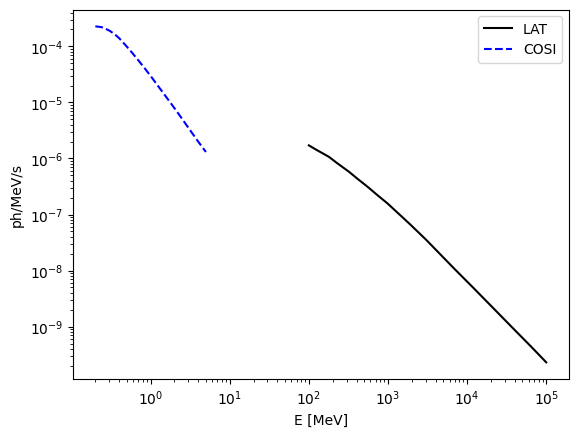

In [9]:
ph_flux_LAT_all=[]
ph_flux_COSI_all=[]
ratio_all=[]

for i in tqdm(range(len(LAT_names_all))):
    ph_flux_LAT=np.trapz(Aeff_LAT_interp.value * LAT_spec[i], e_LAT.value)
    ph_flux_LAT_all.append(ph_flux_LAT)
    
    ph_flux_COSI=np.trapz(Aeff_COSI_interp.value * COSI_spec[i], e_COSI.value)
    ph_flux_COSI_all.append(ph_flux_COSI)

    plt.close('all')
    plt.plot(e_LAT,Aeff_LAT_interp.value * LAT_spec[i],'-k',label='LAT')
    plt.plot(e_COSI,Aeff_COSI_interp.value * COSI_spec[i],'--b',label='COSI')
    plt.xlabel('E [MeV]')
    plt.ylabel('ph/MeV/s')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.savefig('./extrapolation_figures/'+LAT_names_all[i]+'_ph_per_MeV_sec.png',bbox_inches='tight')
    
    ratio=ph_flux_COSI/ph_flux_LAT
    ratio_all.append(ratio)
    

In [10]:

av_aeff_scaled_lat=[]

for i in range(len(LAT_names)):
    plt.close('all')
    name = LAT_names[i].replace(" ", "")
    pref_spec=LAT_pref_spec[i]
    e0=LAT_Enorm[i]*u.MeV
    
    if pref_spec=='PowerLaw':
        f0=LAT_PWL_norm[i]*u.Unit('MeV-1 cm-2 s-1')
        gamma=LAT_PWL_idx[i]
        
        f_LAT=f0*pow(e_LAT/e0,(-1)*gamma)
        f_mean=np.mean(f_LAT)
        f_conv=f_LAT*Aeff_LAT_interp
        
        scaled_aeff=f_conv/f_mean
        av_aeff_scaled_lat.append(np.mean(scaled_aeff.value))
        
    elif pref_spec=='LogParabola':
        f0=LAT_LP_norm[i]*u.Unit('MeV-1 cm-2 s-1')
        gamma=LAT_LP_idx[i]
        beta=LAT_LP_curv[i]

        f_LAT=f0*pow(e_LAT/e0,(-1)*(gamma+beta*np.log(e_LAT/e0)))
        f_mean=np.mean(f_LAT)
        f_conv=f_LAT*Aeff_LAT_interp
        
        scaled_aeff=f_conv/f_mean
        av_aeff_scaled_lat.append(np.mean(scaled_aeff.value))
        
    elif pref_spec=='PLSuperExpCutoff':
        f0=LAT_PWLCO_norm[i]*u.Unit('MeV-1 cm-2 s-1')
        gamma=LAT_PWLCO_idx[i]
        b=LAT_PWLCO_exp_idx[i]
        d=LAT_PWLCO_curv[i]

        f_LAT=f0*pow(e_LAT/e0,d/b-gamma)*np.exp((d/b**2)*(1-pow(e_LAT/e0,b)))
        f_mean=np.mean(f_LAT)
        f_conv=f_LAT*Aeff_LAT_interp
        
        scaled_aeff=f_conv/f_mean
        av_aeff_scaled_lat.append(np.mean(scaled_aeff.value))

for i in range(len(BAT_LAT_names)):
    plt.close('all')
    name = BAT_LAT_names[i].replace(" ", "")
    pref_spec=BAT_LAT_pref_spec[i]
    e0=BAT_LAT_Enorm[i]*u.MeV

    COSI_norm=BAT_LAT_norm[i]
    COSI_ebreak=BAT_LAT_ebreak[i]*u.keV
    COSI_ebreak=COSI_ebreak.to('MeV')
    COSI_gamma1=BAT_LAT_gamma1[i]
    COSI_gamma2=BAT_LAT_gamma2[i]
    COSI_function=BAT_LAT_function[i]
        
    if COSI_function=='smpl':
        f_LAT=bzq_spec(e_LAT,COSI_norm,COSI_ebreak,COSI_gamma1,COSI_gamma1)
    elif COSI_function=='smpl_inv':
        f_LAT=bzb_spec(e_LAT,COSI_norm,COSI_ebreak,COSI_gamma1,COSI_gamma2)
        
    f_mean=np.mean(f_LAT)
    f_conv=f_LAT*Aeff_LAT_interp
        
    scaled_aeff=f_conv/f_mean
    av_aeff_scaled_lat.append(np.mean(scaled_aeff.value))

av_aeff_scaled_lat=np.array(av_aeff_scaled_lat)


In [11]:
av_aeff_scaled_cosi=[]

for i in range(len(LAT_names)):
    plt.close('all')
    name = LAT_names[i].replace(" ", "")
    pref_spec=LAT_pref_spec[i]
    e0=LAT_Enorm[i]*u.MeV
    
    if pref_spec=='PowerLaw':
        f0=LAT_PWL_norm[i]*u.Unit('MeV-1 cm-2 s-1')
        gamma=LAT_PWL_idx[i]
        
        f_COSI=f0*pow(e_COSI/e0,(-1)*gamma)
        f_mean=np.mean(f_COSI)
        f_conv=f_COSI*Aeff_COSI_interp
        
        scaled_aeff=f_conv/f_mean
        av_aeff_scaled_cosi.append(np.mean(scaled_aeff.value))
        
    elif pref_spec=='LogParabola':
        f0=LAT_LP_norm[i]*u.Unit('MeV-1 cm-2 s-1')
        gamma=LAT_LP_idx[i]
        beta=LAT_LP_curv[i]

        f_COSI=f0*pow(e_COSI/e0,(-1)*(gamma+beta*np.log(e_COSI/e0)))
        f_mean=np.mean(f_COSI)
        f_conv=f_COSI*Aeff_COSI_interp
        
        scaled_aeff=f_conv/f_mean
        av_aeff_scaled_cosi.append(np.mean(scaled_aeff.value))
        
    elif pref_spec=='PLSuperExpCutoff':
        f0=LAT_PWLCO_norm[i]*u.Unit('MeV-1 cm-2 s-1')
        gamma=LAT_PWLCO_idx[i]
        b=LAT_PWLCO_exp_idx[i]
        d=LAT_PWLCO_curv[i]

        f_COSI=f0*pow(e_COSI/e0,d/b-gamma)*np.exp((d/b**2)*(1-pow(e_COSI/e0,b)))
        f_mean=np.mean(f_COSI)
        f_conv=f_COSI*Aeff_COSI_interp
        
        scaled_aeff=f_conv/f_mean
        av_aeff_scaled_cosi.append(np.mean(scaled_aeff.value))

for i in range(len(BAT_LAT_names)):
    COSI_norm=BAT_LAT_norm[i]
    COSI_ebreak=BAT_LAT_ebreak[i]*u.keV
    COSI_ebreak=COSI_ebreak.to('MeV')
    COSI_gamma1=BAT_LAT_gamma1[i]
    COSI_gamma2=BAT_LAT_gamma2[i]
    COSI_function=BAT_LAT_function[i]
    
    if BAT_LAT_function[i]=='smpl':
        f_COSI=bzq_spec(e_COSI,COSI_norm,COSI_ebreak,COSI_gamma1,COSI_gamma1)
        f_mean=np.mean(f_COSI)
        f_conv=f_COSI*Aeff_COSI_interp
        
        scaled_aeff=f_conv/f_mean
        av_aeff_scaled_cosi.append(np.mean(scaled_aeff.value))

    elif BAT_LAT_function[i]=='smpl_inv':
        f_COSI=bzb_spec(e_COSI,COSI_norm,COSI_ebreak,COSI_gamma1,COSI_gamma2)
        f_mean=np.mean(f_COSI)
        f_conv=f_COSI*Aeff_COSI_interp
        
        scaled_aeff=f_conv/f_mean
        av_aeff_scaled_cosi.append(np.mean(scaled_aeff.value))

av_aeff_scaled_cosi=np.array(av_aeff_scaled_cosi)


In [12]:
filename = "COSI_factors_all.csv"

# Write to CSV
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Name", "ph/s_ratio", "Aeff_mean_LAT(cm2)", "Aeff_mean_COSI(cm2)"])  # Header

    for name, value, value2, value3 in zip(LAT_names_all, ratio_all, av_aeff_scaled_lat, av_aeff_scaled_cosi):
        writer.writerow([name, value, value2, value3]) 
